In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.display import Audio
import math
from multiprocessing import Process
import random
import sys
import time

from mlos.Optimizers.OptimizationProblem import OptimizationProblem, Objective, SeriesMatchingObjective
from mlos.Optimizers.BayesianOptimizer import BayesianOptimizer
from mlos.Optimizers.BayesianOptimizerConfigStore import bayesian_optimizer_config_store
from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory
from mlos.Optimizers.OptimumDefinition import OptimumDefinition
from mlos.Optimizers.BayesianOptimizerConfigStore import bayesian_optimizer_config_store
from mlos.Optimizers.ExperimentDesigner.UtilityFunctionOptimizers.RandomNearIncumbentOptimizer import random_near_incumbent_optimizer_config_store
from mlos.Spaces import SimpleHypergrid, ContinuousDimension, DiscreteDimension, CategoricalDimension, Point

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.fft as fft
from scipy.stats import t

# Single Series Convergence Demo

In this notebook, we will be showing how the optimizer is capable of navigating a given parameter space to discover a set of paramters that minimize the error with respect to a series of points in time. 

## General Steps
The general steps in order to get series convergence to work are the following:
* Define the range of output your series can take (often in the form of a continuous dimension)
* Define the domain of your series (often in the form of a continuous dimension)
* Define your series as a pandas dataframe with the form: 

`domain.name | range.name`

`------------------------`

`x1          | y1`

`x2          | y2`

`x3          | y3`

`...         | ...`

This allows the optimizer to match a specific instance in your domain (often an instance in time) with an output

* Define your feature space as the set of things that your function simulator can take as input
* Define your objective space as a generic name like *fitness* or *series_sum_squared_error* 
* Define a series objective that defines what the objective to minimize is (fitness or series_sum_squared_error) and the relevant information to minimize that
* Create your optimization loop that registers data by putting values along the domain in a context variable and putting the result at that time in the objective dataframe 

## (Brief) Overview of internals

Series optimization works by creating a SeriesHomogeneousRandomForestRegressionModel that takes in the values you will see in the **Optimization Loop** section, converts those lists into a dataframe of observations in the standard format (no lists), and then uses a standard HomogeneousRandomForestRegressionModel underneath the hood. For predictions, it then repeatedly queries the HomoegenousRandomForestRegressionModel to arrive at a series over time and then uses a bit of probability to determine how similar the two series are and report it as a single prediction. This allows for all of the rest of the code to pretend (with a few caveats) like the SeriesObjective is just a standard Objective and a pareto frontier can be created from the error between the predicted series and the true series. 

In this demo, we will be examining the time series created by the function f(x) = 0.75(x + 2) ^ 2 + 2 * sin(2 * x)

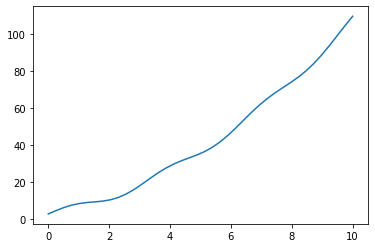

In [2]:
def f(x,a,b,c):
    return (a*(x+b)**2)+c*math.sin(c*x)

series_domain_dimension = ContinuousDimension(name="time", min=0, max=10)
series_range_dimension = ContinuousDimension(name="f_output", min=0, max=1000)
target_series_times = np.linspace(0,10,40).tolist()
target_series_values = []
for t in target_series_times:
    target_series_values.append(f(t,0.75,2,2))

target_series_df = pd.DataFrame({
    "time":target_series_times,
    "f_output": target_series_values
})

# This is a pretty simple function but it is just for demo purposes. 
plt.plot(target_series_times, target_series_values)


In [3]:
input_space = SimpleHypergrid(
    name="input",
    dimensions=[
        ContinuousDimension(name="a", min=0, max=10),
        ContinuousDimension(name="b", min=0, max=5),
        ContinuousDimension(name="c", min=0, max=5)
    ]
)

output_space = SimpleHypergrid(
    name="output",
    dimensions=[
        ContinuousDimension(name="f_fit", min=0, max=10**10)
    ]
)

optimization_problem = OptimizationProblem(
        parameter_space=input_space,
        objective_space=output_space,
        objectives=[
            SeriesMatchingObjective(
                name="f_fit", 
                target_series_df=target_series_df, 
                series_domain_dimension=series_domain_dimension,
                series_codomain_dimension=series_range_dimension,
                series_difference_metric="sum_of_squared_errors"
            )
        ]
    )

## Define the optimizer

(In this case I go with RandomNearIncumbentOptimizer because it allows for less iterations of the main loop)

In [4]:
optimizer_config = bayesian_optimizer_config_store.default

# This min_samples_required_for_guided_design_of_experiments makes sense in workloads where testing the optimizer suggestions is super fast (like a synthetic function...) 
# In workloads where it takes longer to calculate the series produced by a suggestion, a lower number makes more sense
optimizer_config.min_samples_required_for_guided_design_of_experiments = 50
optimizer_config.homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.n_new_samples_before_refit = 3
optimizer_config.homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator = 0.6
optimizer_config.homogeneous_random_forest_regression_model_config.n_estimators = 50
optimizer_config.experiment_designer_config.numeric_optimizer_implementation = "RandomNearIncumbentOptimizer"
optimizer_config.experiment_designer_config.random_near_incumbent_optimizer_config = random_near_incumbent_optimizer_config_store["20_incumbents_50_neighbors"]
# This high-random fraction is similar to min_samples_required_for_guided_design_of_experiments and makes sense when testing the function is super fast
optimizer_config.experiment_designer_config.fraction_random_suggestions = 0.30


optimizer_factory = BayesianOptimizerFactory()
optimizer = optimizer_factory.create_local_optimizer(
    optimization_problem=optimization_problem,
    optimizer_config=optimizer_config
)

08/14/2021 15:50:09 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  43 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 50,
  "homogeneous_random_forest_regression_model_config.n_estimators": 50,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 0.6,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_m

08/14/2021 15:50:09 -   BayesianOptimizerFactory -    INFO - [HomogeneousRandomForestRegressionModel.py: 120 -        _create_estimators() ] Creating DecisionTreeRegressionModel with the input_space:   Name: estimator_10_input_space
  Dimensions:
    input___b: [0.00, 5.00]
    input___a: [0.00, 10.00]
    input___c: [0.00, 5.00]
    series_context_space___time: [0.00, 10.00]
    contains_context: {False}
08/14/2021 15:50:09 -   BayesianOptimizerFactory -    INFO - [HomogeneousRandomForestRegressionModel.py: 120 -        _create_estimators() ] Creating DecisionTreeRegressionModel with the input_space:   Name: estimator_11_input_space
  Dimensions:
    input___c: [0.00, 5.00]
    series_context_space___time: [0.00, 10.00]
    contains_context: {False}
    input___a: [0.00, 10.00]
    input___b: [0.00, 5.00]
08/14/2021 15:50:09 -   BayesianOptimizerFactory -    INFO - [HomogeneousRandomForestRegressionModel.py: 120 -        _create_estimators() ] Creating DecisionTreeRegressionModel with

08/14/2021 15:50:09 -   BayesianOptimizerFactory -    INFO - [HomogeneousRandomForestRegressionModel.py: 120 -        _create_estimators() ] Creating DecisionTreeRegressionModel with the input_space:   Name: estimator_31_input_space
  Dimensions:
    contains_context: {False}
    input___a: [0.00, 10.00]
    input___b: [0.00, 5.00]
    input___c: [0.00, 5.00]
    series_context_space___time: [0.00, 10.00]
08/14/2021 15:50:09 -   BayesianOptimizerFactory -    INFO - [HomogeneousRandomForestRegressionModel.py: 120 -        _create_estimators() ] Creating DecisionTreeRegressionModel with the input_space:   Name: estimator_32_input_space
  Dimensions:
    input___c: [0.00, 5.00]
    input___a: [0.00, 10.00]
    contains_context: {False}
    series_context_space___time: [0.00, 10.00]
    input___b: [0.00, 5.00]
08/14/2021 15:50:09 -   BayesianOptimizerFactory -    INFO - [HomogeneousRandomForestRegressionModel.py: 120 -        _create_estimators() ] Creating DecisionTreeRegressionModel with

## Optimization Loop

**Warning**: this can take a very long time (>1hour). The RandomNearIncumbentOptimizer can be quite slow. 

In [5]:
for current_iteration in range(500):
    print(f"Current iteration: {current_iteration}")
    
    suggested_value = optimizer.suggest()
    input_values_df = suggested_value.to_dataframe()
    
    
    # Note that in this case we use times from the same instance as the target series. This is NOT required. However, it does help the model.
    function_sample_times = target_series_times
    function_values = []
    for time in function_sample_times:
        function_value_at_time = f(
            time,
            suggested_value["a"],
            suggested_value["b"],
            suggested_value["c"]
        )
        function_values.append(function_value_at_time)
        
    # Note that this passes a context when no context even when the context is not defined with one
    # This is how the points at which the function was sampled can be passed to the SeriesHomogeneousRandomForestRegressionModel
    #
    context_values_df = pd.DataFrame({
        series_domain_dimension.name: [function_sample_times] 
    })
    
    # Note that this defines a dataframe whose entires are LISTS, not single points. This means that each observation has a list associated with it instead of a single value
    # at every time step 
    #
    target_values_df = pd.DataFrame({
       series_range_dimension.name: [function_values]
    })
    
    # REGISTER
    #
    optimizer.register(input_values_df, target_values_df, context_values_df)
    
    


08/14/2021 15:50:20 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 7.305352814140074,
  "b": 0.7831994426644839,
  "c": 3.7448483702639908
}
08/14/2021 15:50:20 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.
08/14/2021 15:50:20 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 4.724979467217834,
  "b": 2.0192510749754744,
  "c": 4.507986018048989
}
08/14/2021 15:50:20 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.
08/14/2021 15:50:20 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 8.802420907234955,
  "b": 2.2678365767411495,
  "c

Current iteration: 0
Current iteration: 1
Current iteration: 2
Current iteration: 3
Current iteration: 4
Current iteration: 5
Current iteration: 6
Current iteration: 7
Current iteration: 8
Current iteration: 9
Current iteration: 10
Current iteration: 11
Current iteration: 12
Current iteration: 13
Current iteration: 14
Current iteration: 15
Current iteration: 16
Current iteration: 17
Current iteration: 18
Current iteration: 19


08/14/2021 15:50:20 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.
08/14/2021 15:50:20 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 9.650088212707093,
  "b": 4.9663855171944205,
  "c": 4.173950708760214
}
08/14/2021 15:50:20 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.
08/14/2021 15:50:20 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 8.462798049462785,
  "b": 0.4574639204040576,
  "c": 0.6281977335225752
}
08/14/2021 15:50:20 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.
08/14/2021 15:50:20 -   BayesianOptimizerFacto

Current iteration: 20
Current iteration: 21
Current iteration: 22
Current iteration: 23
Current iteration: 24
Current iteration: 25
Current iteration: 26
Current iteration: 27
Current iteration: 28
Current iteration: 29
Current iteration: 30
Current iteration: 31
Current iteration: 32
Current iteration: 33
Current iteration: 34
Current iteration: 35
Current iteration: 36
Current iteration: 37
Current iteration: 38
Current iteration: 39
Current iteration: 40


08/14/2021 15:50:20 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.
08/14/2021 15:50:20 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 0.24113002960848506,
  "b": 3.748343042108827,
  "c": 2.648225787664434
}
08/14/2021 15:50:20 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.
08/14/2021 15:50:20 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 4.536327313507721,
  "b": 3.779608460759187,
  "c": 3.4009230304992153
}
08/14/2021 15:50:20 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.
08/14/2021 15:50:20 -   BayesianOptimizerFacto

Current iteration: 41
Current iteration: 42
Current iteration: 43
Current iteration: 44
Current iteration: 45
Current iteration: 46
Current iteration: 47
Current iteration: 48
Current iteration: 49


08/14/2021 15:50:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 15:50:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 15:50:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 15:50:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 360 - _prepare_initial_params_df() ] No cached params are available.
08/14/2021 15:50:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 19 random points as starting configs.


Current iteration: 50


08/14/2021 15:50:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 15:50:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 590. Parameter space filtered them down to 590
08/14/2021 15:50:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 590 random neighbors.
08/14/2021 15:50:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 292 have positive utility gain.
08/14/2021 15:50:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 20 neighbors improved upon their respective incumbents.
08/14/2021 15:50:27 -   BayesianOptimizerFactory -   

08/14/2021 15:51:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 15:51:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/14/2021 15:51:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 1000. Parameter space filtered them down to 1000
08/14/2021 15:51:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 1000 random neighbors.
08/14/2021 15:51:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 335 have positive utility gain.
08/14/2021 15:51:22 -   BayesianOptimizerFactory

Current iteration: 51


08/14/2021 15:51:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 15:51:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 512. Parameter space filtered them down to 512
08/14/2021 15:52:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 512 random neighbors.
08/14/2021 15:52:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 160 have positive utility gain.
08/14/2021 15:52:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 15:52:01 -   BayesianOptimizerFactory -   

08/14/2021 15:52:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 15:52:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 15:52:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 979. Parameter space filtered them down to 979
08/14/2021 15:52:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 979 random neighbors.
08/14/2021 15:52:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 753 have positive utility gain.
08/14/2021 15:52:53 -   BayesianOptimizerFactory -   

Current iteration: 52


08/14/2021 15:53:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 15:53:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 15:53:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 2 of 2 pareto points as starting configs.
08/14/2021 15:53:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 40 cached good configs as starting configs
08/14/2021 15:53:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 12 random points as starting configs.


Current iteration: 53


08/14/2021 15:53:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 15:53:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 447. Parameter space filtered them down to 447
08/14/2021 15:53:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 447 random neighbors.
08/14/2021 15:53:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 138 have positive utility gain.
08/14/2021 15:53:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 15:53:20 -   BayesianOptimizerFactory -   

08/14/2021 15:54:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 15:54:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 15:54:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 971. Parameter space filtered them down to 971
08/14/2021 15:54:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 971 random neighbors.
08/14/2021 15:54:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 356 have positive utility gain.
08/14/2021 15:54:15 -   BayesianOptimizerFactory -   

Current iteration: 54


08/14/2021 15:54:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 15:54:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 453. Parameter space filtered them down to 453
08/14/2021 15:54:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 453 random neighbors.
08/14/2021 15:54:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 148 have positive utility gain.
08/14/2021 15:54:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 15:54:49 -   BayesianOptimizerFactory -   

08/14/2021 15:55:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 15:55:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 15:55:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 967. Parameter space filtered them down to 967
08/14/2021 15:55:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 967 random neighbors.
08/14/2021 15:55:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 569 have positive utility gain.
08/14/2021 15:55:43 -   BayesianOptimizerFactory -   

Current iteration: 55


08/14/2021 15:56:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 15:56:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 15:56:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/14/2021 15:56:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 80 cached good configs as starting configs
08/14/2021 15:56:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 56


08/14/2021 15:56:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 15:56:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 524. Parameter space filtered them down to 524
08/14/2021 15:56:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 524 random neighbors.
08/14/2021 15:56:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 179 have positive utility gain.
08/14/2021 15:56:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 15:56:11 -   BayesianOptimizerFactory -   

08/14/2021 15:56:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 15:56:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 15:56:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 982. Parameter space filtered them down to 982
08/14/2021 15:57:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 982 random neighbors.
08/14/2021 15:57:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 633 have positive utility gain.
08/14/2021 15:57:05 -   BayesianOptimizerFactory -   

Current iteration: 57


08/14/2021 15:57:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 15:57:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 448. Parameter space filtered them down to 448
08/14/2021 15:57:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 448 random neighbors.
08/14/2021 15:57:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 96 have positive utility gain.
08/14/2021 15:57:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 15:57:31 -   BayesianOptimizerFactory -    

08/14/2021 15:58:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 15:58:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 15:58:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 960. Parameter space filtered them down to 960
08/14/2021 15:58:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 960 random neighbors.
08/14/2021 15:58:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 520 have positive utility gain.
08/14/2021 15:58:24 -   BayesianOptimizerFactory -   

Current iteration: 58


08/14/2021 15:58:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 15:58:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 483. Parameter space filtered them down to 483
08/14/2021 15:58:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 483 random neighbors.
08/14/2021 15:58:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 125 have positive utility gain.
08/14/2021 15:58:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 15:58:51 -   BayesianOptimizerFactory -   

08/14/2021 15:59:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 15:59:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/14/2021 15:59:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 1000. Parameter space filtered them down to 1000
08/14/2021 15:59:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 1000 random neighbors.
08/14/2021 15:59:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 650 have positive utility gain.
08/14/2021 15:59:45 -   BayesianOptimizerFactory

Current iteration: 59


08/14/2021 16:00:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 16:00:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 16:00:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 7 of 7 pareto points as starting configs.
08/14/2021 16:00:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 140 cached good configs as starting configs
08/14/2021 16:00:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 7 random points as starting configs.


Current iteration: 60


08/14/2021 16:00:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:00:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 522. Parameter space filtered them down to 522
08/14/2021 16:00:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 522 random neighbors.
08/14/2021 16:00:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 159 have positive utility gain.
08/14/2021 16:00:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 16:00:13 -   BayesianOptimizerFactory -   

08/14/2021 16:01:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 16:01:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 9/20, num neighbors per incumbent: 111
08/14/2021 16:01:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 999. Adapter filtered them down to 893. Parameter space filtered them down to 893
08/14/2021 16:01:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 893 random neighbors.
08/14/2021 16:01:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 719 have positive utility gain.
08/14/2021 16:01:06 -   BayesianOptimizerFactory -   

Current iteration: 61


08/14/2021 16:01:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:01:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 445. Parameter space filtered them down to 445
08/14/2021 16:01:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 445 random neighbors.
08/14/2021 16:01:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 88 have positive utility gain.
08/14/2021 16:01:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 16:01:31 -   BayesianOptimizerFactory -    

08/14/2021 16:02:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 16:02:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 16:02:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 989. Parameter space filtered them down to 989
08/14/2021 16:02:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 989 random neighbors.
08/14/2021 16:02:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 685 have positive utility gain.
08/14/2021 16:02:23 -   BayesianOptimizerFactory -   

Current iteration: 62


08/14/2021 16:02:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 16:02:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 16:02:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 9 of 9 pareto points as starting configs.
08/14/2021 16:02:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 180 cached good configs as starting configs
08/14/2021 16:02:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 5 random points as starting configs.


Current iteration: 63


08/14/2021 16:02:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:02:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 482. Parameter space filtered them down to 482
08/14/2021 16:02:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 482 random neighbors.
08/14/2021 16:02:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 97 have positive utility gain.
08/14/2021 16:02:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 16:02:50 -   BayesianOptimizerFactory -    

08/14/2021 16:03:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 19 neighbors improved upon their respective incumbents.
08/14/2021 16:03:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 16:03:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 980. Parameter space filtered them down to 980
08/14/2021 16:03:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 980 random neighbors.
08/14/2021 16:03:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 686 have positive utility gain.
08/14/2021 16:03:42 -   BayesianOptimizerFactory -   

Current iteration: 64


08/14/2021 16:04:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:04:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 425. Parameter space filtered them down to 425
08/14/2021 16:04:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 425 random neighbors.
08/14/2021 16:04:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 75 have positive utility gain.
08/14/2021 16:04:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 16:04:14 -   BayesianOptimizerFactory -    

08/14/2021 16:05:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 20 neighbors improved upon their respective incumbents.
08/14/2021 16:05:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 16:05:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 16:05:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 16:05:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 581 have positive utility gain.
08/14/2021 16:05:06 -   BayesianOptimizerFactory -   

Current iteration: 65


08/14/2021 16:05:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:05:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 432. Parameter space filtered them down to 432
08/14/2021 16:05:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 432 random neighbors.
08/14/2021 16:05:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 60 have positive utility gain.
08/14/2021 16:05:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 16:05:33 -   BayesianOptimizerFactory -    

08/14/2021 16:06:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 20 neighbors improved upon their respective incumbents.
08/14/2021 16:06:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/14/2021 16:06:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 967. Parameter space filtered them down to 967
08/14/2021 16:06:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 967 random neighbors.
08/14/2021 16:06:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 609 have positive utility gain.
08/14/2021 16:06:25 -   BayesianOptimizerFactory -   

Current iteration: 66


08/14/2021 16:07:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:07:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 517. Parameter space filtered them down to 517
08/14/2021 16:07:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 517 random neighbors.
08/14/2021 16:07:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 124 have positive utility gain.
08/14/2021 16:07:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 16:07:05 -   BayesianOptimizerFactory -   

08/14/2021 16:07:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 16:07:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 16:07:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 974. Parameter space filtered them down to 974
08/14/2021 16:07:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 974 random neighbors.
08/14/2021 16:07:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 736 have positive utility gain.
08/14/2021 16:07:57 -   BayesianOptimizerFactory -   

Current iteration: 67


08/14/2021 16:08:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 16:08:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 16:08:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 10 of 13 pareto points as starting configs.
08/14/2021 16:08:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 260 cached good configs as starting configs
08/14/2021 16:08:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 4 random points as starting configs.


Current iteration: 68


08/14/2021 16:08:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:08:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 431. Parameter space filtered them down to 431
08/14/2021 16:08:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 431 random neighbors.
08/14/2021 16:08:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 70 have positive utility gain.
08/14/2021 16:08:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 16:08:17 -   BayesianOptimizerFactory -    

08/14/2021 16:09:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 16:09:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 16:09:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 996. Parameter space filtered them down to 996
08/14/2021 16:09:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 996 random neighbors.
08/14/2021 16:09:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 617 have positive utility gain.
08/14/2021 16:09:09 -   BayesianOptimizerFactory -   

Current iteration: 69


08/14/2021 16:09:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:09:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 434. Parameter space filtered them down to 434
08/14/2021 16:09:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 434 random neighbors.
08/14/2021 16:09:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 79 have positive utility gain.
08/14/2021 16:09:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 16:09:28 -   BayesianOptimizerFactory -    

08/14/2021 16:10:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 16:10:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 16:10:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 16:10:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 16:10:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 716 have positive utility gain.
08/14/2021 16:10:21 -   BayesianOptimizerFactory -   

Current iteration: 70


08/14/2021 16:10:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 16:10:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 16:10:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 10 of 15 pareto points as starting configs.
08/14/2021 16:10:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 300 cached good configs as starting configs
08/14/2021 16:10:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 4 random points as starting configs.


Current iteration: 71


08/14/2021 16:10:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:10:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 490. Parameter space filtered them down to 490
08/14/2021 16:11:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 490 random neighbors.
08/14/2021 16:11:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 89 have positive utility gain.
08/14/2021 16:11:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 16:11:02 -   BayesianOptimizerFactory -    

08/14/2021 16:11:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 16:11:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 16:11:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 992. Parameter space filtered them down to 992
08/14/2021 16:11:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 992 random neighbors.
08/14/2021 16:11:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 665 have positive utility gain.
08/14/2021 16:11:55 -   BayesianOptimizerFactory -   

Current iteration: 72


08/14/2021 16:12:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:12:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 397. Parameter space filtered them down to 397
08/14/2021 16:12:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 397 random neighbors.
08/14/2021 16:12:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 46 have positive utility gain.
08/14/2021 16:12:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 16:12:34 -   BayesianOptimizerFactory -    

08/14/2021 16:13:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 19 neighbors improved upon their respective incumbents.
08/14/2021 16:13:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/14/2021 16:13:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 986. Parameter space filtered them down to 986
08/14/2021 16:13:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 986 random neighbors.
08/14/2021 16:13:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 578 have positive utility gain.
08/14/2021 16:13:27 -   BayesianOptimizerFactory -   

Current iteration: 73


08/14/2021 16:13:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:13:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 411. Parameter space filtered them down to 411
08/14/2021 16:13:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 411 random neighbors.
08/14/2021 16:13:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 97 have positive utility gain.
08/14/2021 16:13:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 16:13:46 -   BayesianOptimizerFactory -    

08/14/2021 16:14:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 16:14:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 16:14:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 963. Parameter space filtered them down to 963
08/14/2021 16:14:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 963 random neighbors.
08/14/2021 16:14:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 643 have positive utility gain.
08/14/2021 16:14:38 -   BayesianOptimizerFactory -   

Current iteration: 74


08/14/2021 16:15:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:15:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 435. Parameter space filtered them down to 435
08/14/2021 16:15:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 435 random neighbors.
08/14/2021 16:15:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 62 have positive utility gain.
08/14/2021 16:15:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 16:15:16 -   BayesianOptimizerFactory -    

08/14/2021 16:16:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 19 neighbors improved upon their respective incumbents.
08/14/2021 16:16:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 9/20, num neighbors per incumbent: 111
08/14/2021 16:16:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 999. Adapter filtered them down to 999. Parameter space filtered them down to 999
08/14/2021 16:16:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 999 random neighbors.
08/14/2021 16:16:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 522 have positive utility gain.
08/14/2021 16:16:08 -   BayesianOptimizerFactory -   

Current iteration: 75


08/14/2021 16:16:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:16:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 432. Parameter space filtered them down to 432
08/14/2021 16:16:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 432 random neighbors.
08/14/2021 16:16:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 56 have positive utility gain.
08/14/2021 16:16:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 16:16:34 -   BayesianOptimizerFactory -    

08/14/2021 16:17:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 19 neighbors improved upon their respective incumbents.
08/14/2021 16:17:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/14/2021 16:17:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 986. Parameter space filtered them down to 986
08/14/2021 16:17:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 986 random neighbors.
08/14/2021 16:17:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 659 have positive utility gain.
08/14/2021 16:17:27 -   BayesianOptimizerFactory -   

Current iteration: 76


08/14/2021 16:17:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:17:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 479. Parameter space filtered them down to 479
08/14/2021 16:17:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 479 random neighbors.
08/14/2021 16:17:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 73 have positive utility gain.
08/14/2021 16:17:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 16:17:59 -   BayesianOptimizerFactory -    

08/14/2021 16:18:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 19 neighbors improved upon their respective incumbents.
08/14/2021 16:18:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 16:18:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 985. Parameter space filtered them down to 985
08/14/2021 16:18:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 985 random neighbors.
08/14/2021 16:18:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 681 have positive utility gain.
08/14/2021 16:18:50 -   BayesianOptimizerFactory -   

Current iteration: 77


08/14/2021 16:19:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 16:19:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 16:19:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 10 of 21 pareto points as starting configs.
08/14/2021 16:19:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 420 cached good configs as starting configs
08/14/2021 16:19:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 4 random points as starting configs.


Current iteration: 78


08/14/2021 16:19:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:19:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 476. Parameter space filtered them down to 476
08/14/2021 16:19:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 476 random neighbors.
08/14/2021 16:19:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 83 have positive utility gain.
08/14/2021 16:19:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 16:19:30 -   BayesianOptimizerFactory -    

08/14/2021 16:20:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 16:20:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 16:20:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 982. Parameter space filtered them down to 982
08/14/2021 16:20:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 982 random neighbors.
08/14/2021 16:20:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 613 have positive utility gain.
08/14/2021 16:20:22 -   BayesianOptimizerFactory -   

Current iteration: 79


08/14/2021 16:20:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 16:20:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 16:20:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 10 of 22 pareto points as starting configs.
08/14/2021 16:20:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 440 cached good configs as starting configs
08/14/2021 16:20:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 4 random points as starting configs.


Current iteration: 80


08/14/2021 16:20:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:20:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 492. Parameter space filtered them down to 492
08/14/2021 16:20:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 492 random neighbors.
08/14/2021 16:20:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 117 have positive utility gain.
08/14/2021 16:20:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 16:20:50 -   BayesianOptimizerFactory -   

08/14/2021 16:21:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 16:21:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 16:21:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 16:21:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 16:21:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 628 have positive utility gain.
08/14/2021 16:21:42 -   BayesianOptimizerFactory -   

Current iteration: 81


08/14/2021 16:22:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:22:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 417. Parameter space filtered them down to 417
08/14/2021 16:22:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 417 random neighbors.
08/14/2021 16:22:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 51 have positive utility gain.
08/14/2021 16:22:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 16:22:21 -   BayesianOptimizerFactory -    

08/14/2021 16:23:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 19 neighbors improved upon their respective incumbents.
08/14/2021 16:23:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 16:23:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 973. Parameter space filtered them down to 973
08/14/2021 16:23:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 973 random neighbors.
08/14/2021 16:23:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 630 have positive utility gain.
08/14/2021 16:23:13 -   BayesianOptimizerFactory -   

Current iteration: 82


08/14/2021 16:23:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:23:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 482. Parameter space filtered them down to 482
08/14/2021 16:23:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 482 random neighbors.
08/14/2021 16:23:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 71 have positive utility gain.
08/14/2021 16:23:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 16:23:38 -   BayesianOptimizerFactory -    I

08/14/2021 16:24:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 20 neighbors improved upon their respective incumbents.
08/14/2021 16:24:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/14/2021 16:24:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 959. Parameter space filtered them down to 959
08/14/2021 16:24:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 959 random neighbors.
08/14/2021 16:24:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 598 have positive utility gain.
08/14/2021 16:24:29 -   BayesianOptimizerFactory -   

Current iteration: 83


08/14/2021 16:25:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:25:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 421. Parameter space filtered them down to 421
08/14/2021 16:25:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 421 random neighbors.
08/14/2021 16:25:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 59 have positive utility gain.
08/14/2021 16:25:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 16:25:04 -   BayesianOptimizerFactory -    I

08/14/2021 16:25:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 20 neighbors improved upon their respective incumbents.
08/14/2021 16:25:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 16:25:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 16:25:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 16:25:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 705 have positive utility gain.
08/14/2021 16:25:55 -   BayesianOptimizerFactory -   

Current iteration: 84


08/14/2021 16:26:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:26:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 477. Parameter space filtered them down to 477
08/14/2021 16:26:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 477 random neighbors.
08/14/2021 16:26:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 165 have positive utility gain.
08/14/2021 16:26:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 16:26:23 -   BayesianOptimizerFactory -   

08/14/2021 16:27:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 16:27:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 16:27:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 989. Parameter space filtered them down to 989
08/14/2021 16:27:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 989 random neighbors.
08/14/2021 16:27:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 149 have positive utility gain.
08/14/2021 16:27:18 -   BayesianOptimizerFactory -   

Current iteration: 85


08/14/2021 16:27:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:27:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 526. Parameter space filtered them down to 526
08/14/2021 16:27:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 526 random neighbors.
08/14/2021 16:27:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 187 have positive utility gain.
08/14/2021 16:27:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 16:27:57 -   BayesianOptimizerFactory -   

08/14/2021 16:28:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 16:28:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 16:28:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 16:28:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 16:28:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 174 have positive utility gain.
08/14/2021 16:28:54 -   BayesianOptimizerFactory -   

Current iteration: 86


08/14/2021 16:29:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 16:29:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 16:29:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 16:29:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 560 cached good configs as starting configs
08/14/2021 16:29:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 87


08/14/2021 16:29:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:29:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 542. Parameter space filtered them down to 542
08/14/2021 16:29:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 542 random neighbors.
08/14/2021 16:29:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 208 have positive utility gain.
08/14/2021 16:29:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 20 neighbors improved upon their respective incumbents.
08/14/2021 16:29:29 -   BayesianOptimizerFactory -   

08/14/2021 16:30:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 16:30:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 16:30:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 16:30:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 16:30:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 156 have positive utility gain.
08/14/2021 16:30:23 -   BayesianOptimizerFactory -   

Current iteration: 88


08/14/2021 16:30:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:30:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 479. Parameter space filtered them down to 479
08/14/2021 16:31:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 479 random neighbors.
08/14/2021 16:31:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 181 have positive utility gain.
08/14/2021 16:31:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 16:31:03 -   BayesianOptimizerFactory -   

08/14/2021 16:31:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 16:31:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 16:31:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 16:31:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 16:31:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 136 have positive utility gain.
08/14/2021 16:31:58 -   BayesianOptimizerFactory -   

Current iteration: 89


08/14/2021 16:32:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:32:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 534. Parameter space filtered them down to 534
08/14/2021 16:32:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 534 random neighbors.
08/14/2021 16:32:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 248 have positive utility gain.
08/14/2021 16:32:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 16:32:31 -   BayesianOptimizerFactory -   

08/14/2021 16:33:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 16:33:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 16:33:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 945. Parameter space filtered them down to 945
08/14/2021 16:33:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 945 random neighbors.
08/14/2021 16:33:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 172 have positive utility gain.
08/14/2021 16:33:25 -   BayesianOptimizerFactory -   

Current iteration: 90


08/14/2021 16:33:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:33:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 483. Parameter space filtered them down to 483
08/14/2021 16:33:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 483 random neighbors.
08/14/2021 16:33:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 197 have positive utility gain.
08/14/2021 16:33:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 16:33:44 -   BayesianOptimizerFactory -   

08/14/2021 16:34:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 16:34:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 16:34:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 16:34:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 16:34:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 69 have positive utility gain.
08/14/2021 16:34:40 -   BayesianOptimizerFactory -    

Current iteration: 91


08/14/2021 16:35:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 16:35:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 16:35:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 16:35:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 640 cached good configs as starting configs
08/14/2021 16:35:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 92


08/14/2021 16:35:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:35:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 492. Parameter space filtered them down to 492
08/14/2021 16:35:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 492 random neighbors.
08/14/2021 16:35:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 189 have positive utility gain.
08/14/2021 16:35:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 19 neighbors improved upon their respective incumbents.
08/14/2021 16:35:21 -   BayesianOptimizerFactory -   

08/14/2021 16:36:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 16:36:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 16:36:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 16:36:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 16:36:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 113 have positive utility gain.
08/14/2021 16:36:16 -   BayesianOptimizerFactory -   

Current iteration: 93


08/14/2021 16:36:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:36:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 552. Parameter space filtered them down to 552
08/14/2021 16:36:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 552 random neighbors.
08/14/2021 16:36:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 208 have positive utility gain.
08/14/2021 16:36:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 16:36:55 -   BayesianOptimizerFactory -   

08/14/2021 16:37:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 16:37:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 16:37:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 989. Parameter space filtered them down to 989
08/14/2021 16:37:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 989 random neighbors.
08/14/2021 16:37:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 139 have positive utility gain.
08/14/2021 16:37:54 -   BayesianOptimizerFactory -   

Current iteration: 94


08/14/2021 16:38:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:38:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 565. Parameter space filtered them down to 565
08/14/2021 16:38:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 565 random neighbors.
08/14/2021 16:38:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 220 have positive utility gain.
08/14/2021 16:38:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 19 neighbors improved upon their respective incumbents.
08/14/2021 16:38:26 -   BayesianOptimizerFactory -   

08/14/2021 16:39:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 16:39:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 16:39:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 16:39:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 16:39:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 86 have positive utility gain.
08/14/2021 16:39:29 -   BayesianOptimizerFactory -    

Current iteration: 95


08/14/2021 16:39:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:39:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 513. Parameter space filtered them down to 513
08/14/2021 16:40:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 513 random neighbors.
08/14/2021 16:40:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 200 have positive utility gain.
08/14/2021 16:40:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 16:40:02 -   BayesianOptimizerFactory -   

08/14/2021 16:40:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 16:40:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 16:40:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 16:40:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 16:40:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 178 have positive utility gain.
08/14/2021 16:40:56 -   BayesianOptimizerFactory -   

Current iteration: 96


08/14/2021 16:41:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 16:41:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 16:41:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 16:41:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 720 cached good configs as starting configs
08/14/2021 16:41:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 97


08/14/2021 16:41:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:41:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 531. Parameter space filtered them down to 531
08/14/2021 16:41:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 531 random neighbors.
08/14/2021 16:41:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 240 have positive utility gain.
08/14/2021 16:41:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 16:41:24 -   BayesianOptimizerFactory -   

08/14/2021 16:42:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 16:42:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 16:42:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 980. Parameter space filtered them down to 980
08/14/2021 16:42:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 980 random neighbors.
08/14/2021 16:42:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 153 have positive utility gain.
08/14/2021 16:42:19 -   BayesianOptimizerFactory -   

Current iteration: 98


08/14/2021 16:42:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:42:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 548. Parameter space filtered them down to 548
08/14/2021 16:43:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 548 random neighbors.
08/14/2021 16:43:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 215 have positive utility gain.
08/14/2021 16:43:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 16:43:00 -   BayesianOptimizerFactory -   

08/14/2021 16:43:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 16:43:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 16:43:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 996. Parameter space filtered them down to 996
08/14/2021 16:43:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 996 random neighbors.
08/14/2021 16:43:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 51 have positive utility gain.
08/14/2021 16:43:55 -   BayesianOptimizerFactory -    

Current iteration: 99


08/14/2021 16:44:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:44:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 564. Parameter space filtered them down to 564
08/14/2021 16:44:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 564 random neighbors.
08/14/2021 16:44:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 200 have positive utility gain.
08/14/2021 16:44:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 16:44:28 -   BayesianOptimizerFactory -   

08/14/2021 16:45:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 16:45:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 16:45:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 987. Parameter space filtered them down to 987
08/14/2021 16:45:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 987 random neighbors.
08/14/2021 16:45:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 120 have positive utility gain.
08/14/2021 16:45:24 -   BayesianOptimizerFactory -   

Current iteration: 100


08/14/2021 16:46:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:46:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 511. Parameter space filtered them down to 511
08/14/2021 16:46:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 511 random neighbors.
08/14/2021 16:46:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 187 have positive utility gain.
08/14/2021 16:46:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 16:46:04 -   BayesianOptimizerFactory -   

08/14/2021 16:46:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 16:46:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 16:46:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 985. Parameter space filtered them down to 985
08/14/2021 16:46:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 985 random neighbors.
08/14/2021 16:46:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 175 have positive utility gain.
08/14/2021 16:46:59 -   BayesianOptimizerFactory -   

Current iteration: 101


08/14/2021 16:47:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 16:47:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 16:47:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 16:47:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 800 cached good configs as starting configs
08/14/2021 16:47:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 102


08/14/2021 16:47:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:47:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 625. Parameter space filtered them down to 625
08/14/2021 16:47:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 625 random neighbors.
08/14/2021 16:47:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 239 have positive utility gain.
08/14/2021 16:47:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 16:47:41 -   BayesianOptimizerFactory -   

08/14/2021 16:48:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 16:48:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 16:48:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 16:48:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 16:48:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 129 have positive utility gain.
08/14/2021 16:48:38 -   BayesianOptimizerFactory -   

Current iteration: 103


08/14/2021 16:49:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:49:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 519. Parameter space filtered them down to 519
08/14/2021 16:49:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 519 random neighbors.
08/14/2021 16:49:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 214 have positive utility gain.
08/14/2021 16:49:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 16:49:18 -   BayesianOptimizerFactory -   

08/14/2021 16:50:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 16:50:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 16:50:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 983. Parameter space filtered them down to 983
08/14/2021 16:50:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 983 random neighbors.
08/14/2021 16:50:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 153 have positive utility gain.
08/14/2021 16:50:13 -   BayesianOptimizerFactory -   

Current iteration: 104


08/14/2021 16:50:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 16:50:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 16:50:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 16:50:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 840 cached good configs as starting configs
08/14/2021 16:50:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 105


08/14/2021 16:50:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:50:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 543. Parameter space filtered them down to 543
08/14/2021 16:50:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 543 random neighbors.
08/14/2021 16:50:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 221 have positive utility gain.
08/14/2021 16:50:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 16:50:47 -   BayesianOptimizerFactory -   

08/14/2021 16:51:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 16:51:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 16:51:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 16:51:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 16:51:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 159 have positive utility gain.
08/14/2021 16:51:42 -   BayesianOptimizerFactory -   

Current iteration: 106


08/14/2021 16:52:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 16:52:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 16:52:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 16:52:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 860 cached good configs as starting configs
08/14/2021 16:52:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 107


08/14/2021 16:52:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:52:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 572. Parameter space filtered them down to 572
08/14/2021 16:52:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 572 random neighbors.
08/14/2021 16:52:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 232 have positive utility gain.
08/14/2021 16:52:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 16:52:23 -   BayesianOptimizerFactory -   

08/14/2021 16:53:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 16:53:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 16:53:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 16:53:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 16:53:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 149 have positive utility gain.
08/14/2021 16:53:20 -   BayesianOptimizerFactory -   

Current iteration: 108


08/14/2021 16:53:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:53:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 514. Parameter space filtered them down to 514
08/14/2021 16:54:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 514 random neighbors.
08/14/2021 16:54:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 192 have positive utility gain.
08/14/2021 16:54:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 16:54:00 -   BayesianOptimizerFactory -   

08/14/2021 16:54:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 16:54:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 16:54:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 992. Parameter space filtered them down to 992
08/14/2021 16:54:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 992 random neighbors.
08/14/2021 16:54:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 157 have positive utility gain.
08/14/2021 16:54:56 -   BayesianOptimizerFactory -   

Current iteration: 109


08/14/2021 16:55:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:55:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 527. Parameter space filtered them down to 527
08/14/2021 16:55:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 527 random neighbors.
08/14/2021 16:55:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 208 have positive utility gain.
08/14/2021 16:55:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 16:55:29 -   BayesianOptimizerFactory -   

08/14/2021 16:56:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 16:56:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 16:56:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 996. Parameter space filtered them down to 996
08/14/2021 16:56:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 996 random neighbors.
08/14/2021 16:56:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 37 have positive utility gain.
08/14/2021 16:56:25 -   BayesianOptimizerFactory -    

Current iteration: 110


08/14/2021 16:56:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:56:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 545. Parameter space filtered them down to 545
08/14/2021 16:56:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 545 random neighbors.
08/14/2021 16:56:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 203 have positive utility gain.
08/14/2021 16:56:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 16:56:52 -   BayesianOptimizerFactory -   

08/14/2021 16:57:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 16:57:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 16:57:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 16:57:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 16:57:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 214 have positive utility gain.
08/14/2021 16:57:47 -   BayesianOptimizerFactory -   

Current iteration: 111


08/14/2021 16:58:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:58:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 497. Parameter space filtered them down to 497
08/14/2021 16:58:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 497 random neighbors.
08/14/2021 16:58:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 243 have positive utility gain.
08/14/2021 16:58:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 16:58:28 -   BayesianOptimizerFactory -   

08/14/2021 16:59:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 16:59:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/14/2021 16:59:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 999. Parameter space filtered them down to 999
08/14/2021 16:59:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 999 random neighbors.
08/14/2021 16:59:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 181 have positive utility gain.
08/14/2021 16:59:25 -   BayesianOptimizerFactory - 

Current iteration: 112


08/14/2021 16:59:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 16:59:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 548. Parameter space filtered them down to 548
08/14/2021 16:59:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 548 random neighbors.
08/14/2021 16:59:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 183 have positive utility gain.
08/14/2021 16:59:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 16:59:52 -   BayesianOptimizerFactory -   

08/14/2021 17:00:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 17:00:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 17:00:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 17:00:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 17:00:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 159 have positive utility gain.
08/14/2021 17:00:47 -   BayesianOptimizerFactory -   

Current iteration: 113


08/14/2021 17:01:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:01:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 516. Parameter space filtered them down to 516
08/14/2021 17:01:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 516 random neighbors.
08/14/2021 17:01:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 214 have positive utility gain.
08/14/2021 17:01:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 17:01:13 -   BayesianOptimizerFactory -   

08/14/2021 17:02:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 17:02:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 17:02:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 987. Parameter space filtered them down to 987
08/14/2021 17:02:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 987 random neighbors.
08/14/2021 17:02:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 110 have positive utility gain.
08/14/2021 17:02:08 -   BayesianOptimizerFactory -   

Current iteration: 114


08/14/2021 17:02:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:02:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 540. Parameter space filtered them down to 540
08/14/2021 17:02:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 540 random neighbors.
08/14/2021 17:02:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 216 have positive utility gain.
08/14/2021 17:02:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 17:02:49 -   BayesianOptimizerFactory -   

08/14/2021 17:03:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 17:03:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 17:03:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 17:03:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 17:03:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 133 have positive utility gain.
08/14/2021 17:03:44 -   BayesianOptimizerFactory -    

Current iteration: 115


08/14/2021 17:04:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:04:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 628. Parameter space filtered them down to 628
08/14/2021 17:04:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 628 random neighbors.
08/14/2021 17:04:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 284 have positive utility gain.
08/14/2021 17:04:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 17:04:24 -   BayesianOptimizerFactory -   

08/14/2021 17:05:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 17:05:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 17:05:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 17:05:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 17:05:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 238 have positive utility gain.
08/14/2021 17:05:20 -   BayesianOptimizerFactory -   

Current iteration: 116


08/14/2021 17:05:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:05:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 517. Parameter space filtered them down to 517
08/14/2021 17:06:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 517 random neighbors.
08/14/2021 17:06:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 189 have positive utility gain.
08/14/2021 17:06:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 17:06:00 -   BayesianOptimizerFactory -   

08/14/2021 17:06:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 17:06:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 17:06:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 975. Parameter space filtered them down to 975
08/14/2021 17:06:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 975 random neighbors.
08/14/2021 17:06:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 100 have positive utility gain.
08/14/2021 17:06:55 -   BayesianOptimizerFactory -   

Current iteration: 117


08/14/2021 17:07:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:07:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 596. Parameter space filtered them down to 596
08/14/2021 17:07:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 596 random neighbors.
08/14/2021 17:07:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 234 have positive utility gain.
08/14/2021 17:07:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 17:07:36 -   BayesianOptimizerFactory -   

08/14/2021 17:08:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 17:08:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 17:08:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 956. Parameter space filtered them down to 956
08/14/2021 17:08:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 956 random neighbors.
08/14/2021 17:08:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 94 have positive utility gain.
08/14/2021 17:08:31 -   BayesianOptimizerFactory -    

Current iteration: 118


08/14/2021 17:09:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:09:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 557. Parameter space filtered them down to 557
08/14/2021 17:09:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 557 random neighbors.
08/14/2021 17:09:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 243 have positive utility gain.
08/14/2021 17:09:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 17:09:11 -   BayesianOptimizerFactory -   

08/14/2021 17:10:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 17:10:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 17:10:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 984. Parameter space filtered them down to 984
08/14/2021 17:10:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 984 random neighbors.
08/14/2021 17:10:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 131 have positive utility gain.
08/14/2021 17:10:08 -   BayesianOptimizerFactory -   

Current iteration: 119


08/14/2021 17:10:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:10:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 545. Parameter space filtered them down to 545
08/14/2021 17:10:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 545 random neighbors.
08/14/2021 17:10:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 196 have positive utility gain.
08/14/2021 17:10:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 17:10:48 -   BayesianOptimizerFactory -   

08/14/2021 17:11:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 17:11:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 18/20, num neighbors per incumbent: 55
08/14/2021 17:11:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 987. Parameter space filtered them down to 987
08/14/2021 17:11:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 987 random neighbors.
08/14/2021 17:11:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 127 have positive utility gain.
08/14/2021 17:11:43 -   BayesianOptimizerFactory -   

Current iteration: 120


08/14/2021 17:12:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:12:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 485. Parameter space filtered them down to 485
08/14/2021 17:12:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 485 random neighbors.
08/14/2021 17:12:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 174 have positive utility gain.
08/14/2021 17:12:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 17:12:09 -   BayesianOptimizerFactory -   

08/14/2021 17:12:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 17:12:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/14/2021 17:12:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 967. Parameter space filtered them down to 967
08/14/2021 17:13:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 967 random neighbors.
08/14/2021 17:13:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 164 have positive utility gain.
08/14/2021 17:13:02 -   BayesianOptimizerFactory -   

Current iteration: 121


08/14/2021 17:13:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:13:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 549. Parameter space filtered them down to 549
08/14/2021 17:13:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 549 random neighbors.
08/14/2021 17:13:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 225 have positive utility gain.
08/14/2021 17:13:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 17:13:36 -   BayesianOptimizerFactory -   

08/14/2021 17:14:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 17:14:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 17:14:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 992. Parameter space filtered them down to 992
08/14/2021 17:14:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 992 random neighbors.
08/14/2021 17:14:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 163 have positive utility gain.
08/14/2021 17:14:32 -   BayesianOptimizerFactory -   

Current iteration: 122


08/14/2021 17:15:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:15:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 567. Parameter space filtered them down to 567
08/14/2021 17:15:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 567 random neighbors.
08/14/2021 17:15:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 193 have positive utility gain.
08/14/2021 17:15:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 17:15:12 -   BayesianOptimizerFactory -   

08/14/2021 17:16:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 17:16:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 17:16:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 966. Parameter space filtered them down to 966
08/14/2021 17:16:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 966 random neighbors.
08/14/2021 17:16:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 134 have positive utility gain.
08/14/2021 17:16:06 -   BayesianOptimizerFactory -   

Current iteration: 123


08/14/2021 17:16:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:16:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 562. Parameter space filtered them down to 562
08/14/2021 17:16:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 562 random neighbors.
08/14/2021 17:16:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 217 have positive utility gain.
08/14/2021 17:16:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 17:16:47 -   BayesianOptimizerFactory -   

08/14/2021 17:17:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 17:17:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 17:17:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 17:17:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 17:17:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 213 have positive utility gain.
08/14/2021 17:17:43 -   BayesianOptimizerFactory -   

Current iteration: 124


08/14/2021 17:18:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:18:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 555. Parameter space filtered them down to 555
08/14/2021 17:18:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 555 random neighbors.
08/14/2021 17:18:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 237 have positive utility gain.
08/14/2021 17:18:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 17:18:22 -   BayesianOptimizerFactory -   

08/14/2021 17:19:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 17:19:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 17:19:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 966. Parameter space filtered them down to 966
08/14/2021 17:19:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 966 random neighbors.
08/14/2021 17:19:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 154 have positive utility gain.
08/14/2021 17:19:18 -   BayesianOptimizerFactory -   

Current iteration: 125


08/14/2021 17:19:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:19:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 602. Parameter space filtered them down to 602
08/14/2021 17:19:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 602 random neighbors.
08/14/2021 17:19:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 254 have positive utility gain.
08/14/2021 17:19:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 17:19:53 -   BayesianOptimizerFactory -   

08/14/2021 17:20:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 17:20:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 17:20:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 983. Parameter space filtered them down to 983
08/14/2021 17:20:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 983 random neighbors.
08/14/2021 17:20:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 77 have positive utility gain.
08/14/2021 17:20:48 -   BayesianOptimizerFactory -    

Current iteration: 126


08/14/2021 17:21:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:21:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 586. Parameter space filtered them down to 586
08/14/2021 17:21:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 586 random neighbors.
08/14/2021 17:21:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 245 have positive utility gain.
08/14/2021 17:21:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 17:21:28 -   BayesianOptimizerFactory -   

08/14/2021 17:22:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 17:22:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 17:22:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 17:22:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 17:22:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 194 have positive utility gain.
08/14/2021 17:22:25 -   BayesianOptimizerFactory -   

Current iteration: 127


08/14/2021 17:22:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:22:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 521. Parameter space filtered them down to 521
08/14/2021 17:22:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 521 random neighbors.
08/14/2021 17:22:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 173 have positive utility gain.
08/14/2021 17:22:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 17:22:58 -   BayesianOptimizerFactory -   

08/14/2021 17:23:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 17:23:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 17:23:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 969. Parameter space filtered them down to 969
08/14/2021 17:23:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 969 random neighbors.
08/14/2021 17:23:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 109 have positive utility gain.
08/14/2021 17:23:56 -   BayesianOptimizerFactory -   

Current iteration: 128


08/14/2021 17:24:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 17:24:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 17:24:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 17:24:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 17:24:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 129


08/14/2021 17:24:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:24:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 571. Parameter space filtered them down to 571
08/14/2021 17:24:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 571 random neighbors.
08/14/2021 17:24:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 205 have positive utility gain.
08/14/2021 17:24:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 17:24:42 -   BayesianOptimizerFactory -   

08/14/2021 17:25:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 17:25:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 17:25:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 17:25:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 17:25:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 227 have positive utility gain.
08/14/2021 17:25:38 -   BayesianOptimizerFactory -   

Current iteration: 130


08/14/2021 17:26:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:26:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 555. Parameter space filtered them down to 555
08/14/2021 17:26:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 555 random neighbors.
08/14/2021 17:26:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 182 have positive utility gain.
08/14/2021 17:26:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 17:26:11 -   BayesianOptimizerFactory -   

08/14/2021 17:27:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 17:27:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/14/2021 17:27:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 1000. Parameter space filtered them down to 1000
08/14/2021 17:27:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 1000 random neighbors.
08/14/2021 17:27:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 70 have positive utility gain.
08/14/2021 17:27:07 -   BayesianOptimizerFactory 

Current iteration: 131


08/14/2021 17:27:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:27:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 498. Parameter space filtered them down to 498
08/14/2021 17:27:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 498 random neighbors.
08/14/2021 17:27:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 155 have positive utility gain.
08/14/2021 17:27:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 17:27:27 -   BayesianOptimizerFactory -   

08/14/2021 17:28:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 17:28:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/14/2021 17:28:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 1000. Parameter space filtered them down to 1000
08/14/2021 17:28:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 1000 random neighbors.
08/14/2021 17:28:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 54 have positive utility gain.
08/14/2021 17:28:22 -   BayesianOptimizerFactory 

Current iteration: 132


08/14/2021 17:28:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:28:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 495. Parameter space filtered them down to 495
08/14/2021 17:29:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 495 random neighbors.
08/14/2021 17:29:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 220 have positive utility gain.
08/14/2021 17:29:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 17:29:02 -   BayesianOptimizerFactory -   

08/14/2021 17:29:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 17:29:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 17:29:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 17:29:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 17:29:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 101 have positive utility gain.
08/14/2021 17:29:58 -   BayesianOptimizerFactory -   

Current iteration: 133


08/14/2021 17:30:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:30:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 581. Parameter space filtered them down to 581
08/14/2021 17:30:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 581 random neighbors.
08/14/2021 17:30:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 238 have positive utility gain.
08/14/2021 17:30:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 17:30:24 -   BayesianOptimizerFactory -   

08/14/2021 17:31:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 17:31:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 17:31:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 17:31:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 17:31:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 146 have positive utility gain.
08/14/2021 17:31:20 -   BayesianOptimizerFactory -   

Current iteration: 134


08/14/2021 17:31:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:31:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 536. Parameter space filtered them down to 536
08/14/2021 17:32:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 536 random neighbors.
08/14/2021 17:32:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 176 have positive utility gain.
08/14/2021 17:32:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 17:32:00 -   BayesianOptimizerFactory -   

08/14/2021 17:32:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 17:32:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 17:32:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 983. Parameter space filtered them down to 983
08/14/2021 17:32:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 983 random neighbors.
08/14/2021 17:32:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 65 have positive utility gain.
08/14/2021 17:32:54 -   BayesianOptimizerFactory -    

Current iteration: 135


08/14/2021 17:33:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 17:33:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 17:33:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 17:33:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 17:33:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 136


08/14/2021 17:33:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:33:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 548. Parameter space filtered them down to 548
08/14/2021 17:33:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 548 random neighbors.
08/14/2021 17:33:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 193 have positive utility gain.
08/14/2021 17:33:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 17:33:29 -   BayesianOptimizerFactory -   

08/14/2021 17:34:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 17:34:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 17:34:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 17:34:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 17:34:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 99 have positive utility gain.
08/14/2021 17:34:26 -   BayesianOptimizerFactory -    

Current iteration: 137


08/14/2021 17:34:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:34:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 507. Parameter space filtered them down to 507
08/14/2021 17:34:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 507 random neighbors.
08/14/2021 17:34:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 197 have positive utility gain.
08/14/2021 17:34:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 17:34:59 -   BayesianOptimizerFactory -   

08/14/2021 17:35:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 17:35:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/14/2021 17:35:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 966. Parameter space filtered them down to 966
08/14/2021 17:35:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 966 random neighbors.
08/14/2021 17:35:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 144 have positive utility gain.
08/14/2021 17:35:54 -   BayesianOptimizerFactory - 

Current iteration: 138


08/14/2021 17:36:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:36:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 529. Parameter space filtered them down to 529
08/14/2021 17:36:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 529 random neighbors.
08/14/2021 17:36:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 210 have positive utility gain.
08/14/2021 17:36:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 17:36:34 -   BayesianOptimizerFactory -   

08/14/2021 17:37:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 17:37:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 17:37:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 17:37:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 17:37:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 142 have positive utility gain.
08/14/2021 17:37:30 -   BayesianOptimizerFactory -   

Current iteration: 139


08/14/2021 17:38:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:38:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 510. Parameter space filtered them down to 510
08/14/2021 17:38:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 510 random neighbors.
08/14/2021 17:38:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 191 have positive utility gain.
08/14/2021 17:38:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 17:38:15 -   BayesianOptimizerFactory -   

08/14/2021 17:39:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 17:39:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 17:39:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 996. Parameter space filtered them down to 996
08/14/2021 17:39:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 996 random neighbors.
08/14/2021 17:39:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 143 have positive utility gain.
08/14/2021 17:39:17 -   BayesianOptimizerFactory -   

Current iteration: 140


08/14/2021 17:39:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:39:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 477. Parameter space filtered them down to 477
08/14/2021 17:39:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 477 random neighbors.
08/14/2021 17:39:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 181 have positive utility gain.
08/14/2021 17:39:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 17:39:52 -   BayesianOptimizerFactory -   

08/14/2021 17:40:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 17:40:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 17:40:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 980. Parameter space filtered them down to 980
08/14/2021 17:40:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 980 random neighbors.
08/14/2021 17:40:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 110 have positive utility gain.
08/14/2021 17:40:47 -   BayesianOptimizerFactory -   

Current iteration: 141


08/14/2021 17:41:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:41:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 549. Parameter space filtered them down to 549
08/14/2021 17:41:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 549 random neighbors.
08/14/2021 17:41:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 216 have positive utility gain.
08/14/2021 17:41:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 17:41:29 -   BayesianOptimizerFactory -   

08/14/2021 17:42:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 17:42:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/14/2021 17:42:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 1000. Parameter space filtered them down to 1000
08/14/2021 17:42:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 1000 random neighbors.
08/14/2021 17:42:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 52 have positive utility gain.
08/14/2021 17:42:27 -   BayesianOptimizerFactory 

Current iteration: 142


08/14/2021 17:42:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:42:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 581. Parameter space filtered them down to 581
08/14/2021 17:42:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 581 random neighbors.
08/14/2021 17:42:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 228 have positive utility gain.
08/14/2021 17:42:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 17:42:55 -   BayesianOptimizerFactory -   

08/14/2021 17:43:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 17:43:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 17:43:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 975. Parameter space filtered them down to 975
08/14/2021 17:43:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 975 random neighbors.
08/14/2021 17:43:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 61 have positive utility gain.
08/14/2021 17:43:49 -   BayesianOptimizerFactory -    I

Current iteration: 143


08/14/2021 17:44:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:44:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 552. Parameter space filtered them down to 552
08/14/2021 17:44:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 552 random neighbors.
08/14/2021 17:44:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 204 have positive utility gain.
08/14/2021 17:44:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 17:44:10 -   BayesianOptimizerFactory -   

08/14/2021 17:45:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 17:45:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 17:45:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 959. Parameter space filtered them down to 959
08/14/2021 17:45:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 959 random neighbors.
08/14/2021 17:45:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 30 have positive utility gain.
08/14/2021 17:45:07 -   BayesianOptimizerFactory -    I

Current iteration: 144


08/14/2021 17:45:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:45:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 464. Parameter space filtered them down to 464
08/14/2021 17:45:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 464 random neighbors.
08/14/2021 17:45:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 164 have positive utility gain.
08/14/2021 17:45:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 17:45:40 -   BayesianOptimizerFactory -   

08/14/2021 17:46:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 17:46:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 17:46:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 967. Parameter space filtered them down to 967
08/14/2021 17:46:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 967 random neighbors.
08/14/2021 17:46:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 112 have positive utility gain.
08/14/2021 17:46:36 -   BayesianOptimizerFactory -   

Current iteration: 145


08/14/2021 17:47:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:47:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 530. Parameter space filtered them down to 530
08/14/2021 17:47:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 530 random neighbors.
08/14/2021 17:47:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 201 have positive utility gain.
08/14/2021 17:47:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 17:47:17 -   BayesianOptimizerFactory -   

08/14/2021 17:48:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 17:48:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 17:48:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 17:48:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 17:48:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 17 have positive utility gain.
08/14/2021 17:48:13 -   BayesianOptimizerFactory -    

Current iteration: 146


08/14/2021 17:48:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 17:48:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 17:48:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 17:48:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 17:48:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 147


08/14/2021 17:48:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:48:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 514. Parameter space filtered them down to 514
08/14/2021 17:48:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 514 random neighbors.
08/14/2021 17:48:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 189 have positive utility gain.
08/14/2021 17:48:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 17:48:49 -   BayesianOptimizerFactory -   

08/14/2021 17:49:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 17:49:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 17:49:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 17:49:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 17:49:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 21 have positive utility gain.
08/14/2021 17:49:46 -   BayesianOptimizerFactory -    I

Current iteration: 148


08/14/2021 17:50:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:50:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 528. Parameter space filtered them down to 528
08/14/2021 17:50:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 528 random neighbors.
08/14/2021 17:50:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 229 have positive utility gain.
08/14/2021 17:50:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 17:50:13 -   BayesianOptimizerFactory -   

08/14/2021 17:51:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 17:51:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 17:51:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 996. Parameter space filtered them down to 996
08/14/2021 17:51:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 996 random neighbors.
08/14/2021 17:51:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 61 have positive utility gain.
08/14/2021 17:51:18 -   BayesianOptimizerFactory -    

Current iteration: 149


08/14/2021 17:51:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:51:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 505. Parameter space filtered them down to 505
08/14/2021 17:51:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 505 random neighbors.
08/14/2021 17:51:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 176 have positive utility gain.
08/14/2021 17:51:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 17:51:41 -   BayesianOptimizerFactory -   

08/14/2021 17:52:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 17:52:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 17:52:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 17:52:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 17:52:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 23 have positive utility gain.
08/14/2021 17:52:40 -   BayesianOptimizerFactory -    

Current iteration: 150


08/14/2021 17:53:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:53:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 512. Parameter space filtered them down to 512
08/14/2021 17:53:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 512 random neighbors.
08/14/2021 17:53:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 177 have positive utility gain.
08/14/2021 17:53:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 17:53:15 -   BayesianOptimizerFactory -   

08/14/2021 17:54:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 17:54:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 17:54:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 982. Parameter space filtered them down to 982
08/14/2021 17:54:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 982 random neighbors.
08/14/2021 17:54:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 111 have positive utility gain.
08/14/2021 17:54:12 -   BayesianOptimizerFactory -    

Current iteration: 151


08/14/2021 17:54:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:54:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 662. Parameter space filtered them down to 662
08/14/2021 17:54:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 662 random neighbors.
08/14/2021 17:54:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 275 have positive utility gain.
08/14/2021 17:54:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 17:54:55 -   BayesianOptimizerFactory -   

08/14/2021 17:55:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 17:55:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 17:55:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 977. Parameter space filtered them down to 977
08/14/2021 17:55:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 977 random neighbors.
08/14/2021 17:55:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 46 have positive utility gain.
08/14/2021 17:55:52 -   BayesianOptimizerFactory -    

Current iteration: 152


08/14/2021 17:56:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:56:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 473. Parameter space filtered them down to 473
08/14/2021 17:56:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 473 random neighbors.
08/14/2021 17:56:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 154 have positive utility gain.
08/14/2021 17:56:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 17:56:26 -   BayesianOptimizerFactory -   

08/14/2021 17:57:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 17:57:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/14/2021 17:57:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 985. Parameter space filtered them down to 985
08/14/2021 17:57:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 985 random neighbors.
08/14/2021 17:57:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 28 have positive utility gain.
08/14/2021 17:57:21 -   BayesianOptimizerFactory -    

Current iteration: 153


08/14/2021 17:57:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:57:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 532. Parameter space filtered them down to 532
08/14/2021 17:57:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 532 random neighbors.
08/14/2021 17:57:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 249 have positive utility gain.
08/14/2021 17:57:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 17:57:55 -   BayesianOptimizerFactory -   

08/14/2021 17:58:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 17:58:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 17:58:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 989. Parameter space filtered them down to 989
08/14/2021 17:58:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 989 random neighbors.
08/14/2021 17:58:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 10 have positive utility gain.
08/14/2021 17:58:51 -   BayesianOptimizerFactory -    

Current iteration: 154


08/14/2021 17:59:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 17:59:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 586. Parameter space filtered them down to 586
08/14/2021 17:59:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 586 random neighbors.
08/14/2021 17:59:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 236 have positive utility gain.
08/14/2021 17:59:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 17:59:12 -   BayesianOptimizerFactory -   

08/14/2021 18:00:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 18:00:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 18:00:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 984. Parameter space filtered them down to 984
08/14/2021 18:00:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 984 random neighbors.
08/14/2021 18:00:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 97 have positive utility gain.
08/14/2021 18:00:08 -   BayesianOptimizerFactory -    

Current iteration: 155


08/14/2021 18:00:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:00:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 508. Parameter space filtered them down to 508
08/14/2021 18:00:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 508 random neighbors.
08/14/2021 18:00:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 187 have positive utility gain.
08/14/2021 18:00:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 18:00:50 -   BayesianOptimizerFactory -   

08/14/2021 18:01:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 18:01:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 18:01:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 18:01:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 18:01:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 58 have positive utility gain.
08/14/2021 18:01:48 -   BayesianOptimizerFactory -    I

Current iteration: 156


08/14/2021 18:02:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:02:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 578. Parameter space filtered them down to 578
08/14/2021 18:02:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 578 random neighbors.
08/14/2021 18:02:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 235 have positive utility gain.
08/14/2021 18:02:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 18:02:08 -   BayesianOptimizerFactory -   

08/14/2021 18:02:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 18:02:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 18:02:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 18:03:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 18:03:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 86 have positive utility gain.
08/14/2021 18:03:04 -   BayesianOptimizerFactory -    I

Current iteration: 157


08/14/2021 18:03:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:03:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 603. Parameter space filtered them down to 603
08/14/2021 18:03:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 603 random neighbors.
08/14/2021 18:03:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 217 have positive utility gain.
08/14/2021 18:03:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 18:03:46 -   BayesianOptimizerFactory -   

08/14/2021 18:04:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 18:04:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 18:04:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 992. Parameter space filtered them down to 992
08/14/2021 18:04:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 992 random neighbors.
08/14/2021 18:04:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 24 have positive utility gain.
08/14/2021 18:04:44 -   BayesianOptimizerFactory -    I

Current iteration: 158


08/14/2021 18:05:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:05:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 550. Parameter space filtered them down to 550
08/14/2021 18:05:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 550 random neighbors.
08/14/2021 18:05:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 191 have positive utility gain.
08/14/2021 18:05:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 18:05:11 -   BayesianOptimizerFactory -   

08/14/2021 18:06:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 18:06:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 18:06:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 18:06:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 18:06:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 95 have positive utility gain.
08/14/2021 18:06:08 -   BayesianOptimizerFactory -    

Current iteration: 159


08/14/2021 18:06:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:06:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 551. Parameter space filtered them down to 551
08/14/2021 18:06:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 551 random neighbors.
08/14/2021 18:06:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 236 have positive utility gain.
08/14/2021 18:06:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 18:06:35 -   BayesianOptimizerFactory -   

08/14/2021 18:07:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 18:07:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 18:07:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 971. Parameter space filtered them down to 971
08/14/2021 18:07:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 971 random neighbors.
08/14/2021 18:07:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 14 have positive utility gain.
08/14/2021 18:07:31 -   BayesianOptimizerFactory -    I

Current iteration: 160


08/14/2021 18:08:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:08:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 593. Parameter space filtered them down to 593
08/14/2021 18:08:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 593 random neighbors.
08/14/2021 18:08:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 220 have positive utility gain.
08/14/2021 18:08:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 18:08:13 -   BayesianOptimizerFactory -   

08/14/2021 18:09:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 18:09:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 18:09:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 18:09:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 18:09:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 12 have positive utility gain.
08/14/2021 18:09:09 -   BayesianOptimizerFactory -    

Current iteration: 161


08/14/2021 18:09:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:09:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 601. Parameter space filtered them down to 601
08/14/2021 18:09:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 601 random neighbors.
08/14/2021 18:09:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 199 have positive utility gain.
08/14/2021 18:09:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 18:09:50 -   BayesianOptimizerFactory -   

08/14/2021 18:10:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 18:10:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 18:10:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 968. Parameter space filtered them down to 968
08/14/2021 18:10:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 968 random neighbors.
08/14/2021 18:10:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 58 have positive utility gain.
08/14/2021 18:10:44 -   BayesianOptimizerFactory -    I

Current iteration: 162


08/14/2021 18:11:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:11:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 604. Parameter space filtered them down to 604
08/14/2021 18:11:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 604 random neighbors.
08/14/2021 18:11:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 224 have positive utility gain.
08/14/2021 18:11:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 19 neighbors improved upon their respective incumbents.
08/14/2021 18:11:04 -   BayesianOptimizerFactory -   

08/14/2021 18:11:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 18:11:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 8/20, num neighbors per incumbent: 125
08/14/2021 18:11:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 1000. Parameter space filtered them down to 1000
08/14/2021 18:12:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 1000 random neighbors.
08/14/2021 18:12:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 19 have positive utility gain.
08/14/2021 18:12:03 -   BayesianOptimizerFactory -

Current iteration: 163


08/14/2021 18:12:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:12:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 552. Parameter space filtered them down to 552
08/14/2021 18:12:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 552 random neighbors.
08/14/2021 18:12:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 260 have positive utility gain.
08/14/2021 18:12:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 18:12:24 -   BayesianOptimizerFactory -   

08/14/2021 18:13:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 18:13:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 18:13:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 978. Parameter space filtered them down to 978
08/14/2021 18:13:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 978 random neighbors.
08/14/2021 18:13:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 90 have positive utility gain.
08/14/2021 18:13:19 -   BayesianOptimizerFactory -    I

Current iteration: 164


08/14/2021 18:13:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 18:13:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 18:13:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 18:13:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 18:13:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 165


08/14/2021 18:13:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:13:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 481. Parameter space filtered them down to 481
08/14/2021 18:13:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 481 random neighbors.
08/14/2021 18:13:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 134 have positive utility gain.
08/14/2021 18:13:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 18:13:56 -   BayesianOptimizerFactory -   

08/14/2021 18:14:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 18:14:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 18:14:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 18:14:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 18:14:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 74 have positive utility gain.
08/14/2021 18:14:51 -   BayesianOptimizerFactory -    

Current iteration: 166


08/14/2021 18:15:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 18:15:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 18:15:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 18:15:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 18:15:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 167


08/14/2021 18:15:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:15:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 536. Parameter space filtered them down to 536
08/14/2021 18:15:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 536 random neighbors.
08/14/2021 18:15:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 184 have positive utility gain.
08/14/2021 18:15:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 18:15:20 -   BayesianOptimizerFactory -   

08/14/2021 18:16:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 18:16:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 18:16:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 986. Parameter space filtered them down to 986
08/14/2021 18:16:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 986 random neighbors.
08/14/2021 18:16:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 20 have positive utility gain.
08/14/2021 18:16:16 -   BayesianOptimizerFactory -    I

Current iteration: 168


08/14/2021 18:16:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:16:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 575. Parameter space filtered them down to 575
08/14/2021 18:16:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 575 random neighbors.
08/14/2021 18:16:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 222 have positive utility gain.
08/14/2021 18:16:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 18:16:58 -   BayesianOptimizerFactory -   

08/14/2021 18:17:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 18:17:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 18:17:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 18:17:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 18:17:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 91 have positive utility gain.
08/14/2021 18:17:56 -   BayesianOptimizerFactory -    

Current iteration: 169


08/14/2021 18:18:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:18:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 541. Parameter space filtered them down to 541
08/14/2021 18:18:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 541 random neighbors.
08/14/2021 18:18:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 209 have positive utility gain.
08/14/2021 18:18:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 18:18:23 -   BayesianOptimizerFactory -   

08/14/2021 18:19:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 18:19:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 18:19:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 18:19:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 18:19:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 59 have positive utility gain.
08/14/2021 18:19:21 -   BayesianOptimizerFactory -    I

Current iteration: 170


08/14/2021 18:19:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:19:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 619. Parameter space filtered them down to 619
08/14/2021 18:19:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 619 random neighbors.
08/14/2021 18:19:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 242 have positive utility gain.
08/14/2021 18:19:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 18:19:49 -   BayesianOptimizerFactory -   

08/14/2021 18:20:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 18:20:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 18:20:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 986. Parameter space filtered them down to 986
08/14/2021 18:20:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 986 random neighbors.
08/14/2021 18:20:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 127 have positive utility gain.
08/14/2021 18:20:47 -   BayesianOptimizerFactory -    

Current iteration: 171


08/14/2021 18:21:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:21:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 586. Parameter space filtered them down to 586
08/14/2021 18:21:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 586 random neighbors.
08/14/2021 18:21:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 195 have positive utility gain.
08/14/2021 18:21:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 18:21:29 -   BayesianOptimizerFactory -   

08/14/2021 18:22:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 18:22:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 18:22:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 996. Parameter space filtered them down to 996
08/14/2021 18:22:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 996 random neighbors.
08/14/2021 18:22:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 8 have positive utility gain.
08/14/2021 18:22:24 -   BayesianOptimizerFactory -    I

Current iteration: 172


08/14/2021 18:23:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 18:23:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 18:23:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 18:23:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 18:23:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 173


08/14/2021 18:23:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:23:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 516. Parameter space filtered them down to 516
08/14/2021 18:23:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 516 random neighbors.
08/14/2021 18:23:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 182 have positive utility gain.
08/14/2021 18:23:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 18:23:07 -   BayesianOptimizerFactory -   

08/14/2021 18:23:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 18:23:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 18:23:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 981. Parameter space filtered them down to 981
08/14/2021 18:24:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 981 random neighbors.
08/14/2021 18:24:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 10 have positive utility gain.
08/14/2021 18:24:03 -   BayesianOptimizerFactory -    I

Current iteration: 174


08/14/2021 18:24:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:24:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 503. Parameter space filtered them down to 503
08/14/2021 18:24:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 503 random neighbors.
08/14/2021 18:24:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 183 have positive utility gain.
08/14/2021 18:24:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 18:24:45 -   BayesianOptimizerFactory -   

08/14/2021 18:25:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 18:25:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 18:25:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 18:25:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 18:25:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 41 have positive utility gain.
08/14/2021 18:25:42 -   BayesianOptimizerFactory -    I

Current iteration: 175


08/14/2021 18:26:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:26:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 569. Parameter space filtered them down to 569
08/14/2021 18:26:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 569 random neighbors.
08/14/2021 18:26:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 209 have positive utility gain.
08/14/2021 18:26:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 18:26:10 -   BayesianOptimizerFactory -   

08/14/2021 18:27:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 18:27:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 18:27:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 989. Parameter space filtered them down to 989
08/14/2021 18:27:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 989 random neighbors.
08/14/2021 18:27:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 123 have positive utility gain.
08/14/2021 18:27:06 -   BayesianOptimizerFactory -   

Current iteration: 176


08/14/2021 18:27:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:27:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 587. Parameter space filtered them down to 587
08/14/2021 18:27:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 587 random neighbors.
08/14/2021 18:27:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 223 have positive utility gain.
08/14/2021 18:27:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 18:27:48 -   BayesianOptimizerFactory -   

08/14/2021 18:28:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 18:28:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 18:28:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 18:28:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 18:28:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 36 have positive utility gain.
08/14/2021 18:28:44 -   BayesianOptimizerFactory -    

Current iteration: 177


08/14/2021 18:29:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:29:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 516. Parameter space filtered them down to 516
08/14/2021 18:29:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 516 random neighbors.
08/14/2021 18:29:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 173 have positive utility gain.
08/14/2021 18:29:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 18:29:18 -   BayesianOptimizerFactory -   

08/14/2021 18:30:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 18:30:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 18:30:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 18:30:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 18:30:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 18 have positive utility gain.
08/14/2021 18:30:14 -   BayesianOptimizerFactory -    I

Current iteration: 178


08/14/2021 18:30:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 18:30:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 18:30:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 18:30:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 18:30:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 179


08/14/2021 18:30:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:30:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 602. Parameter space filtered them down to 602
08/14/2021 18:30:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 602 random neighbors.
08/14/2021 18:30:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 258 have positive utility gain.
08/14/2021 18:30:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 18:30:58 -   BayesianOptimizerFactory -   

08/14/2021 18:31:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 18:31:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 18:31:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 975. Parameter space filtered them down to 975
08/14/2021 18:31:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 975 random neighbors.
08/14/2021 18:31:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 97 have positive utility gain.
08/14/2021 18:31:53 -   BayesianOptimizerFactory -    

Current iteration: 180


08/14/2021 18:32:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 18:32:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 18:32:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 18:32:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 18:32:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 181


08/14/2021 18:32:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:32:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 577. Parameter space filtered them down to 577
08/14/2021 18:32:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 577 random neighbors.
08/14/2021 18:32:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 216 have positive utility gain.
08/14/2021 18:32:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 18:32:23 -   BayesianOptimizerFactory -   

08/14/2021 18:33:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 18:33:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 18:33:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 18:33:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 18:33:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 39 have positive utility gain.
08/14/2021 18:33:20 -   BayesianOptimizerFactory -    I

Current iteration: 182


08/14/2021 18:33:45 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 5.523306108666393,
  "b": 4.498744244653256,
  "c": 3.2003143787066213
}
08/14/2021 18:33:45 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 183


08/14/2021 18:33:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 18:33:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 18:33:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 18:33:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 18:33:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 184


08/14/2021 18:33:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:33:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 538. Parameter space filtered them down to 538
08/14/2021 18:33:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 538 random neighbors.
08/14/2021 18:33:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 213 have positive utility gain.
08/14/2021 18:33:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 18:33:52 -   BayesianOptimizerFactory -   

08/14/2021 18:34:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 18:34:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 18:34:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 983. Parameter space filtered them down to 983
08/14/2021 18:34:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 983 random neighbors.
08/14/2021 18:34:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 46 have positive utility gain.
08/14/2021 18:34:49 -   BayesianOptimizerFactory -    I

Current iteration: 185


08/14/2021 18:35:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:35:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 540. Parameter space filtered them down to 540
08/14/2021 18:35:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 540 random neighbors.
08/14/2021 18:35:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 164 have positive utility gain.
08/14/2021 18:35:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 18:35:16 -   BayesianOptimizerFactory -   

08/14/2021 18:36:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 18:36:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/14/2021 18:36:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 986. Parameter space filtered them down to 986
08/14/2021 18:36:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 986 random neighbors.
08/14/2021 18:36:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 66 have positive utility gain.
08/14/2021 18:36:13 -   BayesianOptimizerFactory -    

Current iteration: 186


08/14/2021 18:36:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:36:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 470. Parameter space filtered them down to 470
08/14/2021 18:36:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 470 random neighbors.
08/14/2021 18:36:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 152 have positive utility gain.
08/14/2021 18:36:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 18:36:47 -   BayesianOptimizerFactory -   

08/14/2021 18:37:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 18:37:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 18:37:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 985. Parameter space filtered them down to 985
08/14/2021 18:37:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 985 random neighbors.
08/14/2021 18:37:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 20 have positive utility gain.
08/14/2021 18:37:44 -   BayesianOptimizerFactory -    

Current iteration: 187


08/14/2021 18:38:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:38:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 594. Parameter space filtered them down to 594
08/14/2021 18:38:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 594 random neighbors.
08/14/2021 18:38:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 286 have positive utility gain.
08/14/2021 18:38:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 18:38:24 -   BayesianOptimizerFactory -   

08/14/2021 18:39:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 18:39:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 18:39:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 18:39:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 18:39:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 89 have positive utility gain.
08/14/2021 18:39:27 -   BayesianOptimizerFactory -    

Current iteration: 188


08/14/2021 18:39:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 18:39:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 18:39:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 18:39:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 18:39:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 189


08/14/2021 18:39:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:39:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 568. Parameter space filtered them down to 568
08/14/2021 18:39:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 568 random neighbors.
08/14/2021 18:39:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 211 have positive utility gain.
08/14/2021 18:39:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 18:39:43 -   BayesianOptimizerFactory -   

08/14/2021 18:40:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 18:40:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 18:40:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 18:40:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 18:40:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 63 have positive utility gain.
08/14/2021 18:40:40 -   BayesianOptimizerFactory -    

Current iteration: 190


08/14/2021 18:40:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:40:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 586. Parameter space filtered them down to 586
08/14/2021 18:41:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 586 random neighbors.
08/14/2021 18:41:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 203 have positive utility gain.
08/14/2021 18:41:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 18:41:03 -   BayesianOptimizerFactory -   

08/14/2021 18:41:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 18:41:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 18:41:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 18:41:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 18:41:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 76 have positive utility gain.
08/14/2021 18:41:59 -   BayesianOptimizerFactory -    I

Current iteration: 191


08/14/2021 18:42:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:42:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 537. Parameter space filtered them down to 537
08/14/2021 18:42:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 537 random neighbors.
08/14/2021 18:42:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 217 have positive utility gain.
08/14/2021 18:42:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 18:42:26 -   BayesianOptimizerFactory -   

08/14/2021 18:43:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 18:43:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 18:43:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 987. Parameter space filtered them down to 987
08/14/2021 18:43:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 987 random neighbors.
08/14/2021 18:43:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 79 have positive utility gain.
08/14/2021 18:43:21 -   BayesianOptimizerFactory -    I

Current iteration: 192


08/14/2021 18:43:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:43:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 598. Parameter space filtered them down to 598
08/14/2021 18:44:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 598 random neighbors.
08/14/2021 18:44:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 235 have positive utility gain.
08/14/2021 18:44:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 18:44:01 -   BayesianOptimizerFactory -   

08/14/2021 18:44:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 18:44:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 18:44:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 986. Parameter space filtered them down to 986
08/14/2021 18:44:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 986 random neighbors.
08/14/2021 18:44:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 47 have positive utility gain.
08/14/2021 18:44:57 -   BayesianOptimizerFactory -    I

Current iteration: 193


08/14/2021 18:45:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:45:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 546. Parameter space filtered them down to 546
08/14/2021 18:45:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 546 random neighbors.
08/14/2021 18:45:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 226 have positive utility gain.
08/14/2021 18:45:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 18:45:18 -   BayesianOptimizerFactory -   

08/14/2021 18:46:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 18:46:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 18:46:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 996. Parameter space filtered them down to 996
08/14/2021 18:46:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 996 random neighbors.
08/14/2021 18:46:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 130 have positive utility gain.
08/14/2021 18:46:15 -   BayesianOptimizerFactory -   

Current iteration: 194


08/14/2021 18:46:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 18:46:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 18:46:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 18:46:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 18:46:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 195


08/14/2021 18:46:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:46:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 488. Parameter space filtered them down to 488
08/14/2021 18:46:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 488 random neighbors.
08/14/2021 18:46:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 173 have positive utility gain.
08/14/2021 18:46:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 18:46:57 -   BayesianOptimizerFactory -   

08/14/2021 18:47:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 18:47:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/14/2021 18:47:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 971. Parameter space filtered them down to 971
08/14/2021 18:47:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 971 random neighbors.
08/14/2021 18:47:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 51 have positive utility gain.
08/14/2021 18:47:53 -   BayesianOptimizerFactory -    

Current iteration: 196


08/14/2021 18:48:18 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 5.297363856606605,
  "b": 1.6045625088423536,
  "c": 4.435658195273666
}
08/14/2021 18:48:18 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 197


08/14/2021 18:48:20 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 1.9047766556443446,
  "b": 1.535311011132075,
  "c": 4.460129908384679
}
08/14/2021 18:48:20 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 198


08/14/2021 18:48:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 18:48:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 18:48:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 18:48:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 18:48:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 199


08/14/2021 18:48:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:48:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 566. Parameter space filtered them down to 566
08/14/2021 18:48:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 566 random neighbors.
08/14/2021 18:48:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 217 have positive utility gain.
08/14/2021 18:48:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 18:48:27 -   BayesianOptimizerFactory -   

08/14/2021 18:49:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 18:49:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 18:49:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 978. Parameter space filtered them down to 978
08/14/2021 18:49:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 978 random neighbors.
08/14/2021 18:49:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 14 have positive utility gain.
08/14/2021 18:49:22 -   BayesianOptimizerFactory -    I

Current iteration: 200


08/14/2021 18:49:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 18:49:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 18:49:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 18:49:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 18:49:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 201


08/14/2021 18:49:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:49:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 532. Parameter space filtered them down to 532
08/14/2021 18:49:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 532 random neighbors.
08/14/2021 18:49:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 221 have positive utility gain.
08/14/2021 18:49:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 18:49:59 -   BayesianOptimizerFactory -   

08/14/2021 18:50:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 18:50:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 18:50:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 986. Parameter space filtered them down to 986
08/14/2021 18:50:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 986 random neighbors.
08/14/2021 18:50:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 19 have positive utility gain.
08/14/2021 18:50:55 -   BayesianOptimizerFactory -    I

Current iteration: 202


08/14/2021 18:51:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:51:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 548. Parameter space filtered them down to 548
08/14/2021 18:51:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 548 random neighbors.
08/14/2021 18:51:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 162 have positive utility gain.
08/14/2021 18:51:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 18:51:36 -   BayesianOptimizerFactory -   

08/14/2021 18:52:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 18:52:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 18:52:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 964. Parameter space filtered them down to 964
08/14/2021 18:52:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 964 random neighbors.
08/14/2021 18:52:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 47 have positive utility gain.
08/14/2021 18:52:32 -   BayesianOptimizerFactory -    

Current iteration: 203


08/14/2021 18:53:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:53:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 542. Parameter space filtered them down to 542
08/14/2021 18:53:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 542 random neighbors.
08/14/2021 18:53:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 200 have positive utility gain.
08/14/2021 18:53:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 18:53:13 -   BayesianOptimizerFactory -   

08/14/2021 18:54:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 18:54:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 18:54:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 980. Parameter space filtered them down to 980
08/14/2021 18:54:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 980 random neighbors.
08/14/2021 18:54:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 17 have positive utility gain.
08/14/2021 18:54:10 -   BayesianOptimizerFactory -    

Current iteration: 204


08/14/2021 18:54:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:54:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 603. Parameter space filtered them down to 603
08/14/2021 18:54:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 603 random neighbors.
08/14/2021 18:54:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 235 have positive utility gain.
08/14/2021 18:54:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 18:54:54 -   BayesianOptimizerFactory -   

08/14/2021 18:55:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 18:55:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 18:55:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 985. Parameter space filtered them down to 985
08/14/2021 18:55:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 985 random neighbors.
08/14/2021 18:55:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 26 have positive utility gain.
08/14/2021 18:55:51 -   BayesianOptimizerFactory -    I

Current iteration: 205


08/14/2021 18:56:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:56:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 599. Parameter space filtered them down to 599
08/14/2021 18:56:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 599 random neighbors.
08/14/2021 18:56:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 197 have positive utility gain.
08/14/2021 18:56:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 18:56:19 -   BayesianOptimizerFactory -   

08/14/2021 18:57:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 18:57:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 18:57:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 992. Parameter space filtered them down to 992
08/14/2021 18:57:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 992 random neighbors.
08/14/2021 18:57:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 38 have positive utility gain.
08/14/2021 18:57:16 -   BayesianOptimizerFactory -    

Current iteration: 206


08/14/2021 18:57:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:57:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 477. Parameter space filtered them down to 477
08/14/2021 18:57:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 477 random neighbors.
08/14/2021 18:57:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 156 have positive utility gain.
08/14/2021 18:57:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 18:57:57 -   BayesianOptimizerFactory -   

08/14/2021 18:58:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 18:58:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 18:58:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 18:58:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 18:58:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 58 have positive utility gain.
08/14/2021 18:58:52 -   BayesianOptimizerFactory -    I

Current iteration: 207


08/14/2021 18:59:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 18:59:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 514. Parameter space filtered them down to 514
08/14/2021 18:59:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 514 random neighbors.
08/14/2021 18:59:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 175 have positive utility gain.
08/14/2021 18:59:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 18:59:33 -   BayesianOptimizerFactory -   

08/14/2021 19:00:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 19:00:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 19:00:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 953. Parameter space filtered them down to 953
08/14/2021 19:00:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 953 random neighbors.
08/14/2021 19:00:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 26 have positive utility gain.
08/14/2021 19:00:29 -   BayesianOptimizerFactory -    I

Current iteration: 208


08/14/2021 19:01:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:01:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 592. Parameter space filtered them down to 592
08/14/2021 19:01:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 592 random neighbors.
08/14/2021 19:01:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 237 have positive utility gain.
08/14/2021 19:01:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 19:01:08 -   BayesianOptimizerFactory -   

08/14/2021 19:01:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 19:01:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 19:01:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 19:02:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 19:02:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 61 have positive utility gain.
08/14/2021 19:02:05 -   BayesianOptimizerFactory -    

Current iteration: 209


08/14/2021 19:02:23 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 2.6964585427645082,
  "b": 0.5523684199412349,
  "c": 1.24727677610862
}
08/14/2021 19:02:23 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 210


08/14/2021 19:02:25 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 8.88820226807555,
  "b": 1.5349903761893118,
  "c": 4.392424174985231
}
08/14/2021 19:02:25 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 211


08/14/2021 19:02:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 19:02:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 19:02:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 19:02:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 19:02:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 212


08/14/2021 19:02:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:02:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 586. Parameter space filtered them down to 586
08/14/2021 19:02:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 586 random neighbors.
08/14/2021 19:02:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 241 have positive utility gain.
08/14/2021 19:02:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 19:02:32 -   BayesianOptimizerFactory -   

08/14/2021 19:03:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 19:03:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 19:03:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 19:03:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 19:03:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 49 have positive utility gain.
08/14/2021 19:03:28 -   BayesianOptimizerFactory -    I

Current iteration: 213


08/14/2021 19:04:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:04:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 587. Parameter space filtered them down to 587
08/14/2021 19:04:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 587 random neighbors.
08/14/2021 19:04:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 206 have positive utility gain.
08/14/2021 19:04:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 19:04:11 -   BayesianOptimizerFactory -   

08/14/2021 19:05:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 19:05:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 19:05:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 975. Parameter space filtered them down to 975
08/14/2021 19:05:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 975 random neighbors.
08/14/2021 19:05:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 66 have positive utility gain.
08/14/2021 19:05:06 -   BayesianOptimizerFactory -    

Current iteration: 214


08/14/2021 19:05:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:05:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 652. Parameter space filtered them down to 652
08/14/2021 19:05:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 652 random neighbors.
08/14/2021 19:05:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 272 have positive utility gain.
08/14/2021 19:05:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 19:05:48 -   BayesianOptimizerFactory -   

08/14/2021 19:06:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 19:06:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 19:06:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 19:06:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 19:06:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 87 have positive utility gain.
08/14/2021 19:06:48 -   BayesianOptimizerFactory -    I

Current iteration: 215


08/14/2021 19:07:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:07:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 604. Parameter space filtered them down to 604
08/14/2021 19:07:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 604 random neighbors.
08/14/2021 19:07:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 234 have positive utility gain.
08/14/2021 19:07:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 19:07:24 -   BayesianOptimizerFactory -   

08/14/2021 19:08:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 19:08:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 19:08:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 985. Parameter space filtered them down to 985
08/14/2021 19:08:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 985 random neighbors.
08/14/2021 19:08:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 60 have positive utility gain.
08/14/2021 19:08:21 -   BayesianOptimizerFactory -    I

Current iteration: 216


08/14/2021 19:08:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:08:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 509. Parameter space filtered them down to 509
08/14/2021 19:09:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 509 random neighbors.
08/14/2021 19:09:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 152 have positive utility gain.
08/14/2021 19:09:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 19:09:02 -   BayesianOptimizerFactory -   

08/14/2021 19:09:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 19:09:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 19:09:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 986. Parameter space filtered them down to 986
08/14/2021 19:09:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 986 random neighbors.
08/14/2021 19:09:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 62 have positive utility gain.
08/14/2021 19:09:58 -   BayesianOptimizerFactory -    

Current iteration: 217


08/14/2021 19:10:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:10:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 535. Parameter space filtered them down to 535
08/14/2021 19:10:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 535 random neighbors.
08/14/2021 19:10:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 178 have positive utility gain.
08/14/2021 19:10:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 19:10:26 -   BayesianOptimizerFactory -   

08/14/2021 19:11:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 19:11:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 19:11:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 986. Parameter space filtered them down to 986
08/14/2021 19:11:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 986 random neighbors.
08/14/2021 19:11:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 44 have positive utility gain.
08/14/2021 19:11:23 -   BayesianOptimizerFactory -    I

Current iteration: 218


08/14/2021 19:11:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:11:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 549. Parameter space filtered them down to 549
08/14/2021 19:12:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 549 random neighbors.
08/14/2021 19:12:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 218 have positive utility gain.
08/14/2021 19:12:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 19:12:02 -   BayesianOptimizerFactory -   

08/14/2021 19:12:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 19:12:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 19:12:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 996. Parameter space filtered them down to 996
08/14/2021 19:13:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 996 random neighbors.
08/14/2021 19:13:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 98 have positive utility gain.
08/14/2021 19:13:00 -   BayesianOptimizerFactory -    I

Current iteration: 219


08/14/2021 19:13:25 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 8.60472423707902,
  "b": 0.6549570105849212,
  "c": 4.024442635629212
}
08/14/2021 19:13:25 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 220


08/14/2021 19:13:27 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 2.8300083346097047,
  "b": 4.88446963789655,
  "c": 3.652535000582198
}
08/14/2021 19:13:27 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 221


08/14/2021 19:13:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 19:13:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 19:13:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 19:13:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 19:13:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 222


08/14/2021 19:13:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:13:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 500. Parameter space filtered them down to 500
08/14/2021 19:13:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 500 random neighbors.
08/14/2021 19:13:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 159 have positive utility gain.
08/14/2021 19:13:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 19:13:34 -   BayesianOptimizerFactory -   

08/14/2021 19:14:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 19:14:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 19:14:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 989. Parameter space filtered them down to 989
08/14/2021 19:14:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 989 random neighbors.
08/14/2021 19:14:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 12 have positive utility gain.
08/14/2021 19:14:30 -   BayesianOptimizerFactory -    I

Current iteration: 223


08/14/2021 19:14:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:14:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 524. Parameter space filtered them down to 524
08/14/2021 19:14:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 524 random neighbors.
08/14/2021 19:14:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 186 have positive utility gain.
08/14/2021 19:14:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 19:14:44 -   BayesianOptimizerFactory -   

08/14/2021 19:15:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 19:15:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 19:15:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 991. Parameter space filtered them down to 991
08/14/2021 19:15:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 991 random neighbors.
08/14/2021 19:15:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 31 have positive utility gain.
08/14/2021 19:15:38 -   BayesianOptimizerFactory -    

Current iteration: 224


08/14/2021 19:16:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 19:16:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 19:16:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 19:16:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 19:16:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 225


08/14/2021 19:16:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:16:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 599. Parameter space filtered them down to 599
08/14/2021 19:16:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 599 random neighbors.
08/14/2021 19:16:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 205 have positive utility gain.
08/14/2021 19:16:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 19:16:23 -   BayesianOptimizerFactory -   

08/14/2021 19:17:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 5 neighbors improved upon their respective incumbents.
08/14/2021 19:17:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 19:17:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 980. Parameter space filtered them down to 980
08/14/2021 19:17:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 980 random neighbors.
08/14/2021 19:17:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 11 have positive utility gain.
08/14/2021 19:17:20 -   BayesianOptimizerFactory -    I

Current iteration: 226


08/14/2021 19:17:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:17:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 588. Parameter space filtered them down to 588
08/14/2021 19:18:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 588 random neighbors.
08/14/2021 19:18:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 232 have positive utility gain.
08/14/2021 19:18:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 19:18:03 -   BayesianOptimizerFactory -   

08/14/2021 19:18:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 19:18:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 19:18:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 19:18:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 19:18:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 101 have positive utility gain.
08/14/2021 19:18:59 -   BayesianOptimizerFactory -   

Current iteration: 227


08/14/2021 19:19:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:19:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 513. Parameter space filtered them down to 513
08/14/2021 19:19:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 513 random neighbors.
08/14/2021 19:19:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 185 have positive utility gain.
08/14/2021 19:19:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 19:19:41 -   BayesianOptimizerFactory -   

08/14/2021 19:20:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 19:20:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 19:20:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 982. Parameter space filtered them down to 982
08/14/2021 19:20:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 982 random neighbors.
08/14/2021 19:20:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 21 have positive utility gain.
08/14/2021 19:20:36 -   BayesianOptimizerFactory -    

Current iteration: 228


08/14/2021 19:21:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:21:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 604. Parameter space filtered them down to 604
08/14/2021 19:21:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 604 random neighbors.
08/14/2021 19:21:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 229 have positive utility gain.
08/14/2021 19:21:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 19:21:10 -   BayesianOptimizerFactory -   

08/14/2021 19:22:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 19:22:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 9/20, num neighbors per incumbent: 111
08/14/2021 19:22:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 999. Adapter filtered them down to 999. Parameter space filtered them down to 999
08/14/2021 19:22:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 999 random neighbors.
08/14/2021 19:22:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 103 have positive utility gain.
08/14/2021 19:22:07 -   BayesianOptimizerFactory -    

Current iteration: 229


08/14/2021 19:22:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:22:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 562. Parameter space filtered them down to 562
08/14/2021 19:22:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 562 random neighbors.
08/14/2021 19:22:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 221 have positive utility gain.
08/14/2021 19:22:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 19:22:35 -   BayesianOptimizerFactory -   

08/14/2021 19:23:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 19:23:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 19:23:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 996. Parameter space filtered them down to 996
08/14/2021 19:23:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 996 random neighbors.
08/14/2021 19:23:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 29 have positive utility gain.
08/14/2021 19:23:31 -   BayesianOptimizerFactory -    

Current iteration: 230


08/14/2021 19:24:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:24:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 516. Parameter space filtered them down to 516
08/14/2021 19:24:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 516 random neighbors.
08/14/2021 19:24:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 166 have positive utility gain.
08/14/2021 19:24:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 19:24:12 -   BayesianOptimizerFactory -   

08/14/2021 19:25:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 19:25:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 19:25:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 19:25:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 19:25:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 25 have positive utility gain.
08/14/2021 19:25:09 -   BayesianOptimizerFactory -    

Current iteration: 231


08/14/2021 19:25:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:25:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 574. Parameter space filtered them down to 574
08/14/2021 19:25:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 574 random neighbors.
08/14/2021 19:25:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 211 have positive utility gain.
08/14/2021 19:25:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 19:25:29 -   BayesianOptimizerFactory -   

08/14/2021 19:26:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 19:26:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 19:26:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 985. Parameter space filtered them down to 985
08/14/2021 19:26:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 985 random neighbors.
08/14/2021 19:26:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 73 have positive utility gain.
08/14/2021 19:26:26 -   BayesianOptimizerFactory -    I

Current iteration: 232


08/14/2021 19:27:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:27:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 565. Parameter space filtered them down to 565
08/14/2021 19:27:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 565 random neighbors.
08/14/2021 19:27:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 214 have positive utility gain.
08/14/2021 19:27:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 19:27:08 -   BayesianOptimizerFactory -   

08/14/2021 19:27:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 19:27:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 19:27:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 958. Parameter space filtered them down to 958
08/14/2021 19:28:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 958 random neighbors.
08/14/2021 19:28:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 7 have positive utility gain.
08/14/2021 19:28:05 -   BayesianOptimizerFactory -    IN

Current iteration: 233


08/14/2021 19:28:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:28:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 552. Parameter space filtered them down to 552
08/14/2021 19:28:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 552 random neighbors.
08/14/2021 19:28:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 193 have positive utility gain.
08/14/2021 19:28:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 19:28:32 -   BayesianOptimizerFactory -   

08/14/2021 19:29:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 19:29:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 19:29:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 996. Parameter space filtered them down to 996
08/14/2021 19:29:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 996 random neighbors.
08/14/2021 19:29:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 22 have positive utility gain.
08/14/2021 19:29:28 -   BayesianOptimizerFactory -    I

Current iteration: 234


08/14/2021 19:29:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:29:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 624. Parameter space filtered them down to 624
08/14/2021 19:30:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 624 random neighbors.
08/14/2021 19:30:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 262 have positive utility gain.
08/14/2021 19:30:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 19:30:04 -   BayesianOptimizerFactory -   

08/14/2021 19:30:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 19:30:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 19:30:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 946. Parameter space filtered them down to 946
08/14/2021 19:30:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 946 random neighbors.
08/14/2021 19:30:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 57 have positive utility gain.
08/14/2021 19:30:58 -   BayesianOptimizerFactory -    I

Current iteration: 235


08/14/2021 19:31:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:31:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 529. Parameter space filtered them down to 529
08/14/2021 19:31:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 529 random neighbors.
08/14/2021 19:31:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 157 have positive utility gain.
08/14/2021 19:31:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 19:31:40 -   BayesianOptimizerFactory -   

08/14/2021 19:32:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 19:32:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 19:32:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 993. Parameter space filtered them down to 993
08/14/2021 19:32:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 993 random neighbors.
08/14/2021 19:32:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 39 have positive utility gain.
08/14/2021 19:32:36 -   BayesianOptimizerFactory -    I

Current iteration: 236


08/14/2021 19:33:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:33:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 537. Parameter space filtered them down to 537
08/14/2021 19:33:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 537 random neighbors.
08/14/2021 19:33:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 191 have positive utility gain.
08/14/2021 19:33:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 19:33:22 -   BayesianOptimizerFactory -   

08/14/2021 19:34:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 19:34:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 19:34:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 934. Parameter space filtered them down to 934
08/14/2021 19:34:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 934 random neighbors.
08/14/2021 19:34:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 90 have positive utility gain.
08/14/2021 19:34:17 -   BayesianOptimizerFactory -    I

Current iteration: 237


08/14/2021 19:34:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:34:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 467. Parameter space filtered them down to 467
08/14/2021 19:34:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 467 random neighbors.
08/14/2021 19:34:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 174 have positive utility gain.
08/14/2021 19:34:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 19:34:59 -   BayesianOptimizerFactory -   

08/14/2021 19:35:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 19:35:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 19:35:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 19:35:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 19:35:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 67 have positive utility gain.
08/14/2021 19:35:56 -   BayesianOptimizerFactory -    

Current iteration: 238


08/14/2021 19:36:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 19:36:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 19:36:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 19:36:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 19:36:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 239


08/14/2021 19:36:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:36:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 533. Parameter space filtered them down to 533
08/14/2021 19:36:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 533 random neighbors.
08/14/2021 19:36:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 191 have positive utility gain.
08/14/2021 19:36:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 19:36:34 -   BayesianOptimizerFactory -   

08/14/2021 19:37:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 19:37:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 19:37:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 969. Parameter space filtered them down to 969
08/14/2021 19:37:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 969 random neighbors.
08/14/2021 19:37:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 136 have positive utility gain.
08/14/2021 19:37:33 -   BayesianOptimizerFactory -    

Current iteration: 240


08/14/2021 19:38:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:38:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 538. Parameter space filtered them down to 538
08/14/2021 19:38:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 538 random neighbors.
08/14/2021 19:38:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 236 have positive utility gain.
08/14/2021 19:38:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 19:38:14 -   BayesianOptimizerFactory -   

08/14/2021 19:39:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 19:39:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 19:39:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 948. Parameter space filtered them down to 948
08/14/2021 19:39:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 948 random neighbors.
08/14/2021 19:39:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 55 have positive utility gain.
08/14/2021 19:39:17 -   BayesianOptimizerFactory -    

Current iteration: 241


08/14/2021 19:39:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 19:39:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 19:39:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 19:39:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 19:39:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 242


08/14/2021 19:39:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:39:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 483. Parameter space filtered them down to 483
08/14/2021 19:39:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 483 random neighbors.
08/14/2021 19:39:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 140 have positive utility gain.
08/14/2021 19:39:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 19:39:47 -   BayesianOptimizerFactory -   

08/14/2021 19:40:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 19:40:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 19:40:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 964. Parameter space filtered them down to 964
08/14/2021 19:40:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 964 random neighbors.
08/14/2021 19:40:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 67 have positive utility gain.
08/14/2021 19:40:44 -   BayesianOptimizerFactory -    I

Current iteration: 243


08/14/2021 19:41:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:41:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 516. Parameter space filtered them down to 516
08/14/2021 19:41:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 516 random neighbors.
08/14/2021 19:41:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 186 have positive utility gain.
08/14/2021 19:41:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 19:41:05 -   BayesianOptimizerFactory -   

08/14/2021 19:41:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 19:41:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 19:41:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 969. Parameter space filtered them down to 969
08/14/2021 19:41:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 969 random neighbors.
08/14/2021 19:41:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 34 have positive utility gain.
08/14/2021 19:41:59 -   BayesianOptimizerFactory -    I

Current iteration: 244


08/14/2021 19:42:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:42:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 627. Parameter space filtered them down to 627
08/14/2021 19:42:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 627 random neighbors.
08/14/2021 19:42:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 232 have positive utility gain.
08/14/2021 19:42:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 19:42:25 -   BayesianOptimizerFactory -   

08/14/2021 19:43:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 19:43:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 9/20, num neighbors per incumbent: 111
08/14/2021 19:43:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 999. Adapter filtered them down to 922. Parameter space filtered them down to 922
08/14/2021 19:43:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 922 random neighbors.
08/14/2021 19:43:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 16 have positive utility gain.
08/14/2021 19:43:20 -   BayesianOptimizerFactory -    

Current iteration: 245


08/14/2021 19:43:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:43:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 544. Parameter space filtered them down to 544
08/14/2021 19:44:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 544 random neighbors.
08/14/2021 19:44:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 202 have positive utility gain.
08/14/2021 19:44:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 19:44:02 -   BayesianOptimizerFactory -   

08/14/2021 19:44:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 19:44:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 19:44:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 902. Parameter space filtered them down to 902
08/14/2021 19:44:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 902 random neighbors.
08/14/2021 19:44:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 314 have positive utility gain.
08/14/2021 19:44:56 -   BayesianOptimizerFactory -   

Current iteration: 246


08/14/2021 19:45:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 19:45:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 19:45:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 19:45:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 19:45:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 247


08/14/2021 19:45:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:45:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 499. Parameter space filtered them down to 499
08/14/2021 19:45:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 499 random neighbors.
08/14/2021 19:45:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 153 have positive utility gain.
08/14/2021 19:45:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 19:45:40 -   BayesianOptimizerFactory -   

08/14/2021 19:46:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 19:46:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/14/2021 19:46:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 949. Parameter space filtered them down to 949
08/14/2021 19:46:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 949 random neighbors.
08/14/2021 19:46:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 224 have positive utility gain.
08/14/2021 19:46:37 -   BayesianOptimizerFactory -   

Current iteration: 248


08/14/2021 19:47:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:47:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 496. Parameter space filtered them down to 496
08/14/2021 19:47:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 496 random neighbors.
08/14/2021 19:47:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 188 have positive utility gain.
08/14/2021 19:47:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 19:47:10 -   BayesianOptimizerFactory -   

08/14/2021 19:47:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 19:47:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 19:47:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 963. Parameter space filtered them down to 963
08/14/2021 19:48:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 963 random neighbors.
08/14/2021 19:48:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 112 have positive utility gain.
08/14/2021 19:48:06 -   BayesianOptimizerFactory -    

Current iteration: 249


08/14/2021 19:48:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:48:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 448. Parameter space filtered them down to 448
08/14/2021 19:48:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 448 random neighbors.
08/14/2021 19:48:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 154 have positive utility gain.
08/14/2021 19:48:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 19:48:49 -   BayesianOptimizerFactory -   

08/14/2021 19:49:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 19:49:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 19:49:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 951. Parameter space filtered them down to 951
08/14/2021 19:49:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 951 random neighbors.
08/14/2021 19:49:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 72 have positive utility gain.
08/14/2021 19:49:44 -   BayesianOptimizerFactory -    

Current iteration: 250


08/14/2021 19:50:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:50:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 582. Parameter space filtered them down to 582
08/14/2021 19:50:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 582 random neighbors.
08/14/2021 19:50:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 246 have positive utility gain.
08/14/2021 19:50:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 19:50:26 -   BayesianOptimizerFactory -   

08/14/2021 19:51:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 19:51:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 19:51:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 925. Parameter space filtered them down to 925
08/14/2021 19:51:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 925 random neighbors.
08/14/2021 19:51:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 71 have positive utility gain.
08/14/2021 19:51:20 -   BayesianOptimizerFactory -    I

Current iteration: 251


08/14/2021 19:51:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:51:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 561. Parameter space filtered them down to 561
08/14/2021 19:52:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 561 random neighbors.
08/14/2021 19:52:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 211 have positive utility gain.
08/14/2021 19:52:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 19:52:01 -   BayesianOptimizerFactory -   

08/14/2021 19:52:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 19:52:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 19:52:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 937. Parameter space filtered them down to 937
08/14/2021 19:52:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 937 random neighbors.
08/14/2021 19:52:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 85 have positive utility gain.
08/14/2021 19:52:55 -   BayesianOptimizerFactory -    

Current iteration: 252


08/14/2021 19:53:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:53:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 533. Parameter space filtered them down to 533
08/14/2021 19:53:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 533 random neighbors.
08/14/2021 19:53:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 189 have positive utility gain.
08/14/2021 19:53:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 19:53:30 -   BayesianOptimizerFactory -   

08/14/2021 19:54:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 19:54:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 19:54:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 936. Parameter space filtered them down to 936
08/14/2021 19:54:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 936 random neighbors.
08/14/2021 19:54:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 64 have positive utility gain.
08/14/2021 19:54:25 -   BayesianOptimizerFactory -    I

Current iteration: 253


08/14/2021 19:55:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:55:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 520. Parameter space filtered them down to 520
08/14/2021 19:55:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 520 random neighbors.
08/14/2021 19:55:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 205 have positive utility gain.
08/14/2021 19:55:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 19:55:06 -   BayesianOptimizerFactory -   

08/14/2021 19:55:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 19:55:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 8/20, num neighbors per incumbent: 125
08/14/2021 19:55:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 957. Parameter space filtered them down to 957
08/14/2021 19:56:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 957 random neighbors.
08/14/2021 19:56:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 17 have positive utility gain.
08/14/2021 19:56:03 -   BayesianOptimizerFactory -    

Current iteration: 254


08/14/2021 19:56:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 19:56:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 19:56:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 19:56:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 19:56:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 255


08/14/2021 19:56:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:56:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 510. Parameter space filtered them down to 510
08/14/2021 19:56:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 510 random neighbors.
08/14/2021 19:56:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 200 have positive utility gain.
08/14/2021 19:56:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 19:56:36 -   BayesianOptimizerFactory -   

08/14/2021 19:57:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 19:57:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 19:57:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 975. Parameter space filtered them down to 975
08/14/2021 19:57:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 975 random neighbors.
08/14/2021 19:57:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 75 have positive utility gain.
08/14/2021 19:57:32 -   BayesianOptimizerFactory -    I

Current iteration: 256


08/14/2021 19:58:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:58:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 545. Parameter space filtered them down to 545
08/14/2021 19:58:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 545 random neighbors.
08/14/2021 19:58:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 218 have positive utility gain.
08/14/2021 19:58:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 19:58:13 -   BayesianOptimizerFactory -   

08/14/2021 19:59:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 19:59:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 19:59:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 955. Parameter space filtered them down to 955
08/14/2021 19:59:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 955 random neighbors.
08/14/2021 19:59:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 133 have positive utility gain.
08/14/2021 19:59:10 -   BayesianOptimizerFactory -    

Current iteration: 257


08/14/2021 19:59:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 19:59:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 667. Parameter space filtered them down to 667
08/14/2021 19:59:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 667 random neighbors.
08/14/2021 19:59:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 258 have positive utility gain.
08/14/2021 19:59:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 19:59:31 -   BayesianOptimizerFactory -   

08/14/2021 20:00:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 20:00:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 20:00:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 917. Parameter space filtered them down to 917
08/14/2021 20:00:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 917 random neighbors.
08/14/2021 20:00:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 18 have positive utility gain.
08/14/2021 20:00:29 -   BayesianOptimizerFactory -    I

Current iteration: 258


08/14/2021 20:01:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:01:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 570. Parameter space filtered them down to 570
08/14/2021 20:01:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 570 random neighbors.
08/14/2021 20:01:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 217 have positive utility gain.
08/14/2021 20:01:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 20:01:05 -   BayesianOptimizerFactory -   

08/14/2021 20:01:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 20:01:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 9/20, num neighbors per incumbent: 111
08/14/2021 20:01:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 999. Adapter filtered them down to 964. Parameter space filtered them down to 964
08/14/2021 20:02:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 964 random neighbors.
08/14/2021 20:02:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 96 have positive utility gain.
08/14/2021 20:02:04 -   BayesianOptimizerFactory -    I

Current iteration: 259


08/14/2021 20:02:23 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 9.110884871506975,
  "b": 3.0674548028232613,
  "c": 1.7306927552253037
}
08/14/2021 20:02:23 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 260


08/14/2021 20:02:25 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 6.556283030293233,
  "b": 3.101945706130564,
  "c": 3.923694936831166
}
08/14/2021 20:02:25 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 261


08/14/2021 20:02:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 20:02:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 20:02:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 20:02:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 20:02:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 262


08/14/2021 20:02:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:02:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 591. Parameter space filtered them down to 591
08/14/2021 20:02:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 591 random neighbors.
08/14/2021 20:02:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 194 have positive utility gain.
08/14/2021 20:02:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 20:02:33 -   BayesianOptimizerFactory -   

08/14/2021 20:03:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 20:03:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 20:03:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 927. Parameter space filtered them down to 927
08/14/2021 20:03:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 927 random neighbors.
08/14/2021 20:03:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 29 have positive utility gain.
08/14/2021 20:03:26 -   BayesianOptimizerFactory -    

Current iteration: 263


08/14/2021 20:03:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:03:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 540. Parameter space filtered them down to 540
08/14/2021 20:04:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 540 random neighbors.
08/14/2021 20:04:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 191 have positive utility gain.
08/14/2021 20:04:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 20:04:01 -   BayesianOptimizerFactory -   

08/14/2021 20:04:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 20:04:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 20:04:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 980. Parameter space filtered them down to 980
08/14/2021 20:04:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 980 random neighbors.
08/14/2021 20:04:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 171 have positive utility gain.
08/14/2021 20:04:57 -   BayesianOptimizerFactory -    

Current iteration: 264


08/14/2021 20:05:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 20:05:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 20:05:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 20:05:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 20:05:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 265


08/14/2021 20:05:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:05:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 551. Parameter space filtered them down to 551
08/14/2021 20:05:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 551 random neighbors.
08/14/2021 20:05:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 211 have positive utility gain.
08/14/2021 20:05:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 20:05:29 -   BayesianOptimizerFactory -   

08/14/2021 20:06:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 20:06:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 20:06:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 950. Parameter space filtered them down to 950
08/14/2021 20:06:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 950 random neighbors.
08/14/2021 20:06:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 64 have positive utility gain.
08/14/2021 20:06:26 -   BayesianOptimizerFactory -    I

Current iteration: 266


08/14/2021 20:06:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:06:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 631. Parameter space filtered them down to 631
08/14/2021 20:06:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 631 random neighbors.
08/14/2021 20:06:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 245 have positive utility gain.
08/14/2021 20:06:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 20:06:47 -   BayesianOptimizerFactory -   

08/14/2021 20:07:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 20:07:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 20:07:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 955. Parameter space filtered them down to 955
08/14/2021 20:07:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 955 random neighbors.
08/14/2021 20:07:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 208 have positive utility gain.
08/14/2021 20:07:43 -   BayesianOptimizerFactory -   

Current iteration: 267


08/14/2021 20:08:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:08:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 581. Parameter space filtered them down to 581
08/14/2021 20:08:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 581 random neighbors.
08/14/2021 20:08:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 215 have positive utility gain.
08/14/2021 20:08:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 20:08:12 -   BayesianOptimizerFactory -   

08/14/2021 20:08:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 20:08:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 20:08:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 976. Parameter space filtered them down to 976
08/14/2021 20:09:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 976 random neighbors.
08/14/2021 20:09:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 222 have positive utility gain.
08/14/2021 20:09:06 -   BayesianOptimizerFactory -    

Current iteration: 268


08/14/2021 20:09:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:09:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 589. Parameter space filtered them down to 589
08/14/2021 20:09:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 589 random neighbors.
08/14/2021 20:09:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 202 have positive utility gain.
08/14/2021 20:09:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 20:09:25 -   BayesianOptimizerFactory -   

08/14/2021 20:10:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 20:10:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 20:10:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 20:10:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 20:10:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 20 have positive utility gain.
08/14/2021 20:10:22 -   BayesianOptimizerFactory -    I

Current iteration: 269


08/14/2021 20:10:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:10:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 505. Parameter space filtered them down to 505
08/14/2021 20:10:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 505 random neighbors.
08/14/2021 20:10:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 209 have positive utility gain.
08/14/2021 20:10:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 20:10:49 -   BayesianOptimizerFactory -   

08/14/2021 20:11:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 5 neighbors improved upon their respective incumbents.
08/14/2021 20:11:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 20:11:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 943. Parameter space filtered them down to 943
08/14/2021 20:11:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 943 random neighbors.
08/14/2021 20:11:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 55 have positive utility gain.
08/14/2021 20:11:43 -   BayesianOptimizerFactory -    I

Current iteration: 270


08/14/2021 20:12:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:12:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 538. Parameter space filtered them down to 538
08/14/2021 20:12:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 538 random neighbors.
08/14/2021 20:12:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 202 have positive utility gain.
08/14/2021 20:12:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 20:12:17 -   BayesianOptimizerFactory -   

08/14/2021 20:13:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 20:13:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 20:13:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 959. Parameter space filtered them down to 959
08/14/2021 20:13:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 959 random neighbors.
08/14/2021 20:13:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 39 have positive utility gain.
08/14/2021 20:13:13 -   BayesianOptimizerFactory -    I

Current iteration: 271


08/14/2021 20:13:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:13:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 540. Parameter space filtered them down to 540
08/14/2021 20:13:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 540 random neighbors.
08/14/2021 20:13:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 208 have positive utility gain.
08/14/2021 20:13:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 20:13:42 -   BayesianOptimizerFactory -   

08/14/2021 20:14:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 20:14:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 20:14:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 957. Parameter space filtered them down to 957
08/14/2021 20:14:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 957 random neighbors.
08/14/2021 20:14:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 63 have positive utility gain.
08/14/2021 20:14:38 -   BayesianOptimizerFactory -    I

Current iteration: 272


08/14/2021 20:15:10 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 6.120826578217069,
  "b": 0.32788528509163584,
  "c": 2.4467237616337623
}
08/14/2021 20:15:10 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 273


08/14/2021 20:15:13 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 2.4096149495083807,
  "b": 1.8164468379222893,
  "c": 3.3121569994842472
}
08/14/2021 20:15:13 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 274


08/14/2021 20:15:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 20:15:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 20:15:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 20:15:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 20:15:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 275


08/14/2021 20:15:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:15:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 536. Parameter space filtered them down to 536
08/14/2021 20:15:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 536 random neighbors.
08/14/2021 20:15:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 189 have positive utility gain.
08/14/2021 20:15:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 20:15:21 -   BayesianOptimizerFactory -   

08/14/2021 20:16:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 20:16:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 20:16:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 915. Parameter space filtered them down to 915
08/14/2021 20:16:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 915 random neighbors.
08/14/2021 20:16:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 101 have positive utility gain.
08/14/2021 20:16:17 -   BayesianOptimizerFactory -   

Current iteration: 276


08/14/2021 20:16:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:16:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 488. Parameter space filtered them down to 488
08/14/2021 20:16:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 488 random neighbors.
08/14/2021 20:16:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 169 have positive utility gain.
08/14/2021 20:16:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 20:16:58 -   BayesianOptimizerFactory -   

08/14/2021 20:17:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 20:17:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 20:17:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 950. Parameter space filtered them down to 950
08/14/2021 20:17:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 950 random neighbors.
08/14/2021 20:17:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 100 have positive utility gain.
08/14/2021 20:17:55 -   BayesianOptimizerFactory -    

Current iteration: 277


08/14/2021 20:18:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:18:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 603. Parameter space filtered them down to 603
08/14/2021 20:18:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 603 random neighbors.
08/14/2021 20:18:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 223 have positive utility gain.
08/14/2021 20:18:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 20:18:31 -   BayesianOptimizerFactory -   

08/14/2021 20:19:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 20:19:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 20:19:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 965. Parameter space filtered them down to 965
08/14/2021 20:19:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 965 random neighbors.
08/14/2021 20:19:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 82 have positive utility gain.
08/14/2021 20:19:28 -   BayesianOptimizerFactory -    I

Current iteration: 278


08/14/2021 20:20:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:20:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 599. Parameter space filtered them down to 599
08/14/2021 20:20:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 599 random neighbors.
08/14/2021 20:20:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 242 have positive utility gain.
08/14/2021 20:20:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 20:20:08 -   BayesianOptimizerFactory -   

08/14/2021 20:20:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 20:20:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 20:20:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 961. Parameter space filtered them down to 961
08/14/2021 20:21:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 961 random neighbors.
08/14/2021 20:21:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 27 have positive utility gain.
08/14/2021 20:21:04 -   BayesianOptimizerFactory -    I

Current iteration: 279


08/14/2021 20:21:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 20:21:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 20:21:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 20:21:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 20:21:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 280


08/14/2021 20:21:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:21:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 525. Parameter space filtered them down to 525
08/14/2021 20:21:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 525 random neighbors.
08/14/2021 20:21:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 186 have positive utility gain.
08/14/2021 20:21:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 20:21:50 -   BayesianOptimizerFactory -   

08/14/2021 20:22:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 20:22:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 20:22:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 940. Parameter space filtered them down to 940
08/14/2021 20:22:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 940 random neighbors.
08/14/2021 20:22:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 82 have positive utility gain.
08/14/2021 20:22:47 -   BayesianOptimizerFactory -    

Current iteration: 281


08/14/2021 20:23:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:23:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 588. Parameter space filtered them down to 588
08/14/2021 20:23:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 588 random neighbors.
08/14/2021 20:23:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 254 have positive utility gain.
08/14/2021 20:23:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 19 neighbors improved upon their respective incumbents.
08/14/2021 20:23:25 -   BayesianOptimizerFactory -   

08/14/2021 20:24:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 20:24:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 9/20, num neighbors per incumbent: 111
08/14/2021 20:24:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 999. Adapter filtered them down to 980. Parameter space filtered them down to 980
08/14/2021 20:24:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 980 random neighbors.
08/14/2021 20:24:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 87 have positive utility gain.
08/14/2021 20:24:23 -   BayesianOptimizerFactory -    I

Current iteration: 282


08/14/2021 20:24:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:24:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 529. Parameter space filtered them down to 529
08/14/2021 20:24:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 529 random neighbors.
08/14/2021 20:24:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 210 have positive utility gain.
08/14/2021 20:24:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 20:24:52 -   BayesianOptimizerFactory -   

08/14/2021 20:25:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 20:25:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 9/20, num neighbors per incumbent: 111
08/14/2021 20:25:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 999. Adapter filtered them down to 986. Parameter space filtered them down to 986
08/14/2021 20:25:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 986 random neighbors.
08/14/2021 20:25:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 13 have positive utility gain.
08/14/2021 20:25:48 -   BayesianOptimizerFactory -    I

Current iteration: 283


08/14/2021 20:26:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 20:26:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 20:26:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 20:26:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 20:26:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 284


08/14/2021 20:26:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:26:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 594. Parameter space filtered them down to 594
08/14/2021 20:26:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 594 random neighbors.
08/14/2021 20:26:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 240 have positive utility gain.
08/14/2021 20:26:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 20:26:34 -   BayesianOptimizerFactory -   

08/14/2021 20:27:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 20:27:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 20:27:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 906. Parameter space filtered them down to 906
08/14/2021 20:27:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 906 random neighbors.
08/14/2021 20:27:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 107 have positive utility gain.
08/14/2021 20:27:30 -   BayesianOptimizerFactory -   

Current iteration: 285


08/14/2021 20:28:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:28:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 571. Parameter space filtered them down to 571
08/14/2021 20:28:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 571 random neighbors.
08/14/2021 20:28:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 196 have positive utility gain.
08/14/2021 20:28:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 20:28:05 -   BayesianOptimizerFactory -   

08/14/2021 20:28:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 20:28:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 20:28:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 969. Parameter space filtered them down to 969
08/14/2021 20:29:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 969 random neighbors.
08/14/2021 20:29:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 54 have positive utility gain.
08/14/2021 20:29:00 -   BayesianOptimizerFactory -    

Current iteration: 286


08/14/2021 20:29:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:29:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 516. Parameter space filtered them down to 516
08/14/2021 20:29:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 516 random neighbors.
08/14/2021 20:29:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 220 have positive utility gain.
08/14/2021 20:29:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 20:29:22 -   BayesianOptimizerFactory -   

08/14/2021 20:30:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 20:30:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 20:30:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 956. Parameter space filtered them down to 956
08/14/2021 20:30:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 956 random neighbors.
08/14/2021 20:30:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 77 have positive utility gain.
08/14/2021 20:30:19 -   BayesianOptimizerFactory -    I

Current iteration: 287


08/14/2021 20:30:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:30:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 555. Parameter space filtered them down to 555
08/14/2021 20:30:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 555 random neighbors.
08/14/2021 20:30:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 245 have positive utility gain.
08/14/2021 20:30:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 20:30:56 -   BayesianOptimizerFactory -   

08/14/2021 20:31:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 20:31:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 20:31:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 961. Parameter space filtered them down to 961
08/14/2021 20:31:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 961 random neighbors.
08/14/2021 20:31:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 81 have positive utility gain.
08/14/2021 20:31:52 -   BayesianOptimizerFactory -    

Current iteration: 288


08/14/2021 20:32:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:32:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 531. Parameter space filtered them down to 531
08/14/2021 20:32:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 531 random neighbors.
08/14/2021 20:32:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 194 have positive utility gain.
08/14/2021 20:32:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 20:32:34 -   BayesianOptimizerFactory -   

08/14/2021 20:33:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 20:33:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 20:33:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 985. Parameter space filtered them down to 985
08/14/2021 20:33:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 985 random neighbors.
08/14/2021 20:33:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 71 have positive utility gain.
08/14/2021 20:33:31 -   BayesianOptimizerFactory -    

Current iteration: 289


08/14/2021 20:34:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:34:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 577. Parameter space filtered them down to 577
08/14/2021 20:34:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 577 random neighbors.
08/14/2021 20:34:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 226 have positive utility gain.
08/14/2021 20:34:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 20:34:07 -   BayesianOptimizerFactory -   

08/14/2021 20:34:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 20:34:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 20:34:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 909. Parameter space filtered them down to 909
08/14/2021 20:35:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 909 random neighbors.
08/14/2021 20:35:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 30 have positive utility gain.
08/14/2021 20:35:03 -   BayesianOptimizerFactory -    

Current iteration: 290


08/14/2021 20:35:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:35:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 538. Parameter space filtered them down to 538
08/14/2021 20:35:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 538 random neighbors.
08/14/2021 20:35:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 188 have positive utility gain.
08/14/2021 20:35:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 20:35:33 -   BayesianOptimizerFactory -   

08/14/2021 20:36:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 20:36:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 20:36:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 934. Parameter space filtered them down to 934
08/14/2021 20:36:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 934 random neighbors.
08/14/2021 20:36:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 61 have positive utility gain.
08/14/2021 20:36:29 -   BayesianOptimizerFactory -    

Current iteration: 291


08/14/2021 20:37:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 20:37:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 20:37:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 20:37:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 20:37:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 292


08/14/2021 20:37:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:37:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 546. Parameter space filtered them down to 546
08/14/2021 20:37:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 546 random neighbors.
08/14/2021 20:37:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 229 have positive utility gain.
08/14/2021 20:37:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 20:37:10 -   BayesianOptimizerFactory -   

08/14/2021 20:38:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 20:38:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/14/2021 20:38:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 993. Parameter space filtered them down to 993
08/14/2021 20:38:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 993 random neighbors.
08/14/2021 20:38:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 44 have positive utility gain.
08/14/2021 20:38:15 -   BayesianOptimizerFactory -  

Current iteration: 293


08/14/2021 20:38:45 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 2.607898442361077,
  "b": 4.946095299584406,
  "c": 4.481760815588619
}
08/14/2021 20:38:45 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 294


08/14/2021 20:38:48 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 0.586992707689985,
  "b": 4.6012127864586265,
  "c": 0.7645759416319942
}
08/14/2021 20:38:48 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 295


08/14/2021 20:38:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 20:38:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 20:38:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 20:38:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 20:38:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 296


08/14/2021 20:38:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:38:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 588. Parameter space filtered them down to 588
08/14/2021 20:38:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 588 random neighbors.
08/14/2021 20:38:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 230 have positive utility gain.
08/14/2021 20:38:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 20:38:57 -   BayesianOptimizerFactory -   

08/14/2021 20:39:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 20:39:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 20:39:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 996. Parameter space filtered them down to 996
08/14/2021 20:39:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 996 random neighbors.
08/14/2021 20:39:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 262 have positive utility gain.
08/14/2021 20:39:54 -   BayesianOptimizerFactory -    

Current iteration: 297


08/14/2021 20:40:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:40:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 533. Parameter space filtered them down to 533
08/14/2021 20:40:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 533 random neighbors.
08/14/2021 20:40:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 192 have positive utility gain.
08/14/2021 20:40:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 20:40:17 -   BayesianOptimizerFactory -   

08/14/2021 20:41:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 20:41:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/14/2021 20:41:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 981. Parameter space filtered them down to 981
08/14/2021 20:41:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 981 random neighbors.
08/14/2021 20:41:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 94 have positive utility gain.
08/14/2021 20:41:16 -   BayesianOptimizerFactory -    

Current iteration: 298


08/14/2021 20:41:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:41:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 644. Parameter space filtered them down to 644
08/14/2021 20:41:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 644 random neighbors.
08/14/2021 20:41:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 267 have positive utility gain.
08/14/2021 20:41:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 20:41:59 -   BayesianOptimizerFactory -   

08/14/2021 20:42:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 20:42:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 9/20, num neighbors per incumbent: 111
08/14/2021 20:42:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 999. Adapter filtered them down to 946. Parameter space filtered them down to 946
08/14/2021 20:43:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 946 random neighbors.
08/14/2021 20:43:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 14 have positive utility gain.
08/14/2021 20:43:02 -   BayesianOptimizerFactory -    I

Current iteration: 299


08/14/2021 20:43:31 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 0.5378204927434593,
  "b": 4.084430081955607,
  "c": 0.3396343361176257
}
08/14/2021 20:43:31 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 300


08/14/2021 20:43:33 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 7.715946725648216,
  "b": 1.6043908827560915,
  "c": 1.3287595413746234
}
08/14/2021 20:43:33 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 301


08/14/2021 20:43:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 20:43:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 20:43:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 20:43:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 20:43:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 302


08/14/2021 20:43:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:43:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 530. Parameter space filtered them down to 530
08/14/2021 20:43:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 530 random neighbors.
08/14/2021 20:43:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 218 have positive utility gain.
08/14/2021 20:43:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 20:43:41 -   BayesianOptimizerFactory -   

08/14/2021 20:44:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 20:44:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 20:44:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 970. Parameter space filtered them down to 970
08/14/2021 20:44:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 970 random neighbors.
08/14/2021 20:44:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 108 have positive utility gain.
08/14/2021 20:44:37 -   BayesianOptimizerFactory -   

Current iteration: 303


08/14/2021 20:45:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:45:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 585. Parameter space filtered them down to 585
08/14/2021 20:45:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 585 random neighbors.
08/14/2021 20:45:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 261 have positive utility gain.
08/14/2021 20:45:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 20:45:18 -   BayesianOptimizerFactory -   

08/14/2021 20:46:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 20:46:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 20:46:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 951. Parameter space filtered them down to 951
08/14/2021 20:46:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 951 random neighbors.
08/14/2021 20:46:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 169 have positive utility gain.
08/14/2021 20:46:13 -   BayesianOptimizerFactory -   

Current iteration: 304


08/14/2021 20:46:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:46:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 581. Parameter space filtered them down to 581
08/14/2021 20:46:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 581 random neighbors.
08/14/2021 20:46:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 252 have positive utility gain.
08/14/2021 20:46:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 20:46:49 -   BayesianOptimizerFactory -   

08/14/2021 20:47:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 20:47:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 20:47:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 873. Parameter space filtered them down to 873
08/14/2021 20:47:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 873 random neighbors.
08/14/2021 20:47:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 129 have positive utility gain.
08/14/2021 20:47:53 -   BayesianOptimizerFactory -   

Current iteration: 305


08/14/2021 20:48:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:48:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 528. Parameter space filtered them down to 528
08/14/2021 20:48:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 528 random neighbors.
08/14/2021 20:48:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 185 have positive utility gain.
08/14/2021 20:48:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 20:48:48 -   BayesianOptimizerFactory -   

08/14/2021 20:49:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 20:49:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/14/2021 20:49:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 940. Parameter space filtered them down to 940
08/14/2021 20:49:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 940 random neighbors.
08/14/2021 20:49:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 40 have positive utility gain.
08/14/2021 20:49:44 -   BayesianOptimizerFactory -  

Current iteration: 306


08/14/2021 20:50:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:50:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 557. Parameter space filtered them down to 557
08/14/2021 20:50:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 557 random neighbors.
08/14/2021 20:50:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 234 have positive utility gain.
08/14/2021 20:50:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 20:50:18 -   BayesianOptimizerFactory -   

08/14/2021 20:51:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 20:51:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 8/20, num neighbors per incumbent: 125
08/14/2021 20:51:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 1000. Parameter space filtered them down to 1000
08/14/2021 20:51:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 1000 random neighbors.
08/14/2021 20:51:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 25 have positive utility gain.
08/14/2021 20:51:17 -   BayesianOptimizerFactory - 

Current iteration: 307


08/14/2021 20:51:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:51:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 568. Parameter space filtered them down to 568
08/14/2021 20:52:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 568 random neighbors.
08/14/2021 20:52:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 223 have positive utility gain.
08/14/2021 20:52:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 20:52:00 -   BayesianOptimizerFactory -   

08/14/2021 20:52:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 20:52:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 20:52:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 965. Parameter space filtered them down to 965
08/14/2021 20:52:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 965 random neighbors.
08/14/2021 20:52:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 70 have positive utility gain.
08/14/2021 20:52:57 -   BayesianOptimizerFactory -    I

Current iteration: 308


08/14/2021 20:53:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:53:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 488. Parameter space filtered them down to 488
08/14/2021 20:53:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 488 random neighbors.
08/14/2021 20:53:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 156 have positive utility gain.
08/14/2021 20:53:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 20:53:27 -   BayesianOptimizerFactory -   

08/14/2021 20:54:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 20:54:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 20:54:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 980. Parameter space filtered them down to 980
08/14/2021 20:54:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 980 random neighbors.
08/14/2021 20:54:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 35 have positive utility gain.
08/14/2021 20:54:24 -   BayesianOptimizerFactory -    

Current iteration: 309


08/14/2021 20:55:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:55:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 537. Parameter space filtered them down to 537
08/14/2021 20:55:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 537 random neighbors.
08/14/2021 20:55:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 224 have positive utility gain.
08/14/2021 20:55:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 20:55:05 -   BayesianOptimizerFactory -   

08/14/2021 20:55:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 20:55:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 20:55:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 933. Parameter space filtered them down to 933
08/14/2021 20:56:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 933 random neighbors.
08/14/2021 20:56:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 23 have positive utility gain.
08/14/2021 20:56:01 -   BayesianOptimizerFactory -    

Current iteration: 310


08/14/2021 20:56:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:56:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 596. Parameter space filtered them down to 596
08/14/2021 20:56:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 596 random neighbors.
08/14/2021 20:56:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 237 have positive utility gain.
08/14/2021 20:56:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 20:56:44 -   BayesianOptimizerFactory -   

08/14/2021 20:57:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 20:57:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 20:57:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 969. Parameter space filtered them down to 969
08/14/2021 20:57:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 969 random neighbors.
08/14/2021 20:57:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 188 have positive utility gain.
08/14/2021 20:57:40 -   BayesianOptimizerFactory -    

Current iteration: 311


08/14/2021 20:58:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 20:58:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 552. Parameter space filtered them down to 552
08/14/2021 20:58:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 552 random neighbors.
08/14/2021 20:58:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 216 have positive utility gain.
08/14/2021 20:58:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 20:58:21 -   BayesianOptimizerFactory -   

08/14/2021 20:59:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 20:59:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/14/2021 20:59:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 992. Parameter space filtered them down to 992
08/14/2021 20:59:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 992 random neighbors.
08/14/2021 20:59:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 86 have positive utility gain.
08/14/2021 20:59:19 -   BayesianOptimizerFactory -  

Current iteration: 312


08/14/2021 21:00:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 21:00:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 21:00:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 21:00:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 21:00:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 313


08/14/2021 21:00:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:00:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 526. Parameter space filtered them down to 526
08/14/2021 21:00:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 526 random neighbors.
08/14/2021 21:00:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 193 have positive utility gain.
08/14/2021 21:00:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 21:00:06 -   BayesianOptimizerFactory -   

08/14/2021 21:00:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 21:00:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 21:00:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 21:01:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 21:01:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 47 have positive utility gain.
08/14/2021 21:01:07 -   BayesianOptimizerFactory -    I

Current iteration: 314


08/14/2021 21:01:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:01:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 594. Parameter space filtered them down to 594
08/14/2021 21:01:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 594 random neighbors.
08/14/2021 21:01:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 257 have positive utility gain.
08/14/2021 21:01:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 21:01:49 -   BayesianOptimizerFactory -   

08/14/2021 21:02:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 21:02:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 21:02:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 932. Parameter space filtered them down to 932
08/14/2021 21:02:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 932 random neighbors.
08/14/2021 21:02:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 107 have positive utility gain.
08/14/2021 21:02:44 -   BayesianOptimizerFactory -    

Current iteration: 315


08/14/2021 21:03:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:03:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 543. Parameter space filtered them down to 543
08/14/2021 21:03:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 543 random neighbors.
08/14/2021 21:03:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 219 have positive utility gain.
08/14/2021 21:03:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 21:03:17 -   BayesianOptimizerFactory -   

08/14/2021 21:04:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 21:04:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 21:04:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 967. Parameter space filtered them down to 967
08/14/2021 21:04:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 967 random neighbors.
08/14/2021 21:04:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 84 have positive utility gain.
08/14/2021 21:04:12 -   BayesianOptimizerFactory -    

Current iteration: 316


08/14/2021 21:04:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:04:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 541. Parameter space filtered them down to 541
08/14/2021 21:04:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 541 random neighbors.
08/14/2021 21:04:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 207 have positive utility gain.
08/14/2021 21:04:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 21:04:55 -   BayesianOptimizerFactory -   

08/14/2021 21:05:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 21:05:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 21:05:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 993. Parameter space filtered them down to 993
08/14/2021 21:05:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 993 random neighbors.
08/14/2021 21:05:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 55 have positive utility gain.
08/14/2021 21:05:52 -   BayesianOptimizerFactory -    

Current iteration: 317


08/14/2021 21:06:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:06:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 529. Parameter space filtered them down to 529
08/14/2021 21:06:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 529 random neighbors.
08/14/2021 21:06:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 241 have positive utility gain.
08/14/2021 21:06:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 21:06:31 -   BayesianOptimizerFactory -   

08/14/2021 21:07:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 21:07:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 21:07:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 983. Parameter space filtered them down to 983
08/14/2021 21:07:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 983 random neighbors.
08/14/2021 21:07:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 68 have positive utility gain.
08/14/2021 21:07:28 -   BayesianOptimizerFactory -    

Current iteration: 318


08/14/2021 21:08:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:08:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 616. Parameter space filtered them down to 616
08/14/2021 21:08:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 616 random neighbors.
08/14/2021 21:08:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 267 have positive utility gain.
08/14/2021 21:08:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 21:08:11 -   BayesianOptimizerFactory -   

08/14/2021 21:09:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 21:09:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 9/20, num neighbors per incumbent: 111
08/14/2021 21:09:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 999. Adapter filtered them down to 950. Parameter space filtered them down to 950
08/14/2021 21:09:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 950 random neighbors.
08/14/2021 21:09:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 70 have positive utility gain.
08/14/2021 21:09:08 -   BayesianOptimizerFactory -    

Current iteration: 319


08/14/2021 21:09:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:09:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 557. Parameter space filtered them down to 557
08/14/2021 21:09:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 557 random neighbors.
08/14/2021 21:09:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 232 have positive utility gain.
08/14/2021 21:09:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 21:09:29 -   BayesianOptimizerFactory -   

08/14/2021 21:10:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 21:10:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 9/20, num neighbors per incumbent: 111
08/14/2021 21:10:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 999. Adapter filtered them down to 996. Parameter space filtered them down to 996
08/14/2021 21:10:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 996 random neighbors.
08/14/2021 21:10:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 64 have positive utility gain.
08/14/2021 21:10:26 -   BayesianOptimizerFactory -    I

Current iteration: 320


08/14/2021 21:10:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:10:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 553. Parameter space filtered them down to 553
08/14/2021 21:10:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 553 random neighbors.
08/14/2021 21:10:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 206 have positive utility gain.
08/14/2021 21:10:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 21:10:56 -   BayesianOptimizerFactory -   

08/14/2021 21:11:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 21:11:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 21:11:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 968. Parameter space filtered them down to 968
08/14/2021 21:11:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 968 random neighbors.
08/14/2021 21:11:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 80 have positive utility gain.
08/14/2021 21:11:55 -   BayesianOptimizerFactory -    

Current iteration: 321


08/14/2021 21:12:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:12:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 595. Parameter space filtered them down to 595
08/14/2021 21:12:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 595 random neighbors.
08/14/2021 21:12:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 234 have positive utility gain.
08/14/2021 21:12:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 21:12:37 -   BayesianOptimizerFactory -   

08/14/2021 21:13:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 21:13:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 21:13:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 964. Parameter space filtered them down to 964
08/14/2021 21:13:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 964 random neighbors.
08/14/2021 21:13:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 177 have positive utility gain.
08/14/2021 21:13:33 -   BayesianOptimizerFactory -   

Current iteration: 322


08/14/2021 21:14:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 21:14:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 21:14:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 21:14:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 21:14:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 323


08/14/2021 21:14:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:14:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 566. Parameter space filtered them down to 566
08/14/2021 21:14:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 566 random neighbors.
08/14/2021 21:14:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 183 have positive utility gain.
08/14/2021 21:14:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 21:14:11 -   BayesianOptimizerFactory -   

08/14/2021 21:15:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 21:15:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 21:15:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 993. Parameter space filtered them down to 993
08/14/2021 21:15:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 993 random neighbors.
08/14/2021 21:15:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 67 have positive utility gain.
08/14/2021 21:15:10 -   BayesianOptimizerFactory -    I

Current iteration: 324


08/14/2021 21:15:50 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 2.0502698605391267,
  "b": 4.3707910080034935,
  "c": 0.22678578318740372
}
08/14/2021 21:15:50 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 325


08/14/2021 21:15:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 21:15:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 21:15:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 21:15:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 21:15:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 326


08/14/2021 21:15:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:15:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 533. Parameter space filtered them down to 533
08/14/2021 21:15:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 533 random neighbors.
08/14/2021 21:15:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 171 have positive utility gain.
08/14/2021 21:15:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 21:15:58 -   BayesianOptimizerFactory -   

08/14/2021 21:16:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 21:16:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 21:16:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 931. Parameter space filtered them down to 931
08/14/2021 21:16:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 931 random neighbors.
08/14/2021 21:16:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 35 have positive utility gain.
08/14/2021 21:16:52 -   BayesianOptimizerFactory -    I

Current iteration: 327


08/14/2021 21:17:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:17:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 533. Parameter space filtered them down to 533
08/14/2021 21:17:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 533 random neighbors.
08/14/2021 21:17:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 216 have positive utility gain.
08/14/2021 21:17:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 21:17:14 -   BayesianOptimizerFactory -   

08/14/2021 21:18:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 21:18:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 21:18:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 974. Parameter space filtered them down to 974
08/14/2021 21:18:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 974 random neighbors.
08/14/2021 21:18:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 45 have positive utility gain.
08/14/2021 21:18:12 -   BayesianOptimizerFactory -    

Current iteration: 328


08/14/2021 21:18:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:18:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 564. Parameter space filtered them down to 564
08/14/2021 21:18:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 564 random neighbors.
08/14/2021 21:18:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 241 have positive utility gain.
08/14/2021 21:18:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 21:18:54 -   BayesianOptimizerFactory -   

08/14/2021 21:19:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 21:19:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/14/2021 21:19:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 943. Parameter space filtered them down to 943
08/14/2021 21:19:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 943 random neighbors.
08/14/2021 21:19:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 67 have positive utility gain.
08/14/2021 21:19:49 -   BayesianOptimizerFactory -    I

Current iteration: 329


08/14/2021 21:20:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:20:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 542. Parameter space filtered them down to 542
08/14/2021 21:20:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 542 random neighbors.
08/14/2021 21:20:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 180 have positive utility gain.
08/14/2021 21:20:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 21:20:31 -   BayesianOptimizerFactory -   

08/14/2021 21:21:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 21:21:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 21:21:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 968. Parameter space filtered them down to 968
08/14/2021 21:21:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 968 random neighbors.
08/14/2021 21:21:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 33 have positive utility gain.
08/14/2021 21:21:27 -   BayesianOptimizerFactory -    I

Current iteration: 330


08/14/2021 21:22:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:22:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 526. Parameter space filtered them down to 526
08/14/2021 21:22:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 526 random neighbors.
08/14/2021 21:22:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 162 have positive utility gain.
08/14/2021 21:22:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 21:22:10 -   BayesianOptimizerFactory -   

08/14/2021 21:22:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 21:22:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 21:22:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 906. Parameter space filtered them down to 906
08/14/2021 21:23:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 906 random neighbors.
08/14/2021 21:23:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 83 have positive utility gain.
08/14/2021 21:23:04 -   BayesianOptimizerFactory -    I

Current iteration: 331


08/14/2021 21:23:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 21:23:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 21:23:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 21:23:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 21:23:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 332


08/14/2021 21:23:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:23:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 509. Parameter space filtered them down to 509
08/14/2021 21:23:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 509 random neighbors.
08/14/2021 21:23:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 207 have positive utility gain.
08/14/2021 21:23:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 21:23:36 -   BayesianOptimizerFactory -   

08/14/2021 21:24:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 21:24:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 21:24:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 949. Parameter space filtered them down to 949
08/14/2021 21:24:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 949 random neighbors.
08/14/2021 21:24:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 59 have positive utility gain.
08/14/2021 21:24:33 -   BayesianOptimizerFactory -    

Current iteration: 333


08/14/2021 21:24:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:24:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 503. Parameter space filtered them down to 503
08/14/2021 21:25:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 503 random neighbors.
08/14/2021 21:25:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 189 have positive utility gain.
08/14/2021 21:25:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 21:25:01 -   BayesianOptimizerFactory -   

08/14/2021 21:25:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 21:25:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 21:25:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 925. Parameter space filtered them down to 925
08/14/2021 21:25:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 925 random neighbors.
08/14/2021 21:25:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 210 have positive utility gain.
08/14/2021 21:25:57 -   BayesianOptimizerFactory -   

Current iteration: 334


08/14/2021 21:26:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 21:26:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 21:26:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 21:26:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 21:26:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 335


08/14/2021 21:26:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:26:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 519. Parameter space filtered them down to 519
08/14/2021 21:26:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 519 random neighbors.
08/14/2021 21:26:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 199 have positive utility gain.
08/14/2021 21:26:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 21:26:21 -   BayesianOptimizerFactory -   

08/14/2021 21:27:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 21:27:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 21:27:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 945. Parameter space filtered them down to 945
08/14/2021 21:27:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 945 random neighbors.
08/14/2021 21:27:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 149 have positive utility gain.
08/14/2021 21:27:17 -   BayesianOptimizerFactory -   

Current iteration: 336


08/14/2021 21:27:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:27:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 584. Parameter space filtered them down to 584
08/14/2021 21:27:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 584 random neighbors.
08/14/2021 21:27:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 223 have positive utility gain.
08/14/2021 21:27:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 21:27:58 -   BayesianOptimizerFactory -   

08/14/2021 21:28:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 21:28:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 21:28:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 914. Parameter space filtered them down to 914
08/14/2021 21:28:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 914 random neighbors.
08/14/2021 21:28:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 44 have positive utility gain.
08/14/2021 21:28:53 -   BayesianOptimizerFactory -    

Current iteration: 337


08/14/2021 21:29:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 21:29:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 21:29:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 21:29:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 21:29:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 338


08/14/2021 21:29:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:29:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 483. Parameter space filtered them down to 483
08/14/2021 21:29:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 483 random neighbors.
08/14/2021 21:29:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 159 have positive utility gain.
08/14/2021 21:29:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 21:29:28 -   BayesianOptimizerFactory -   

08/14/2021 21:30:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 21:30:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 21:30:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 957. Parameter space filtered them down to 957
08/14/2021 21:30:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 957 random neighbors.
08/14/2021 21:30:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 47 have positive utility gain.
08/14/2021 21:30:23 -   BayesianOptimizerFactory -    

Current iteration: 339


08/14/2021 21:30:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:30:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 563. Parameter space filtered them down to 563
08/14/2021 21:30:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 563 random neighbors.
08/14/2021 21:30:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 196 have positive utility gain.
08/14/2021 21:30:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 21:30:53 -   BayesianOptimizerFactory -   

08/14/2021 21:31:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 21:31:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 21:31:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 936. Parameter space filtered them down to 936
08/14/2021 21:31:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 936 random neighbors.
08/14/2021 21:31:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 36 have positive utility gain.
08/14/2021 21:31:49 -   BayesianOptimizerFactory -    I

Current iteration: 340


08/14/2021 21:32:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:32:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 551. Parameter space filtered them down to 551
08/14/2021 21:32:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 551 random neighbors.
08/14/2021 21:32:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 183 have positive utility gain.
08/14/2021 21:32:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 21:32:18 -   BayesianOptimizerFactory -   

08/14/2021 21:33:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 21:33:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 21:33:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 979. Parameter space filtered them down to 979
08/14/2021 21:33:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 979 random neighbors.
08/14/2021 21:33:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 161 have positive utility gain.
08/14/2021 21:33:15 -   BayesianOptimizerFactory -   

Current iteration: 341


08/14/2021 21:33:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:33:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 529. Parameter space filtered them down to 529
08/14/2021 21:33:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 529 random neighbors.
08/14/2021 21:33:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 208 have positive utility gain.
08/14/2021 21:33:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 21:33:58 -   BayesianOptimizerFactory -   

08/14/2021 21:34:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 21:34:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/14/2021 21:34:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 993. Parameter space filtered them down to 993
08/14/2021 21:34:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 993 random neighbors.
08/14/2021 21:34:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 122 have positive utility gain.
08/14/2021 21:34:54 -   BayesianOptimizerFactory -  

Current iteration: 342


08/14/2021 21:35:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:35:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 554. Parameter space filtered them down to 554
08/14/2021 21:35:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 554 random neighbors.
08/14/2021 21:35:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 177 have positive utility gain.
08/14/2021 21:35:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 21:35:24 -   BayesianOptimizerFactory -   

08/14/2021 21:36:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 21:36:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 21:36:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 967. Parameter space filtered them down to 967
08/14/2021 21:36:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 967 random neighbors.
08/14/2021 21:36:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 108 have positive utility gain.
08/14/2021 21:36:19 -   BayesianOptimizerFactory -    

Current iteration: 343


08/14/2021 21:36:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:36:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 507. Parameter space filtered them down to 507
08/14/2021 21:36:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 507 random neighbors.
08/14/2021 21:36:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 201 have positive utility gain.
08/14/2021 21:36:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 21:36:34 -   BayesianOptimizerFactory -   

08/14/2021 21:37:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 21:37:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 21:37:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 977. Parameter space filtered them down to 977
08/14/2021 21:37:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 977 random neighbors.
08/14/2021 21:37:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 37 have positive utility gain.
08/14/2021 21:37:31 -   BayesianOptimizerFactory -    

Current iteration: 344


08/14/2021 21:38:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:38:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 604. Parameter space filtered them down to 604
08/14/2021 21:38:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 604 random neighbors.
08/14/2021 21:38:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 205 have positive utility gain.
08/14/2021 21:38:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 21:38:13 -   BayesianOptimizerFactory -   

08/14/2021 21:39:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 21:39:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 21:39:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 935. Parameter space filtered them down to 935
08/14/2021 21:39:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 935 random neighbors.
08/14/2021 21:39:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 32 have positive utility gain.
08/14/2021 21:39:18 -   BayesianOptimizerFactory -    I

Current iteration: 345


08/14/2021 21:39:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 21:39:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 21:39:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 21:39:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 21:39:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 346


08/14/2021 21:39:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:39:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 559. Parameter space filtered them down to 559
08/14/2021 21:39:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 559 random neighbors.
08/14/2021 21:39:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 172 have positive utility gain.
08/14/2021 21:39:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 21:39:56 -   BayesianOptimizerFactory -   

08/14/2021 21:40:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 21:40:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 21:40:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 915. Parameter space filtered them down to 915
08/14/2021 21:40:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 915 random neighbors.
08/14/2021 21:40:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 26 have positive utility gain.
08/14/2021 21:40:51 -   BayesianOptimizerFactory -    

Current iteration: 347


08/14/2021 21:41:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:41:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 523. Parameter space filtered them down to 523
08/14/2021 21:41:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 523 random neighbors.
08/14/2021 21:41:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 236 have positive utility gain.
08/14/2021 21:41:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 21:41:34 -   BayesianOptimizerFactory -   

08/14/2021 21:42:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 21:42:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 21:42:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 927. Parameter space filtered them down to 927
08/14/2021 21:42:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 927 random neighbors.
08/14/2021 21:42:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 128 have positive utility gain.
08/14/2021 21:42:28 -   BayesianOptimizerFactory -    

Current iteration: 348


08/14/2021 21:42:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:42:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 550. Parameter space filtered them down to 550
08/14/2021 21:42:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 550 random neighbors.
08/14/2021 21:42:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 217 have positive utility gain.
08/14/2021 21:42:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 21:42:48 -   BayesianOptimizerFactory -   

08/14/2021 21:43:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 21:43:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 21:43:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 983. Parameter space filtered them down to 983
08/14/2021 21:43:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 983 random neighbors.
08/14/2021 21:43:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 159 have positive utility gain.
08/14/2021 21:43:45 -   BayesianOptimizerFactory -    

Current iteration: 349


08/14/2021 21:44:19 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 4.897013100622117,
  "b": 3.947883752465859,
  "c": 2.383563412535217
}
08/14/2021 21:44:19 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 350


08/14/2021 21:44:22 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 6.689984481015872,
  "b": 4.657354907040528,
  "c": 1.300627136133109
}
08/14/2021 21:44:22 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 351


08/14/2021 21:44:25 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 2.603243574146603,
  "b": 1.4422617540178828,
  "c": 2.5517669765186652
}
08/14/2021 21:44:25 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 352


08/14/2021 21:44:28 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 6.566598314352427,
  "b": 4.603925682386136,
  "c": 4.273871719707783
}
08/14/2021 21:44:28 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 353


08/14/2021 21:44:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 21:44:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 21:44:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 21:44:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 21:44:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 354


08/14/2021 21:44:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:44:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 561. Parameter space filtered them down to 561
08/14/2021 21:44:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 561 random neighbors.
08/14/2021 21:44:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 179 have positive utility gain.
08/14/2021 21:44:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 21:44:37 -   BayesianOptimizerFactory -   

08/14/2021 21:45:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 21:45:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 21:45:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 959. Parameter space filtered them down to 959
08/14/2021 21:45:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 959 random neighbors.
08/14/2021 21:45:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 64 have positive utility gain.
08/14/2021 21:45:33 -   BayesianOptimizerFactory -    I

Current iteration: 355


08/14/2021 21:45:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:45:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 489. Parameter space filtered them down to 489
08/14/2021 21:45:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 489 random neighbors.
08/14/2021 21:45:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 186 have positive utility gain.
08/14/2021 21:45:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 21:45:55 -   BayesianOptimizerFactory -   

08/14/2021 21:46:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 21:46:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 21:46:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 969. Parameter space filtered them down to 969
08/14/2021 21:46:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 969 random neighbors.
08/14/2021 21:46:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 49 have positive utility gain.
08/14/2021 21:46:51 -   BayesianOptimizerFactory -    

Current iteration: 356


08/14/2021 21:47:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:47:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 562. Parameter space filtered them down to 562
08/14/2021 21:47:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 562 random neighbors.
08/14/2021 21:47:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 240 have positive utility gain.
08/14/2021 21:47:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 21:47:25 -   BayesianOptimizerFactory -   

08/14/2021 21:48:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 21:48:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 21:48:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 940. Parameter space filtered them down to 940
08/14/2021 21:48:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 940 random neighbors.
08/14/2021 21:48:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 12 have positive utility gain.
08/14/2021 21:48:21 -   BayesianOptimizerFactory -    I

Current iteration: 357


08/14/2021 21:48:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:48:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 574. Parameter space filtered them down to 574
08/14/2021 21:48:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 574 random neighbors.
08/14/2021 21:48:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 236 have positive utility gain.
08/14/2021 21:48:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 21:48:42 -   BayesianOptimizerFactory -   

08/14/2021 21:49:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 21:49:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 21:49:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 965. Parameter space filtered them down to 965
08/14/2021 21:49:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 965 random neighbors.
08/14/2021 21:49:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 31 have positive utility gain.
08/14/2021 21:49:39 -   BayesianOptimizerFactory -    

Current iteration: 358


08/14/2021 21:50:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:50:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 501. Parameter space filtered them down to 501
08/14/2021 21:50:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 501 random neighbors.
08/14/2021 21:50:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 204 have positive utility gain.
08/14/2021 21:50:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 21:50:15 -   BayesianOptimizerFactory -   

08/14/2021 21:51:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 21:51:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 21:51:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 909. Parameter space filtered them down to 909
08/14/2021 21:51:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 909 random neighbors.
08/14/2021 21:51:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 83 have positive utility gain.
08/14/2021 21:51:09 -   BayesianOptimizerFactory -    

Current iteration: 359


08/14/2021 21:51:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:51:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 600. Parameter space filtered them down to 600
08/14/2021 21:51:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 600 random neighbors.
08/14/2021 21:51:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 252 have positive utility gain.
08/14/2021 21:51:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 21:51:52 -   BayesianOptimizerFactory -   

08/14/2021 21:52:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 21:52:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 9/20, num neighbors per incumbent: 111
08/14/2021 21:52:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 999. Adapter filtered them down to 996. Parameter space filtered them down to 996
08/14/2021 21:52:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 996 random neighbors.
08/14/2021 21:52:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 40 have positive utility gain.
08/14/2021 21:52:51 -   BayesianOptimizerFactory -    

Current iteration: 360


08/14/2021 21:53:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:53:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 496. Parameter space filtered them down to 496
08/14/2021 21:53:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 496 random neighbors.
08/14/2021 21:53:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 151 have positive utility gain.
08/14/2021 21:53:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 21:53:16 -   BayesianOptimizerFactory -   

08/14/2021 21:54:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 21:54:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 21:54:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 973. Parameter space filtered them down to 973
08/14/2021 21:54:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 973 random neighbors.
08/14/2021 21:54:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 7 have positive utility gain.
08/14/2021 21:54:11 -   BayesianOptimizerFactory -    IN

Current iteration: 361


08/14/2021 21:54:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:54:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 605. Parameter space filtered them down to 605
08/14/2021 21:54:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 605 random neighbors.
08/14/2021 21:54:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 271 have positive utility gain.
08/14/2021 21:54:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 21:54:49 -   BayesianOptimizerFactory -   

08/14/2021 21:55:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 21:55:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 9/20, num neighbors per incumbent: 111
08/14/2021 21:55:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 999. Adapter filtered them down to 999. Parameter space filtered them down to 999
08/14/2021 21:55:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 999 random neighbors.
08/14/2021 21:55:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 215 have positive utility gain.
08/14/2021 21:55:47 -   BayesianOptimizerFactory -    

Current iteration: 362


08/14/2021 21:56:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:56:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 537. Parameter space filtered them down to 537
08/14/2021 21:56:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 537 random neighbors.
08/14/2021 21:56:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 191 have positive utility gain.
08/14/2021 21:56:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 21:56:41 -   BayesianOptimizerFactory -   

08/14/2021 21:57:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 21:57:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 21:57:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 962. Parameter space filtered them down to 962
08/14/2021 21:57:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 962 random neighbors.
08/14/2021 21:57:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 61 have positive utility gain.
08/14/2021 21:57:37 -   BayesianOptimizerFactory -    

Current iteration: 363


08/14/2021 21:57:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:57:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 496. Parameter space filtered them down to 496
08/14/2021 21:58:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 496 random neighbors.
08/14/2021 21:58:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 194 have positive utility gain.
08/14/2021 21:58:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 21:58:03 -   BayesianOptimizerFactory -   

08/14/2021 21:58:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 21:58:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 21:58:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 883. Parameter space filtered them down to 883
08/14/2021 21:58:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 883 random neighbors.
08/14/2021 21:58:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 56 have positive utility gain.
08/14/2021 21:58:57 -   BayesianOptimizerFactory -    I

Current iteration: 364


08/14/2021 21:59:23 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 2.0667660550511977,
  "b": 2.21839693108974,
  "c": 0.8103057039527156
}
08/14/2021 21:59:23 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 365


08/14/2021 21:59:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 21:59:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 21:59:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 21:59:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 21:59:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 366


08/14/2021 21:59:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 21:59:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 564. Parameter space filtered them down to 564
08/14/2021 21:59:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 564 random neighbors.
08/14/2021 21:59:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 200 have positive utility gain.
08/14/2021 21:59:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 21:59:31 -   BayesianOptimizerFactory -   

08/14/2021 22:00:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 22:00:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 22:00:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 926. Parameter space filtered them down to 926
08/14/2021 22:00:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 926 random neighbors.
08/14/2021 22:00:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 28 have positive utility gain.
08/14/2021 22:00:27 -   BayesianOptimizerFactory -    I

Current iteration: 367


08/14/2021 22:01:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 22:01:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 22:01:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 22:01:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 22:01:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 368


08/14/2021 22:01:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:01:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 520. Parameter space filtered them down to 520
08/14/2021 22:01:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 520 random neighbors.
08/14/2021 22:01:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 175 have positive utility gain.
08/14/2021 22:01:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 22:01:06 -   BayesianOptimizerFactory -   

08/14/2021 22:01:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 22:01:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/14/2021 22:01:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 995. Parameter space filtered them down to 995
08/14/2021 22:02:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 995 random neighbors.
08/14/2021 22:02:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 173 have positive utility gain.
08/14/2021 22:02:03 -   BayesianOptimizerFactory -  

Current iteration: 369


08/14/2021 22:02:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 22:02:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 22:02:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 22:02:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 22:02:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 370


08/14/2021 22:02:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:02:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 518. Parameter space filtered them down to 518
08/14/2021 22:02:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 518 random neighbors.
08/14/2021 22:02:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 192 have positive utility gain.
08/14/2021 22:02:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 22:02:35 -   BayesianOptimizerFactory -   

08/14/2021 22:03:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 22:03:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 22:03:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 952. Parameter space filtered them down to 952
08/14/2021 22:03:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 952 random neighbors.
08/14/2021 22:03:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 60 have positive utility gain.
08/14/2021 22:03:31 -   BayesianOptimizerFactory -    I

Current iteration: 371


08/14/2021 22:04:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:04:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 602. Parameter space filtered them down to 602
08/14/2021 22:04:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 602 random neighbors.
08/14/2021 22:04:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 259 have positive utility gain.
08/14/2021 22:04:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 22:04:13 -   BayesianOptimizerFactory -   

08/14/2021 22:05:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 22:05:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 9/20, num neighbors per incumbent: 111
08/14/2021 22:05:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 999. Adapter filtered them down to 887. Parameter space filtered them down to 887
08/14/2021 22:05:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 887 random neighbors.
08/14/2021 22:05:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 14 have positive utility gain.
08/14/2021 22:05:10 -   BayesianOptimizerFactory -    I

Current iteration: 372


08/14/2021 22:05:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:05:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 554. Parameter space filtered them down to 554
08/14/2021 22:05:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 554 random neighbors.
08/14/2021 22:05:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 213 have positive utility gain.
08/14/2021 22:05:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 22:05:50 -   BayesianOptimizerFactory -   

08/14/2021 22:06:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 22:06:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 22:06:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 951. Parameter space filtered them down to 951
08/14/2021 22:06:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 951 random neighbors.
08/14/2021 22:06:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 53 have positive utility gain.
08/14/2021 22:06:45 -   BayesianOptimizerFactory -    I

Current iteration: 373


08/14/2021 22:07:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:07:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 533. Parameter space filtered them down to 533
08/14/2021 22:07:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 533 random neighbors.
08/14/2021 22:07:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 163 have positive utility gain.
08/14/2021 22:07:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 22:07:11 -   BayesianOptimizerFactory -   

08/14/2021 22:08:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 22:08:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 22:08:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 981. Parameter space filtered them down to 981
08/14/2021 22:08:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 981 random neighbors.
08/14/2021 22:08:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 28 have positive utility gain.
08/14/2021 22:08:09 -   BayesianOptimizerFactory -    I

Current iteration: 374


08/14/2021 22:08:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:08:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 531. Parameter space filtered them down to 531
08/14/2021 22:08:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 531 random neighbors.
08/14/2021 22:08:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 225 have positive utility gain.
08/14/2021 22:08:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 22:08:52 -   BayesianOptimizerFactory -   

08/14/2021 22:09:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 22:09:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 22:09:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 905. Parameter space filtered them down to 905
08/14/2021 22:09:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 905 random neighbors.
08/14/2021 22:09:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 16 have positive utility gain.
08/14/2021 22:09:51 -   BayesianOptimizerFactory -    I

Current iteration: 375


08/14/2021 22:10:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:10:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 541. Parameter space filtered them down to 541
08/14/2021 22:10:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 541 random neighbors.
08/14/2021 22:10:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 183 have positive utility gain.
08/14/2021 22:10:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 22:10:29 -   BayesianOptimizerFactory -   

08/14/2021 22:11:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 22:11:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 9/20, num neighbors per incumbent: 111
08/14/2021 22:11:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 999. Adapter filtered them down to 976. Parameter space filtered them down to 976
08/14/2021 22:11:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 976 random neighbors.
08/14/2021 22:11:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 27 have positive utility gain.
08/14/2021 22:11:23 -   BayesianOptimizerFactory -    I

Current iteration: 376


08/14/2021 22:11:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:11:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 563. Parameter space filtered them down to 563
08/14/2021 22:11:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 563 random neighbors.
08/14/2021 22:11:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 199 have positive utility gain.
08/14/2021 22:11:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 22:11:38 -   BayesianOptimizerFactory -   

08/14/2021 22:12:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 22:12:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/14/2021 22:12:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 901. Parameter space filtered them down to 901
08/14/2021 22:12:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 901 random neighbors.
08/14/2021 22:12:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 15 have positive utility gain.
08/14/2021 22:12:35 -   BayesianOptimizerFactory -  

Current iteration: 377


08/14/2021 22:13:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:13:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 523. Parameter space filtered them down to 523
08/14/2021 22:13:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 523 random neighbors.
08/14/2021 22:13:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 179 have positive utility gain.
08/14/2021 22:13:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 22:13:16 -   BayesianOptimizerFactory -   

08/14/2021 22:14:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 22:14:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 22:14:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 996. Parameter space filtered them down to 996
08/14/2021 22:14:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 996 random neighbors.
08/14/2021 22:14:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 93 have positive utility gain.
08/14/2021 22:14:15 -   BayesianOptimizerFactory -    I

Current iteration: 378


08/14/2021 22:14:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:14:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 517. Parameter space filtered them down to 517
08/14/2021 22:14:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 517 random neighbors.
08/14/2021 22:14:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 170 have positive utility gain.
08/14/2021 22:14:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 22:14:51 -   BayesianOptimizerFactory -   

08/14/2021 22:15:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 22:15:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 22:15:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 955. Parameter space filtered them down to 955
08/14/2021 22:15:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 955 random neighbors.
08/14/2021 22:15:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 58 have positive utility gain.
08/14/2021 22:15:47 -   BayesianOptimizerFactory -    

Current iteration: 379


08/14/2021 22:15:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:15:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 521. Parameter space filtered them down to 521
08/14/2021 22:16:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 521 random neighbors.
08/14/2021 22:16:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 202 have positive utility gain.
08/14/2021 22:16:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 18 neighbors improved upon their respective incumbents.
08/14/2021 22:16:02 -   BayesianOptimizerFactory -   

08/14/2021 22:16:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 22:16:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 22:16:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 920. Parameter space filtered them down to 920
08/14/2021 22:16:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 920 random neighbors.
08/14/2021 22:16:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 155 have positive utility gain.
08/14/2021 22:16:56 -   BayesianOptimizerFactory -   

Current iteration: 380


08/14/2021 22:17:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:17:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 567. Parameter space filtered them down to 567
08/14/2021 22:17:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 567 random neighbors.
08/14/2021 22:17:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 236 have positive utility gain.
08/14/2021 22:17:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 22:17:24 -   BayesianOptimizerFactory -   

08/14/2021 22:18:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 22:18:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 22:18:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 962. Parameter space filtered them down to 962
08/14/2021 22:18:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 962 random neighbors.
08/14/2021 22:18:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 68 have positive utility gain.
08/14/2021 22:18:21 -   BayesianOptimizerFactory -    I

Current iteration: 381


08/14/2021 22:18:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:18:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 530. Parameter space filtered them down to 530
08/14/2021 22:18:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 530 random neighbors.
08/14/2021 22:18:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 188 have positive utility gain.
08/14/2021 22:18:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 22:18:50 -   BayesianOptimizerFactory -   

08/14/2021 22:19:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 22:19:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 22:19:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 957. Parameter space filtered them down to 957
08/14/2021 22:19:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 957 random neighbors.
08/14/2021 22:19:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 50 have positive utility gain.
08/14/2021 22:19:47 -   BayesianOptimizerFactory -    I

Current iteration: 382


08/14/2021 22:20:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:20:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 538. Parameter space filtered them down to 538
08/14/2021 22:20:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 538 random neighbors.
08/14/2021 22:20:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 236 have positive utility gain.
08/14/2021 22:20:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 17 neighbors improved upon their respective incumbents.
08/14/2021 22:20:28 -   BayesianOptimizerFactory -   

08/14/2021 22:21:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 22:21:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 22:21:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 922. Parameter space filtered them down to 922
08/14/2021 22:21:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 922 random neighbors.
08/14/2021 22:21:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 93 have positive utility gain.
08/14/2021 22:21:24 -   BayesianOptimizerFactory -    

Current iteration: 383


08/14/2021 22:21:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:21:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 513. Parameter space filtered them down to 513
08/14/2021 22:21:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 513 random neighbors.
08/14/2021 22:21:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 171 have positive utility gain.
08/14/2021 22:21:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 22:21:54 -   BayesianOptimizerFactory -   

08/14/2021 22:22:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 22:22:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 22:22:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 976. Parameter space filtered them down to 976
08/14/2021 22:22:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 976 random neighbors.
08/14/2021 22:22:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 62 have positive utility gain.
08/14/2021 22:22:49 -   BayesianOptimizerFactory -    I

Current iteration: 384


08/14/2021 22:23:31 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 4.635320327590755,
  "b": 2.135359909308796,
  "c": 3.0736206436701554
}
08/14/2021 22:23:31 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 385


08/14/2021 22:23:35 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 7.925982176438921,
  "b": 3.6128840251048233,
  "c": 2.6438197591169867
}
08/14/2021 22:23:35 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 386


08/14/2021 22:23:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 22:23:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 22:23:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 22:23:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 22:23:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 387


08/14/2021 22:23:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:23:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 546. Parameter space filtered them down to 546
08/14/2021 22:23:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 546 random neighbors.
08/14/2021 22:23:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 227 have positive utility gain.
08/14/2021 22:23:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 22:23:43 -   BayesianOptimizerFactory -   

08/14/2021 22:24:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 22:24:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 22:24:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 977. Parameter space filtered them down to 977
08/14/2021 22:24:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 977 random neighbors.
08/14/2021 22:24:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 70 have positive utility gain.
08/14/2021 22:24:41 -   BayesianOptimizerFactory -    I

Current iteration: 388


08/14/2021 22:25:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 22:25:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 22:25:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 1 of 1 pareto points as starting configs.
08/14/2021 22:25:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 22:25:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 13 random points as starting configs.


Current iteration: 389


08/14/2021 22:25:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:25:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 568. Parameter space filtered them down to 568
08/14/2021 22:25:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 568 random neighbors.
08/14/2021 22:25:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 218 have positive utility gain.
08/14/2021 22:25:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 22:25:20 -   BayesianOptimizerFactory -   

08/14/2021 22:26:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 22:26:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 22:26:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 969. Parameter space filtered them down to 969
08/14/2021 22:26:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 969 random neighbors.
08/14/2021 22:26:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 40 have positive utility gain.
08/14/2021 22:26:18 -   BayesianOptimizerFactory -    I

Current iteration: 390


08/14/2021 22:26:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:26:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 586. Parameter space filtered them down to 586
08/14/2021 22:26:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 586 random neighbors.
08/14/2021 22:26:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 217 have positive utility gain.
08/14/2021 22:26:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 22:26:44 -   BayesianOptimizerFactory -   

08/14/2021 22:27:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 22:27:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 22:27:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 978. Parameter space filtered them down to 978
08/14/2021 22:27:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 978 random neighbors.
08/14/2021 22:27:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 47 have positive utility gain.
08/14/2021 22:27:41 -   BayesianOptimizerFactory -    

Current iteration: 391


08/14/2021 22:28:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:28:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 509. Parameter space filtered them down to 509
08/14/2021 22:28:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 509 random neighbors.
08/14/2021 22:28:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 161 have positive utility gain.
08/14/2021 22:28:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 22:28:22 -   BayesianOptimizerFactory -   

08/14/2021 22:29:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 22:29:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/14/2021 22:29:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 973. Parameter space filtered them down to 973
08/14/2021 22:29:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 973 random neighbors.
08/14/2021 22:29:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 23 have positive utility gain.
08/14/2021 22:29:18 -   BayesianOptimizerFactory -    I

Current iteration: 392


08/14/2021 22:29:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:29:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 591. Parameter space filtered them down to 591
08/14/2021 22:30:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 591 random neighbors.
08/14/2021 22:30:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 205 have positive utility gain.
08/14/2021 22:30:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 22:30:02 -   BayesianOptimizerFactory -   

08/14/2021 22:30:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 22:30:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 22:30:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 985. Parameter space filtered them down to 985
08/14/2021 22:30:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 985 random neighbors.
08/14/2021 22:30:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 170 have positive utility gain.
08/14/2021 22:30:58 -   BayesianOptimizerFactory -   

Current iteration: 393


08/14/2021 22:31:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:31:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 561. Parameter space filtered them down to 561
08/14/2021 22:31:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 561 random neighbors.
08/14/2021 22:31:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 202 have positive utility gain.
08/14/2021 22:31:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 22:31:27 -   BayesianOptimizerFactory -   

08/14/2021 22:32:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 22:32:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 22:32:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 981. Parameter space filtered them down to 981
08/14/2021 22:32:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 981 random neighbors.
08/14/2021 22:32:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 58 have positive utility gain.
08/14/2021 22:32:24 -   BayesianOptimizerFactory -    

Current iteration: 394


08/14/2021 22:33:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:33:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 610. Parameter space filtered them down to 610
08/14/2021 22:33:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 610 random neighbors.
08/14/2021 22:33:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 212 have positive utility gain.
08/14/2021 22:33:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 22:33:18 -   BayesianOptimizerFactory -   

08/14/2021 22:34:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 22:34:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 22:34:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 967. Parameter space filtered them down to 967
08/14/2021 22:34:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 967 random neighbors.
08/14/2021 22:34:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 58 have positive utility gain.
08/14/2021 22:34:17 -   BayesianOptimizerFactory -    

Current iteration: 395


08/14/2021 22:34:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:34:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 575. Parameter space filtered them down to 575
08/14/2021 22:35:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 575 random neighbors.
08/14/2021 22:35:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 130 have positive utility gain.
08/14/2021 22:35:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 22:35:02 -   BayesianOptimizerFactory -   

08/14/2021 22:35:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 22:35:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 22:35:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 992. Parameter space filtered them down to 992
08/14/2021 22:36:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 992 random neighbors.
08/14/2021 22:36:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 43 have positive utility gain.
08/14/2021 22:36:01 -   BayesianOptimizerFactory -    I

Current iteration: 396


08/14/2021 22:36:24 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 7.941807282587572,
  "b": 4.035383945888938,
  "c": 3.8924514528206626
}
08/14/2021 22:36:24 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 397


08/14/2021 22:36:27 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 4.207789576249098,
  "b": 3.351938877516201,
  "c": 3.2259741895376544
}
08/14/2021 22:36:27 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 398


08/14/2021 22:36:31 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 2.2275334006359113,
  "b": 0.9403349775647729,
  "c": 2.2608849299868616
}
08/14/2021 22:36:31 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 399


08/14/2021 22:36:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 22:36:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 22:36:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/14/2021 22:36:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 22:36:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 400


08/14/2021 22:36:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:36:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 527. Parameter space filtered them down to 527
08/14/2021 22:36:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 527 random neighbors.
08/14/2021 22:36:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 212 have positive utility gain.
08/14/2021 22:36:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 22:36:39 -   BayesianOptimizerFactory -   

08/14/2021 22:37:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 22:37:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 22:37:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 987. Parameter space filtered them down to 987
08/14/2021 22:37:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 987 random neighbors.
08/14/2021 22:37:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 52 have positive utility gain.
08/14/2021 22:37:39 -   BayesianOptimizerFactory -    

Current iteration: 401


08/14/2021 22:38:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:38:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 517. Parameter space filtered them down to 517
08/14/2021 22:38:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 517 random neighbors.
08/14/2021 22:38:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 159 have positive utility gain.
08/14/2021 22:38:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 22:38:32 -   BayesianOptimizerFactory -   

08/14/2021 22:39:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 22:39:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 22:39:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 937. Parameter space filtered them down to 937
08/14/2021 22:39:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 937 random neighbors.
08/14/2021 22:39:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 18 have positive utility gain.
08/14/2021 22:39:34 -   BayesianOptimizerFactory -    I

Current iteration: 402


08/14/2021 22:40:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:40:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 535. Parameter space filtered them down to 535
08/14/2021 22:40:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 535 random neighbors.
08/14/2021 22:40:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 153 have positive utility gain.
08/14/2021 22:40:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 22:40:17 -   BayesianOptimizerFactory -   

08/14/2021 22:41:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 22:41:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 22:41:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 22:41:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 22:41:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 11 have positive utility gain.
08/14/2021 22:41:19 -   BayesianOptimizerFactory -    I

Current iteration: 403


08/14/2021 22:41:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:41:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 501. Parameter space filtered them down to 501
08/14/2021 22:41:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 501 random neighbors.
08/14/2021 22:41:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 124 have positive utility gain.
08/14/2021 22:41:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 22:41:44 -   BayesianOptimizerFactory -   

08/14/2021 22:42:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 22:42:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 18/20, num neighbors per incumbent: 55
08/14/2021 22:42:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 22:42:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 22:42:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 39 have positive utility gain.
08/14/2021 22:42:43 -   BayesianOptimizerFactory -    

Current iteration: 404


08/14/2021 22:43:19 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 8.819552555955744,
  "b": 2.0628804614875085,
  "c": 2.277714875063391
}
08/14/2021 22:43:19 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 405


08/14/2021 22:43:22 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 2.198883316530064,
  "b": 0.12181494003714433,
  "c": 2.796453193660859
}
08/14/2021 22:43:22 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 406


08/14/2021 22:43:26 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 6.483813532720138,
  "b": 3.967455304539971,
  "c": 1.434388159567423
}
08/14/2021 22:43:26 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 407


08/14/2021 22:43:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 22:43:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 22:43:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/14/2021 22:43:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 22:43:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 408


08/14/2021 22:43:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:43:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 483. Parameter space filtered them down to 483
08/14/2021 22:43:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 483 random neighbors.
08/14/2021 22:43:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 132 have positive utility gain.
08/14/2021 22:43:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 22:43:35 -   BayesianOptimizerFactory -   

08/14/2021 22:44:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 22:44:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 22:44:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 982. Parameter space filtered them down to 982
08/14/2021 22:44:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 982 random neighbors.
08/14/2021 22:44:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 32 have positive utility gain.
08/14/2021 22:44:34 -   BayesianOptimizerFactory -    I

Current iteration: 409


08/14/2021 22:45:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:45:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 570. Parameter space filtered them down to 570
08/14/2021 22:45:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 570 random neighbors.
08/14/2021 22:45:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 199 have positive utility gain.
08/14/2021 22:45:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 22:45:13 -   BayesianOptimizerFactory -   

08/14/2021 22:46:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 22:46:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 22:46:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 22:46:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 22:46:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 50 have positive utility gain.
08/14/2021 22:46:13 -   BayesianOptimizerFactory -    I

Current iteration: 410


08/14/2021 22:46:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:46:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 532. Parameter space filtered them down to 532
08/14/2021 22:46:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 532 random neighbors.
08/14/2021 22:46:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 144 have positive utility gain.
08/14/2021 22:46:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 22:46:57 -   BayesianOptimizerFactory -   

08/14/2021 22:47:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 22:47:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 22:47:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 22:47:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 22:47:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 22 have positive utility gain.
08/14/2021 22:47:57 -   BayesianOptimizerFactory -    

Current iteration: 411


08/14/2021 22:48:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:48:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 555. Parameter space filtered them down to 555
08/14/2021 22:48:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 555 random neighbors.
08/14/2021 22:48:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 183 have positive utility gain.
08/14/2021 22:48:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 22:48:44 -   BayesianOptimizerFactory -   

08/14/2021 22:49:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 22:49:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 22:49:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 22:49:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 22:49:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 87 have positive utility gain.
08/14/2021 22:49:43 -   BayesianOptimizerFactory -    I

Current iteration: 412


08/14/2021 22:50:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:50:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 565. Parameter space filtered them down to 565
08/14/2021 22:50:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 565 random neighbors.
08/14/2021 22:50:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 190 have positive utility gain.
08/14/2021 22:50:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 22:50:29 -   BayesianOptimizerFactory -   

08/14/2021 22:51:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 22:51:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/14/2021 22:51:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 1000. Parameter space filtered them down to 1000
08/14/2021 22:51:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 1000 random neighbors.
08/14/2021 22:51:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 88 have positive utility gain.
08/14/2021 22:51:30 -   BayesianOptimizerFactory -

Current iteration: 413


08/14/2021 22:52:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:52:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 517. Parameter space filtered them down to 517
08/14/2021 22:52:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 517 random neighbors.
08/14/2021 22:52:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 172 have positive utility gain.
08/14/2021 22:52:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 22:52:15 -   BayesianOptimizerFactory -   

08/14/2021 22:53:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 22:53:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/14/2021 22:53:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 985. Parameter space filtered them down to 985
08/14/2021 22:53:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 985 random neighbors.
08/14/2021 22:53:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 86 have positive utility gain.
08/14/2021 22:53:14 -   BayesianOptimizerFactory -    

Current iteration: 414


08/14/2021 22:53:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:53:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 497. Parameter space filtered them down to 497
08/14/2021 22:53:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 497 random neighbors.
08/14/2021 22:53:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 175 have positive utility gain.
08/14/2021 22:53:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 22:53:59 -   BayesianOptimizerFactory -   

08/14/2021 22:54:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 22:54:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/14/2021 22:54:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 976. Parameter space filtered them down to 976
08/14/2021 22:54:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 976 random neighbors.
08/14/2021 22:54:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 54 have positive utility gain.
08/14/2021 22:54:58 -   BayesianOptimizerFactory -    I

Current iteration: 415


08/14/2021 22:55:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 22:55:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 22:55:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/14/2021 22:55:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 22:55:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 416


08/14/2021 22:55:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:55:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 517. Parameter space filtered them down to 517
08/14/2021 22:55:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 517 random neighbors.
08/14/2021 22:55:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 175 have positive utility gain.
08/14/2021 22:55:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 22:55:47 -   BayesianOptimizerFactory -   

08/14/2021 22:56:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 22:56:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 22:56:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 22:56:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 22:56:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 100 have positive utility gain.
08/14/2021 22:56:46 -   BayesianOptimizerFactory -   

Current iteration: 417


08/14/2021 22:57:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:57:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 550. Parameter space filtered them down to 550
08/14/2021 22:57:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 550 random neighbors.
08/14/2021 22:57:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 155 have positive utility gain.
08/14/2021 22:57:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 22:57:31 -   BayesianOptimizerFactory -   

08/14/2021 22:58:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 22:58:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 22:58:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 22:58:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 22:58:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 15 have positive utility gain.
08/14/2021 22:58:31 -   BayesianOptimizerFactory -    

Current iteration: 418


08/14/2021 22:59:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 22:59:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 549. Parameter space filtered them down to 549
08/14/2021 22:59:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 549 random neighbors.
08/14/2021 22:59:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 181 have positive utility gain.
08/14/2021 22:59:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 22:59:10 -   BayesianOptimizerFactory -   

08/14/2021 23:00:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 23:00:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 9/20, num neighbors per incumbent: 111
08/14/2021 23:00:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 999. Adapter filtered them down to 953. Parameter space filtered them down to 953
08/14/2021 23:00:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 953 random neighbors.
08/14/2021 23:00:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 15 have positive utility gain.
08/14/2021 23:00:09 -   BayesianOptimizerFactory -    

Current iteration: 419


08/14/2021 23:00:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 23:00:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 23:00:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/14/2021 23:00:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 23:00:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 420


08/14/2021 23:00:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:00:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 501. Parameter space filtered them down to 501
08/14/2021 23:00:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 501 random neighbors.
08/14/2021 23:00:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 172 have positive utility gain.
08/14/2021 23:00:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 23:00:35 -   BayesianOptimizerFactory -   

08/14/2021 23:01:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 23:01:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 23:01:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 939. Parameter space filtered them down to 939
08/14/2021 23:01:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 939 random neighbors.
08/14/2021 23:01:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 51 have positive utility gain.
08/14/2021 23:01:33 -   BayesianOptimizerFactory -    

Current iteration: 421


08/14/2021 23:02:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:02:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 582. Parameter space filtered them down to 582
08/14/2021 23:02:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 582 random neighbors.
08/14/2021 23:02:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 217 have positive utility gain.
08/14/2021 23:02:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 23:02:17 -   BayesianOptimizerFactory -   

08/14/2021 23:03:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 23:03:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/14/2021 23:03:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 973. Parameter space filtered them down to 973
08/14/2021 23:03:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 973 random neighbors.
08/14/2021 23:03:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 58 have positive utility gain.
08/14/2021 23:03:17 -   BayesianOptimizerFactory -    

Current iteration: 422


08/14/2021 23:03:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 23:03:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 23:03:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/14/2021 23:03:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 23:03:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 423


08/14/2021 23:03:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:03:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 543. Parameter space filtered them down to 543
08/14/2021 23:04:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 543 random neighbors.
08/14/2021 23:04:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 149 have positive utility gain.
08/14/2021 23:04:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 23:04:03 -   BayesianOptimizerFactory -   

08/14/2021 23:04:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 23:04:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 23:04:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 23:05:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 23:05:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 31 have positive utility gain.
08/14/2021 23:05:03 -   BayesianOptimizerFactory -    I

Current iteration: 424


08/14/2021 23:05:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:05:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 606. Parameter space filtered them down to 606
08/14/2021 23:05:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 606 random neighbors.
08/14/2021 23:05:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 218 have positive utility gain.
08/14/2021 23:05:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 23:05:50 -   BayesianOptimizerFactory -   

08/14/2021 23:06:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 23:06:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 23:06:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 976. Parameter space filtered them down to 976
08/14/2021 23:06:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 976 random neighbors.
08/14/2021 23:06:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 32 have positive utility gain.
08/14/2021 23:06:52 -   BayesianOptimizerFactory -    I

Current iteration: 425


08/14/2021 23:07:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:07:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 533. Parameter space filtered them down to 533
08/14/2021 23:07:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 533 random neighbors.
08/14/2021 23:07:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 181 have positive utility gain.
08/14/2021 23:07:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 23:07:36 -   BayesianOptimizerFactory -   

08/14/2021 23:08:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 23:08:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/14/2021 23:08:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 1000. Parameter space filtered them down to 1000
08/14/2021 23:08:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 1000 random neighbors.
08/14/2021 23:08:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 22 have positive utility gain.
08/14/2021 23:08:36 -   BayesianOptimizerFactory -

Current iteration: 426


08/14/2021 23:09:06 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 1.253694366389605,
  "b": 1.4984684490377043,
  "c": 3.4388616388566624
}
08/14/2021 23:09:06 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 427


08/14/2021 23:09:09 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 5.6456476823107105,
  "b": 3.371166601713661,
  "c": 3.232085653115993
}
08/14/2021 23:09:09 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 428


08/14/2021 23:09:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 23:09:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 23:09:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/14/2021 23:09:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 23:09:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 429


08/14/2021 23:09:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:09:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 589. Parameter space filtered them down to 589
08/14/2021 23:09:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 589 random neighbors.
08/14/2021 23:09:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 186 have positive utility gain.
08/14/2021 23:09:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 23:09:19 -   BayesianOptimizerFactory -   

08/14/2021 23:10:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 23:10:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 23:10:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 986. Parameter space filtered them down to 986
08/14/2021 23:10:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 986 random neighbors.
08/14/2021 23:10:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 38 have positive utility gain.
08/14/2021 23:10:19 -   BayesianOptimizerFactory -    I

Current iteration: 430


08/14/2021 23:10:55 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 1.52173670633459,
  "b": 0.2812015697662118,
  "c": 2.9143840874164297
}
08/14/2021 23:10:55 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 431


08/14/2021 23:10:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 23:10:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 23:10:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/14/2021 23:10:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 23:10:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 432


08/14/2021 23:11:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:11:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 485. Parameter space filtered them down to 485
08/14/2021 23:11:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 485 random neighbors.
08/14/2021 23:11:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 116 have positive utility gain.
08/14/2021 23:11:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 23:11:04 -   BayesianOptimizerFactory -   

08/14/2021 23:11:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 23:11:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 23:11:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 23:12:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 23:12:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 40 have positive utility gain.
08/14/2021 23:12:02 -   BayesianOptimizerFactory -    I

Current iteration: 433


08/14/2021 23:12:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:12:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 502. Parameter space filtered them down to 502
08/14/2021 23:12:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 502 random neighbors.
08/14/2021 23:12:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 178 have positive utility gain.
08/14/2021 23:12:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 23:12:41 -   BayesianOptimizerFactory -   

08/14/2021 23:13:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 23:13:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 23:13:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 23:13:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 23:13:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 57 have positive utility gain.
08/14/2021 23:13:42 -   BayesianOptimizerFactory -    I

Current iteration: 434


08/14/2021 23:14:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 23:14:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 23:14:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/14/2021 23:14:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 23:14:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 435


08/14/2021 23:14:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:14:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 558. Parameter space filtered them down to 558
08/14/2021 23:14:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 558 random neighbors.
08/14/2021 23:14:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 196 have positive utility gain.
08/14/2021 23:14:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 23:14:24 -   BayesianOptimizerFactory -   

08/14/2021 23:15:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 23:15:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 23:15:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 962. Parameter space filtered them down to 962
08/14/2021 23:15:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 962 random neighbors.
08/14/2021 23:15:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 41 have positive utility gain.
08/14/2021 23:15:23 -   BayesianOptimizerFactory -    

Current iteration: 436


08/14/2021 23:16:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:16:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 559. Parameter space filtered them down to 559
08/14/2021 23:16:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 559 random neighbors.
08/14/2021 23:16:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 174 have positive utility gain.
08/14/2021 23:16:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 23:16:10 -   BayesianOptimizerFactory -   

08/14/2021 23:17:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 23:17:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 23:17:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 23:17:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 23:17:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 88 have positive utility gain.
08/14/2021 23:17:12 -   BayesianOptimizerFactory -    I

Current iteration: 437


08/14/2021 23:17:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:17:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 603. Parameter space filtered them down to 603
08/14/2021 23:17:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 603 random neighbors.
08/14/2021 23:17:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 187 have positive utility gain.
08/14/2021 23:17:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 23:17:59 -   BayesianOptimizerFactory -   

08/14/2021 23:18:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 23:18:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/14/2021 23:18:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 951. Parameter space filtered them down to 951
08/14/2021 23:18:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 951 random neighbors.
08/14/2021 23:18:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 30 have positive utility gain.
08/14/2021 23:18:59 -   BayesianOptimizerFactory -   

Current iteration: 438


08/14/2021 23:19:21 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 7.649084104776956,
  "b": 1.1372955355049685,
  "c": 1.922243640314409
}
08/14/2021 23:19:21 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 439


08/14/2021 23:19:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 23:19:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 23:19:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/14/2021 23:19:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 23:19:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 440


08/14/2021 23:19:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:19:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 498. Parameter space filtered them down to 498
08/14/2021 23:19:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 498 random neighbors.
08/14/2021 23:19:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 142 have positive utility gain.
08/14/2021 23:19:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 23:19:30 -   BayesianOptimizerFactory -   

08/14/2021 23:20:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 23:20:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 23:20:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 23:20:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 23:20:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 36 have positive utility gain.
08/14/2021 23:20:30 -   BayesianOptimizerFactory -    I

Current iteration: 441


08/14/2021 23:21:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 23:21:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 23:21:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/14/2021 23:21:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 23:21:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 442


08/14/2021 23:21:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:21:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 503. Parameter space filtered them down to 503
08/14/2021 23:21:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 503 random neighbors.
08/14/2021 23:21:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 123 have positive utility gain.
08/14/2021 23:21:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 23:21:12 -   BayesianOptimizerFactory -   

08/14/2021 23:22:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 23:22:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 23:22:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 992. Parameter space filtered them down to 992
08/14/2021 23:22:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 992 random neighbors.
08/14/2021 23:22:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 34 have positive utility gain.
08/14/2021 23:22:11 -   BayesianOptimizerFactory -    

Current iteration: 443


08/14/2021 23:22:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:22:52 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 567. Parameter space filtered them down to 567
08/14/2021 23:22:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 567 random neighbors.
08/14/2021 23:22:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 136 have positive utility gain.
08/14/2021 23:22:57 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 23:22:57 -   BayesianOptimizerFactory -   

08/14/2021 23:23:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 23:23:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 23:23:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 23:23:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 23:23:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 25 have positive utility gain.
08/14/2021 23:23:56 -   BayesianOptimizerFactory -    I

Current iteration: 444


08/14/2021 23:24:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:24:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 547. Parameter space filtered them down to 547
08/14/2021 23:24:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 547 random neighbors.
08/14/2021 23:24:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 150 have positive utility gain.
08/14/2021 23:24:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 23:24:35 -   BayesianOptimizerFactory -   

08/14/2021 23:25:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 23:25:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 23:25:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 977. Parameter space filtered them down to 977
08/14/2021 23:25:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 977 random neighbors.
08/14/2021 23:25:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 23 have positive utility gain.
08/14/2021 23:25:36 -   BayesianOptimizerFactory -    I

Current iteration: 445


08/14/2021 23:26:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:26:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 572. Parameter space filtered them down to 572
08/14/2021 23:26:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 572 random neighbors.
08/14/2021 23:26:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 169 have positive utility gain.
08/14/2021 23:26:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 16 neighbors improved upon their respective incumbents.
08/14/2021 23:26:21 -   BayesianOptimizerFactory -   

08/14/2021 23:27:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 23:27:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 23:27:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 986. Parameter space filtered them down to 986
08/14/2021 23:27:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 986 random neighbors.
08/14/2021 23:27:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 68 have positive utility gain.
08/14/2021 23:27:21 -   BayesianOptimizerFactory -    

Current iteration: 446


08/14/2021 23:28:05 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 0.2491617327442064,
  "b": 4.535049844341421,
  "c": 3.9098290537131435
}
08/14/2021 23:28:05 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 447


08/14/2021 23:28:09 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 2.0051407226348763,
  "b": 3.9775712298595884,
  "c": 0.07175121627480185
}
08/14/2021 23:28:09 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 448


08/14/2021 23:28:13 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 7.544131690387461,
  "b": 2.686045356210092,
  "c": 2.1570102683308616
}
08/14/2021 23:28:13 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 449


08/14/2021 23:28:17 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 1.1483997424603853,
  "b": 4.799380599955519,
  "c": 2.173882517904053
}
08/14/2021 23:28:17 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 450


08/14/2021 23:28:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 23:28:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 23:28:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/14/2021 23:28:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 23:28:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 451


08/14/2021 23:28:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:28:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 528. Parameter space filtered them down to 528
08/14/2021 23:28:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 528 random neighbors.
08/14/2021 23:28:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 161 have positive utility gain.
08/14/2021 23:28:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 23:28:26 -   BayesianOptimizerFactory -   

08/14/2021 23:29:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 23:29:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 23:29:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/14/2021 23:29:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/14/2021 23:29:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 47 have positive utility gain.
08/14/2021 23:29:26 -   BayesianOptimizerFactory -    I

Current iteration: 452


08/14/2021 23:29:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:29:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 548. Parameter space filtered them down to 548
08/14/2021 23:30:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 548 random neighbors.
08/14/2021 23:30:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 175 have positive utility gain.
08/14/2021 23:30:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 23:30:02 -   BayesianOptimizerFactory -   

08/14/2021 23:30:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 23:30:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 23:30:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 987. Parameter space filtered them down to 987
08/14/2021 23:31:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 987 random neighbors.
08/14/2021 23:31:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 32 have positive utility gain.
08/14/2021 23:31:02 -   BayesianOptimizerFactory -    I

Current iteration: 453


08/14/2021 23:31:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:31:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 535. Parameter space filtered them down to 535
08/14/2021 23:31:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 535 random neighbors.
08/14/2021 23:31:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 174 have positive utility gain.
08/14/2021 23:31:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 23:31:47 -   BayesianOptimizerFactory -   

08/14/2021 23:32:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 23:32:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 23:32:39 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 967. Parameter space filtered them down to 967
08/14/2021 23:32:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 967 random neighbors.
08/14/2021 23:32:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 68 have positive utility gain.
08/14/2021 23:32:46 -   BayesianOptimizerFactory -    

Current iteration: 454


08/14/2021 23:33:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:33:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 536. Parameter space filtered them down to 536
08/14/2021 23:33:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 536 random neighbors.
08/14/2021 23:33:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 191 have positive utility gain.
08/14/2021 23:33:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 23:33:31 -   BayesianOptimizerFactory -   

08/14/2021 23:34:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/14/2021 23:34:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 23:34:25 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/14/2021 23:34:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/14/2021 23:34:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 80 have positive utility gain.
08/14/2021 23:34:32 -   BayesianOptimizerFactory -    I

Current iteration: 455


08/14/2021 23:35:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:35:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 476. Parameter space filtered them down to 476
08/14/2021 23:35:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 476 random neighbors.
08/14/2021 23:35:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 139 have positive utility gain.
08/14/2021 23:35:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 23:35:17 -   BayesianOptimizerFactory -   

08/14/2021 23:36:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 23:36:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 23:36:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 985. Parameter space filtered them down to 985
08/14/2021 23:36:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 985 random neighbors.
08/14/2021 23:36:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 26 have positive utility gain.
08/14/2021 23:36:17 -   BayesianOptimizerFactory -    I

Current iteration: 456


08/14/2021 23:36:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:36:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 498. Parameter space filtered them down to 498
08/14/2021 23:36:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 498 random neighbors.
08/14/2021 23:36:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 120 have positive utility gain.
08/14/2021 23:36:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 23:36:54 -   BayesianOptimizerFactory -   

08/14/2021 23:37:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/14/2021 23:37:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/14/2021 23:37:48 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 986. Parameter space filtered them down to 986
08/14/2021 23:37:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 986 random neighbors.
08/14/2021 23:37:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 77 have positive utility gain.
08/14/2021 23:37:56 -   BayesianOptimizerFactory -    

Current iteration: 457


08/14/2021 23:38:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:38:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 593. Parameter space filtered them down to 593
08/14/2021 23:38:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 593 random neighbors.
08/14/2021 23:38:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 189 have positive utility gain.
08/14/2021 23:38:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 23:38:34 -   BayesianOptimizerFactory -   

08/14/2021 23:39:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 23:39:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 23:39:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 971. Parameter space filtered them down to 971
08/14/2021 23:39:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 971 random neighbors.
08/14/2021 23:39:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 45 have positive utility gain.
08/14/2021 23:39:35 -   BayesianOptimizerFactory -    I

Current iteration: 458


08/14/2021 23:40:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:40:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 610. Parameter space filtered them down to 610
08/14/2021 23:40:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 610 random neighbors.
08/14/2021 23:40:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 225 have positive utility gain.
08/14/2021 23:40:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 23:40:21 -   BayesianOptimizerFactory -   

08/14/2021 23:41:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 23:41:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 23:41:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 971. Parameter space filtered them down to 971
08/14/2021 23:41:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 971 random neighbors.
08/14/2021 23:41:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 49 have positive utility gain.
08/14/2021 23:41:23 -   BayesianOptimizerFactory -    

Current iteration: 459


08/14/2021 23:41:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:41:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 574. Parameter space filtered them down to 574
08/14/2021 23:41:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 574 random neighbors.
08/14/2021 23:41:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 171 have positive utility gain.
08/14/2021 23:41:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 23:41:55 -   BayesianOptimizerFactory -   

08/14/2021 23:42:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 23:42:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 23:42:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 983. Parameter space filtered them down to 983
08/14/2021 23:42:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 983 random neighbors.
08/14/2021 23:42:53 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 11 have positive utility gain.
08/14/2021 23:42:53 -   BayesianOptimizerFactory -    I

Current iteration: 460


08/14/2021 23:43:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:43:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 530. Parameter space filtered them down to 530
08/14/2021 23:43:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 530 random neighbors.
08/14/2021 23:43:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 139 have positive utility gain.
08/14/2021 23:43:38 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 23:43:38 -   BayesianOptimizerFactory -   

08/14/2021 23:44:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 23:44:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 23:44:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 955. Parameter space filtered them down to 955
08/14/2021 23:44:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 955 random neighbors.
08/14/2021 23:44:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 28 have positive utility gain.
08/14/2021 23:44:37 -   BayesianOptimizerFactory -    

Current iteration: 461


08/14/2021 23:45:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:45:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 534. Parameter space filtered them down to 534
08/14/2021 23:45:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 534 random neighbors.
08/14/2021 23:45:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 145 have positive utility gain.
08/14/2021 23:45:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 23:45:08 -   BayesianOptimizerFactory -   

08/14/2021 23:45:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 23:45:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 23:45:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 953. Parameter space filtered them down to 953
08/14/2021 23:46:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 953 random neighbors.
08/14/2021 23:46:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 45 have positive utility gain.
08/14/2021 23:46:06 -   BayesianOptimizerFactory -    I

Current iteration: 462


08/14/2021 23:46:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 23:46:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 23:46:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/14/2021 23:46:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 23:46:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 463


08/14/2021 23:46:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:46:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 524. Parameter space filtered them down to 524
08/14/2021 23:46:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 524 random neighbors.
08/14/2021 23:46:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 148 have positive utility gain.
08/14/2021 23:46:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 23:46:41 -   BayesianOptimizerFactory -   

08/14/2021 23:47:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/14/2021 23:47:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 23:47:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/14/2021 23:47:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/14/2021 23:47:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 28 have positive utility gain.
08/14/2021 23:47:41 -   BayesianOptimizerFactory -    I

Current iteration: 464


08/14/2021 23:48:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:48:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 572. Parameter space filtered them down to 572
08/14/2021 23:48:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 572 random neighbors.
08/14/2021 23:48:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 168 have positive utility gain.
08/14/2021 23:48:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 23:48:27 -   BayesianOptimizerFactory -   

08/14/2021 23:49:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/14/2021 23:49:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/14/2021 23:49:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 992. Parameter space filtered them down to 992
08/14/2021 23:49:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 992 random neighbors.
08/14/2021 23:49:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 51 have positive utility gain.
08/14/2021 23:49:28 -   BayesianOptimizerFactory -    

Current iteration: 465


08/14/2021 23:50:04 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 3.099739662311458,
  "b": 2.9626875370861656,
  "c": 4.21901374611627
}
08/14/2021 23:50:04 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 466


08/14/2021 23:50:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/14/2021 23:50:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/14/2021 23:50:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/14/2021 23:50:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/14/2021 23:50:08 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 467


08/14/2021 23:50:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:50:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 568. Parameter space filtered them down to 568
08/14/2021 23:50:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 568 random neighbors.
08/14/2021 23:50:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 187 have positive utility gain.
08/14/2021 23:50:14 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 23:50:14 -   BayesianOptimizerFactory -   

08/14/2021 23:51:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 23:51:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/14/2021 23:51:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 995. Parameter space filtered them down to 995
08/14/2021 23:51:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 995 random neighbors.
08/14/2021 23:51:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 40 have positive utility gain.
08/14/2021 23:51:13 -   BayesianOptimizerFactory -    

Current iteration: 468


08/14/2021 23:51:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:51:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 538. Parameter space filtered them down to 538
08/14/2021 23:51:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 538 random neighbors.
08/14/2021 23:51:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 168 have positive utility gain.
08/14/2021 23:51:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/14/2021 23:51:58 -   BayesianOptimizerFactory -   

08/14/2021 23:52:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 23:52:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/14/2021 23:52:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 946. Parameter space filtered them down to 946
08/14/2021 23:52:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 946 random neighbors.
08/14/2021 23:52:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 19 have positive utility gain.
08/14/2021 23:52:58 -   BayesianOptimizerFactory -    I

Current iteration: 469


08/14/2021 23:53:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:53:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 599. Parameter space filtered them down to 599
08/14/2021 23:53:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 599 random neighbors.
08/14/2021 23:53:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 211 have positive utility gain.
08/14/2021 23:53:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/14/2021 23:53:35 -   BayesianOptimizerFactory -   

08/14/2021 23:54:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/14/2021 23:54:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 9/20, num neighbors per incumbent: 111
08/14/2021 23:54:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 999. Adapter filtered them down to 999. Parameter space filtered them down to 999
08/14/2021 23:54:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 999 random neighbors.
08/14/2021 23:54:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 6 have positive utility gain.
08/14/2021 23:54:35 -   BayesianOptimizerFactory -    IN

Current iteration: 470


08/14/2021 23:55:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:55:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 521. Parameter space filtered them down to 521
08/14/2021 23:55:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 521 random neighbors.
08/14/2021 23:55:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 135 have positive utility gain.
08/14/2021 23:55:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/14/2021 23:55:07 -   BayesianOptimizerFactory -   

08/14/2021 23:55:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 23:55:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/14/2021 23:55:58 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 977. Parameter space filtered them down to 977
08/14/2021 23:56:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 977 random neighbors.
08/14/2021 23:56:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 13 have positive utility gain.
08/14/2021 23:56:06 -   BayesianOptimizerFactory -    

Current iteration: 471


08/14/2021 23:56:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:56:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 534. Parameter space filtered them down to 534
08/14/2021 23:56:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 534 random neighbors.
08/14/2021 23:56:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 126 have positive utility gain.
08/14/2021 23:56:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 23:56:36 -   BayesianOptimizerFactory -   

08/14/2021 23:57:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/14/2021 23:57:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/14/2021 23:57:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 986. Parameter space filtered them down to 986
08/14/2021 23:57:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 986 random neighbors.
08/14/2021 23:57:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 49 have positive utility gain.
08/14/2021 23:57:37 -   BayesianOptimizerFactory -    I

Current iteration: 472


08/14/2021 23:58:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/14/2021 23:58:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 471. Parameter space filtered them down to 471
08/14/2021 23:58:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 471 random neighbors.
08/14/2021 23:58:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 117 have positive utility gain.
08/14/2021 23:58:21 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 23:58:21 -   BayesianOptimizerFactory -   

08/14/2021 23:59:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/14/2021 23:59:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/14/2021 23:59:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 987. Parameter space filtered them down to 987
08/14/2021 23:59:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 987 random neighbors.
08/14/2021 23:59:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 61 have positive utility gain.
08/14/2021 23:59:20 -   BayesianOptimizerFactory -    

Current iteration: 473


08/15/2021 00:00:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:00:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 544. Parameter space filtered them down to 544
08/15/2021 00:00:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 544 random neighbors.
08/15/2021 00:00:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 190 have positive utility gain.
08/15/2021 00:00:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/15/2021 00:00:05 -   BayesianOptimizerFactory -   

08/15/2021 00:00:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/15/2021 00:00:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/15/2021 00:00:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 996. Parameter space filtered them down to 996
08/15/2021 00:01:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 996 random neighbors.
08/15/2021 00:01:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 12 have positive utility gain.
08/15/2021 00:01:06 -   BayesianOptimizerFactory -    I

Current iteration: 474


08/15/2021 00:01:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/15/2021 00:01:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/15/2021 00:01:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/15/2021 00:01:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/15/2021 00:01:29 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 475


08/15/2021 00:01:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:01:31 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 523. Parameter space filtered them down to 523
08/15/2021 00:01:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 523 random neighbors.
08/15/2021 00:01:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 147 have positive utility gain.
08/15/2021 00:01:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/15/2021 00:01:35 -   BayesianOptimizerFactory -   

08/15/2021 00:02:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/15/2021 00:02:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/15/2021 00:02:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 995. Parameter space filtered them down to 995
08/15/2021 00:02:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 995 random neighbors.
08/15/2021 00:02:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 41 have positive utility gain.
08/15/2021 00:02:35 -   BayesianOptimizerFactory -    I

Current iteration: 476


08/15/2021 00:03:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/15/2021 00:03:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/15/2021 00:03:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/15/2021 00:03:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/15/2021 00:03:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 477


08/15/2021 00:03:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:03:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 551. Parameter space filtered them down to 551
08/15/2021 00:03:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 551 random neighbors.
08/15/2021 00:03:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 207 have positive utility gain.
08/15/2021 00:03:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/15/2021 00:03:17 -   BayesianOptimizerFactory -   

08/15/2021 00:04:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/15/2021 00:04:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/15/2021 00:04:10 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 982. Parameter space filtered them down to 982
08/15/2021 00:04:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 982 random neighbors.
08/15/2021 00:04:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 46 have positive utility gain.
08/15/2021 00:04:17 -   BayesianOptimizerFactory -    I

Current iteration: 478


08/15/2021 00:04:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:04:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 572. Parameter space filtered them down to 572
08/15/2021 00:05:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 572 random neighbors.
08/15/2021 00:05:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 157 have positive utility gain.
08/15/2021 00:05:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/15/2021 00:05:01 -   BayesianOptimizerFactory -   

08/15/2021 00:05:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/15/2021 00:05:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/15/2021 00:05:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 986. Parameter space filtered them down to 986
08/15/2021 00:06:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 986 random neighbors.
08/15/2021 00:06:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 34 have positive utility gain.
08/15/2021 00:06:01 -   BayesianOptimizerFactory -    

Current iteration: 479


08/15/2021 00:06:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/15/2021 00:06:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/15/2021 00:06:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/15/2021 00:06:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/15/2021 00:06:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 480


08/15/2021 00:06:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:06:46 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 580. Parameter space filtered them down to 580
08/15/2021 00:06:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 580 random neighbors.
08/15/2021 00:06:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 209 have positive utility gain.
08/15/2021 00:06:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/15/2021 00:06:50 -   BayesianOptimizerFactory -   

08/15/2021 00:07:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 5 neighbors improved upon their respective incumbents.
08/15/2021 00:07:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 16/20, num neighbors per incumbent: 62
08/15/2021 00:07:44 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 992. Adapter filtered them down to 973. Parameter space filtered them down to 973
08/15/2021 00:07:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 973 random neighbors.
08/15/2021 00:07:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 61 have positive utility gain.
08/15/2021 00:07:51 -   BayesianOptimizerFactory -    I

Current iteration: 481


08/15/2021 00:08:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/15/2021 00:08:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/15/2021 00:08:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/15/2021 00:08:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/15/2021 00:08:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 482


08/15/2021 00:08:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:08:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 564. Parameter space filtered them down to 564
08/15/2021 00:08:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 564 random neighbors.
08/15/2021 00:08:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 157 have positive utility gain.
08/15/2021 00:08:42 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/15/2021 00:08:42 -   BayesianOptimizerFactory -   

08/15/2021 00:09:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/15/2021 00:09:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/15/2021 00:09:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 946. Parameter space filtered them down to 946
08/15/2021 00:09:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 946 random neighbors.
08/15/2021 00:09:40 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 57 have positive utility gain.
08/15/2021 00:09:40 -   BayesianOptimizerFactory -    

Current iteration: 483


08/15/2021 00:10:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:10:22 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 499. Parameter space filtered them down to 499
08/15/2021 00:10:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 499 random neighbors.
08/15/2021 00:10:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 135 have positive utility gain.
08/15/2021 00:10:26 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/15/2021 00:10:26 -   BayesianOptimizerFactory -   

08/15/2021 00:11:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/15/2021 00:11:15 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/15/2021 00:11:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/15/2021 00:11:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/15/2021 00:11:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 10 have positive utility gain.
08/15/2021 00:11:23 -   BayesianOptimizerFactory -    

Current iteration: 484


08/15/2021 00:12:08 -   BayesianOptimizerFactory -    INFO - [ExperimentDesigner.py: 186 -                   suggest() ] Producing random suggestion: {
  "a": 9.189875802777784,
  "b": 3.7539027892666468,
  "c": 4.687301248311528
}
08/15/2021 00:12:08 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizer.py: 163 -                  register() ] Registering 1 parameters and 1 objectives.


Current iteration: 485


08/15/2021 00:12:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 165 -                   suggest() ] Suggesting config for context: None
08/15/2021 00:12:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 316 - _prepare_initial_params_df() ] Preparing initial params
08/15/2021 00:12:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 342 - _prepare_initial_params_df() ] Using 4 of 4 pareto points as starting configs.
08/15/2021 00:12:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 355 - _prepare_initial_params_df() ] Using 6 out of 1024 cached good configs as starting configs
08/15/2021 00:12:12 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 366 - _prepare_initial_params_df() ] Using 10 random points as starting configs.


Current iteration: 486


08/15/2021 00:12:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:12:13 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 581. Parameter space filtered them down to 581
08/15/2021 00:12:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 581 random neighbors.
08/15/2021 00:12:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 169 have positive utility gain.
08/15/2021 00:12:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/15/2021 00:12:18 -   BayesianOptimizerFactory -   

08/15/2021 00:13:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/15/2021 00:13:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 11/20, num neighbors per incumbent: 90
08/15/2021 00:13:11 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 977. Parameter space filtered them down to 977
08/15/2021 00:13:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 977 random neighbors.
08/15/2021 00:13:18 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 16 have positive utility gain.
08/15/2021 00:13:18 -   BayesianOptimizerFactory -    I

Current iteration: 487


08/15/2021 00:13:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:13:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 581. Parameter space filtered them down to 581
08/15/2021 00:14:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 581 random neighbors.
08/15/2021 00:14:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 195 have positive utility gain.
08/15/2021 00:14:04 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/15/2021 00:14:04 -   BayesianOptimizerFactory -   

08/15/2021 00:14:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/15/2021 00:14:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 17/20, num neighbors per incumbent: 58
08/15/2021 00:14:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 986. Adapter filtered them down to 981. Parameter space filtered them down to 981
08/15/2021 00:15:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 981 random neighbors.
08/15/2021 00:15:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 56 have positive utility gain.
08/15/2021 00:15:03 -   BayesianOptimizerFactory -    

Current iteration: 488


08/15/2021 00:15:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:15:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 612. Parameter space filtered them down to 612
08/15/2021 00:15:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 612 random neighbors.
08/15/2021 00:15:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 200 have positive utility gain.
08/15/2021 00:15:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/15/2021 00:15:50 -   BayesianOptimizerFactory -   

08/15/2021 00:16:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 6 neighbors improved upon their respective incumbents.
08/15/2021 00:16:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/15/2021 00:16:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/15/2021 00:16:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/15/2021 00:16:51 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 5 have positive utility gain.
08/15/2021 00:16:51 -   BayesianOptimizerFactory -    IN

Current iteration: 489


08/15/2021 00:17:32 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:17:33 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 522. Parameter space filtered them down to 522
08/15/2021 00:17:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 522 random neighbors.
08/15/2021 00:17:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 152 have positive utility gain.
08/15/2021 00:17:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/15/2021 00:17:37 -   BayesianOptimizerFactory -   

08/15/2021 00:18:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/15/2021 00:18:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/15/2021 00:18:30 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/15/2021 00:18:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/15/2021 00:18:37 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 61 have positive utility gain.
08/15/2021 00:18:37 -   BayesianOptimizerFactory -    I

Current iteration: 490


08/15/2021 00:19:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:19:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 566. Parameter space filtered them down to 566
08/15/2021 00:19:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 566 random neighbors.
08/15/2021 00:19:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 200 have positive utility gain.
08/15/2021 00:19:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/15/2021 00:19:24 -   BayesianOptimizerFactory -   

08/15/2021 00:20:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 7 neighbors improved upon their respective incumbents.
08/15/2021 00:20:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/15/2021 00:20:17 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/15/2021 00:20:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/15/2021 00:20:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 53 have positive utility gain.
08/15/2021 00:20:24 -   BayesianOptimizerFactory -    I

Current iteration: 491


08/15/2021 00:20:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:20:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 545. Parameter space filtered them down to 545
08/15/2021 00:20:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 545 random neighbors.
08/15/2021 00:20:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 190 have positive utility gain.
08/15/2021 00:20:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/15/2021 00:20:55 -   BayesianOptimizerFactory -   

08/15/2021 00:21:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/15/2021 00:21:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/15/2021 00:21:49 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/15/2021 00:21:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/15/2021 00:21:56 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 57 have positive utility gain.
08/15/2021 00:21:56 -   BayesianOptimizerFactory -    

Current iteration: 492


08/15/2021 00:22:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:22:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 545. Parameter space filtered them down to 545
08/15/2021 00:22:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 545 random neighbors.
08/15/2021 00:22:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 162 have positive utility gain.
08/15/2021 00:22:28 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/15/2021 00:22:28 -   BayesianOptimizerFactory -    

08/15/2021 00:23:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/15/2021 00:23:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/15/2021 00:23:19 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 993. Parameter space filtered them down to 993
08/15/2021 00:23:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 993 random neighbors.
08/15/2021 00:23:27 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 52 have positive utility gain.
08/15/2021 00:23:27 -   BayesianOptimizerFactory -    

Current iteration: 493


08/15/2021 00:24:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:24:01 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 591. Parameter space filtered them down to 591
08/15/2021 00:24:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 591 random neighbors.
08/15/2021 00:24:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 214 have positive utility gain.
08/15/2021 00:24:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 14 neighbors improved upon their respective incumbents.
08/15/2021 00:24:05 -   BayesianOptimizerFactory -   

08/15/2021 00:24:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 8 neighbors improved upon their respective incumbents.
08/15/2021 00:24:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/15/2021 00:24:59 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/15/2021 00:25:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/15/2021 00:25:06 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 11 have positive utility gain.
08/15/2021 00:25:06 -   BayesianOptimizerFactory -    I

Current iteration: 494


08/15/2021 00:25:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:25:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 479. Parameter space filtered them down to 479
08/15/2021 00:25:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 479 random neighbors.
08/15/2021 00:25:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 160 have positive utility gain.
08/15/2021 00:25:45 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 15 neighbors improved upon their respective incumbents.
08/15/2021 00:25:45 -   BayesianOptimizerFactory -   

08/15/2021 00:26:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/15/2021 00:26:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 13/20, num neighbors per incumbent: 76
08/15/2021 00:26:35 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 988. Adapter filtered them down to 988. Parameter space filtered them down to 988
08/15/2021 00:26:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 988 random neighbors.
08/15/2021 00:26:43 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 52 have positive utility gain.
08/15/2021 00:26:43 -   BayesianOptimizerFactory -    

Current iteration: 495


08/15/2021 00:27:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:27:03 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 537. Parameter space filtered them down to 537
08/15/2021 00:27:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 537 random neighbors.
08/15/2021 00:27:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 125 have positive utility gain.
08/15/2021 00:27:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 12 neighbors improved upon their respective incumbents.
08/15/2021 00:27:07 -   BayesianOptimizerFactory -   

08/15/2021 00:28:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 9 neighbors improved upon their respective incumbents.
08/15/2021 00:28:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 10/20, num neighbors per incumbent: 100
08/15/2021 00:28:00 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 1000. Parameter space filtered them down to 1000
08/15/2021 00:28:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 1000 random neighbors.
08/15/2021 00:28:07 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 81 have positive utility gain.
08/15/2021 00:28:07 -   BayesianOptimizerFactory -

Current iteration: 496


08/15/2021 00:28:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:28:20 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 565. Parameter space filtered them down to 565
08/15/2021 00:28:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 565 random neighbors.
08/15/2021 00:28:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 158 have positive utility gain.
08/15/2021 00:28:24 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/15/2021 00:28:24 -   BayesianOptimizerFactory -   

08/15/2021 00:29:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/15/2021 00:29:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 15/20, num neighbors per incumbent: 66
08/15/2021 00:29:16 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 990. Adapter filtered them down to 990. Parameter space filtered them down to 990
08/15/2021 00:29:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 990 random neighbors.
08/15/2021 00:29:23 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 55 have positive utility gain.
08/15/2021 00:29:23 -   BayesianOptimizerFactory -    

Current iteration: 497


08/15/2021 00:30:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:30:05 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 556. Parameter space filtered them down to 556
08/15/2021 00:30:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 556 random neighbors.
08/15/2021 00:30:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 137 have positive utility gain.
08/15/2021 00:30:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/15/2021 00:30:09 -   BayesianOptimizerFactory -   

08/15/2021 00:31:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/15/2021 00:31:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/15/2021 00:31:02 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 994. Parameter space filtered them down to 994
08/15/2021 00:31:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 994 random neighbors.
08/15/2021 00:31:09 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 7 have positive utility gain.
08/15/2021 00:31:09 -   BayesianOptimizerFactory -    I

Current iteration: 498


08/15/2021 00:31:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:31:50 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 589. Parameter space filtered them down to 589
08/15/2021 00:31:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 589 random neighbors.
08/15/2021 00:31:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 203 have positive utility gain.
08/15/2021 00:31:55 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 13 neighbors improved upon their respective incumbents.
08/15/2021 00:31:55 -   BayesianOptimizerFactory -   

08/15/2021 00:32:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 10 neighbors improved upon their respective incumbents.
08/15/2021 00:32:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 14/20, num neighbors per incumbent: 71
08/15/2021 00:32:47 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 994. Adapter filtered them down to 961. Parameter space filtered them down to 961
08/15/2021 00:32:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 961 random neighbors.
08/15/2021 00:32:54 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 16 have positive utility gain.
08/15/2021 00:32:54 -   BayesianOptimizerFactory -    

Current iteration: 499


08/15/2021 00:33:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 20/20, num neighbors per incumbent: 50
08/15/2021 00:33:36 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 1000. Adapter filtered them down to 597. Parameter space filtered them down to 597
08/15/2021 00:33:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [1]Computed utility for 597 random neighbors.
08/15/2021 00:33:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 183 have positive utility gain.
08/15/2021 00:33:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 11 neighbors improved upon their respective incumbents.
08/15/2021 00:33:41 -   BayesianOptimizerFactory -   

08/15/2021 00:34:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 256 -            _run_iteration() ] 2 neighbors improved upon their respective incumbents.
08/15/2021 00:34:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 419 - _prepare_random_neighbors() ] Num active incumbents: 12/20, num neighbors per incumbent: 83
08/15/2021 00:34:34 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 472 - _prepare_random_neighbors() ] Started with 996. Adapter filtered them down to 996. Parameter space filtered them down to 996
08/15/2021 00:34:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 240 -            _run_iteration() ] [10]Computed utility for 996 random neighbors.
08/15/2021 00:34:41 -   BayesianOptimizerFactory -    INFO - [RandomNearIncumbentOptimizer.py: 249 -            _run_iteration() ] 25 have positive utility gain.
08/15/2021 00:34:41 -   BayesianOptimizerFactory -    I

## Results

In [6]:
# This is the optimum. If you go check up above, the desired parameters are 0.75, 2, 2. While it might seem like the optimizer is off by a bit, check the graph of similarity. 
optimum = optimizer.optimum()
optimum

({
   "a": 0.6259953144045016,
   "b": 2.689245130284357,
   "c": 0.9812511472527141
 },
 {
   "f_fit": 400.7305580097601,
   "f_output": [
     4.527222759683469,
     5.675978783128153,
     6.8916653940863535,
     8.159868212333631,
     9.46804922508625,
     10.806336315100879,
     12.168144915326067,
     13.550592644044281,
     14.95468081061761,
     16.38523136228378,
     17.850583242510112,
     19.362067281448446,
     20.933292685034143,
     22.579290053047554,
     24.315564890935534,
     26.1571212164657,
     28.117516745437268,
     30.208009152115135,
     32.43684716501018,
     34.8087511382378,
     37.32461580726735,
     39.98145394675624,
     42.77258447837766,
     45.68805318335031,
     48.71525952708547,
     51.839750124331694,
     55.04612887972026,
     58.31902649147585,
     61.6440682679146,
     65.00877931259616,
     68.40337007793981,
     71.82135282040215,
     75.25995013856998,
     78.7202698682172,
     82.20723532105256,
     85.72927

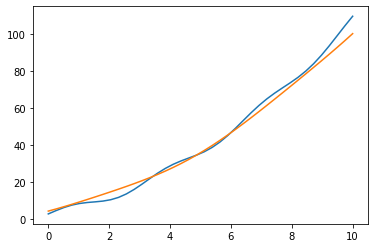

In [11]:
# Not perfect but close. 

f_output_for_optimum = optimum[1]["f_output"]
plt.plot(target_series_times, target_series_values)

plt.plot(target_series_times, f_output_for_optimum)